# Disaggregation of the Construction Sector in a Multiregional IOT

Author: Mira Kopp

Data Inputs:
- Multiregional IOT including transaction matrix Z, final demand matrix Y
- Extension F of direct environmental pressures caused by each sector in the MRIOT
- Value added per subsector, monetary
- Total output (or production value) per subsector, monetary
- Construction volume per subsector, physical
    - building permits and permit_to_finaldemand_time
    - OR time series of stocks and lifetime per structure with stocks
- Material intensity per structure, physical
    - material content per structure
    - residual percentage (material not incorporated in structure)
    - onsite/inconstruction recycling percentage (material content not needed as extra supply)
- Material prices
- Currency conversion rate such as euro to usd
- Classifications
    - material-sector
    - material-materialpricesector
    - structure-subsector

Data Output: 
- square Z with multiple construction subsectors
- long Y with multiple construction subsectors
- wide F with multiple construction subsectors

Further operations possible with the model outputs
- environmental multipliers per construction subsector
- environmental footprint per construction subsector
- sourcing of environmental footprint per construction subsector
- total supply per construction subsector in physical/mixed and monetary units
- total inputs per construction subsector in physical/mixed and monetary units



Note: 
- Each section of the notebook can be executed separately after running the section 'Configurations'
- Exogenous data inputs are marked throughout the code with ####################. This should ease modifications.
- c signifies the sector that is disaggregated, in this case 'Construction'

## Configurations

this section: 
- allows to adjust settings, 
- imports modules and functions that are used throughout the script, 
- defines key variables and the base MRIOT that are used throughout the script, 

### Settings

In [84]:
## SETTINGS for bottom-up estimate

# Size of transport stocks
transport_stocks = '' #if '_wiedenhoferscaled', the transport stocks from Eurostat/Nguyen et al. are scaled to Wiedenhofer et al. 2024 levels, otherwise the transport stocks from Eurostat/Nguyen et al. are used

# Material intensity data
building_mi_source = '' # '_rasmi' for Fishman et al. 2024; '_carbenmats' for Röck et al. 2024 + Marinova et al. 2020 + Deetman et al. 2020
if building_mi_source == '_rasmi':
    building_mi_range = 'p_50' #'p_50': median, 'p_25':lower bound, 'p_75':upper bound; only active for '_rasmi'
else:
    building_mi_range = ''

transport_mi_source = '' #not implemented

# Prices
price_source = 'bonsai' #'bonsai' for Bonsai, 'comext' for EU Comext


## SETTINGS for disaggregation

# Granularity of disaggregation
aggregated_output = True #if True, differentiates only between Buildings, Roads, Railway, Electricity, and Other civil engineering; if False, differentiates also single dwelling buildings, wind electricity etc.
if aggregated_output == True:
    agg = '_agg'
else:
    agg = ''

# Allocation of supply across demanding sectors
if aggregated_output == True:
    zmatching = '' #if '_zmatching', the supply of subsectors is matched to sectors demanding c, otherwise the output of subsectors is split evenly across sectors demanding c
else:
    zmatching = ''

# Allocation of residual inputs to c
residuals_distribution = '_residualsdistributed' #if '_residualsdistributed', Other Civil Engineering has an average production recipe and the residuals are distributed equally according to the total output of each subsector; if '_residualsconservative' residuals are distributed according to the bottom-up estimates; if '_residualsinOCE' or '', the residuals are all in Other Civil Engineering

configuration_bottomup = (
    building_mi_source
    + building_mi_range
    + transport_mi_source
    + transport_stocks
)

configuration = (
    agg
    + building_mi_source
    + building_mi_range
    + transport_mi_source
    + transport_stocks
    + zmatching
    + residuals_distribution
)

print(configuration_bottomup)
print(configuration)


_agg_residualsdistributed


### Module and function import

In [85]:
# Import data processing modules
import pandas as pd # used throughout the code
import numpy as np # used throughout the code
import country_converter as coco # used for converting country names to ISO codes
from sklearn.impute import KNNImputer # used for imputation of missing physical construction volume data
from read_mym import read_mym_df #used for importing file to estimate electricity grid growth
import pyomo.environ as pyo # used for balancing
import yaml # used for balancing
import scipy as sp # used for correlation analysis after disaggregation

# Import visualization modules
import matplotlib.pyplot as plt # used for simple bar charts and as basis for plotly and seaborn library
import plotly.express as px # used for all stacked bar charts
import plotly.graph_objects as go # used for marimekko plot and for annotating stacked bar charts
import seaborn as sns # used for scatterplot and kdeplot in data and sensitivity analysis section after disaggregation
from textwrap import fill # used for scatterplot in data analysis section after disaggregation

# Display options
pd.options.display.float_format = '{:,.2f}'.format #limits printed decimal points to two
#pd.reset_option('^display.', silent=True) #option to reset the previous display option

In [86]:
# Data processing functions
def icio_import(iot_year, cp_or_pyp):
    """ 
    Loads and formats a MRIOT from ICIOv2021

    Creates a multi-indexed dataframe from a csv file 

    Args:
        iot_year (int): the year for which data should be loaded
        cp_or_pyp: if 'pyp', loads table in previous years prices (e.g. for SDA); else loads table in current prices ('cp')
    
    Returns:
        pandas.DataFrame: Multi-indexed matrix with region labels and literal sector labels on both axes
    """
    if cp_or_pyp == 'pyp':
        icio = pd.read_csv("data/ICIO_cp_pyp/ICIOpyp_"+str(iot_year)+"_fix.csv", index_col=[0], header=[0])
    else:
        icio = pd.read_csv("data/ICIO_cp_pyp/ICIOcp_"+str(iot_year)+".csv", index_col=[0], header=[0])
    icio.index = pd.MultiIndex.from_tuples(icio.index.str.split('_').tolist(), names=('region', 'sector'))
    icio.columns = pd.MultiIndex.from_tuples(icio.columns.str.split('_').tolist(), names=('region', 'sector'))
    concord_sectors = pd.read_excel('data/Concordance matrix ICIO.xlsx', sheet_name = 'Sectors', index_col=None, header=0, usecols=[0,1,2]) #concordance matrix with literal ICIO sector labels
    for i in concord_sectors.index.tolist():
        icio.rename(columns={concord_sectors.iloc[i,1]:concord_sectors.iloc[i,0]}, inplace=True) #column 1 contains the abbreviations, column 0 contains the literal sector labels
        icio.rename(index={concord_sectors.iloc[i,1]:concord_sectors.iloc[i,0]}, inplace=True)
    return icio

def multiply_subcategories(df_detail, df_aggregate):
    """ 
    Multiplies a detailed dataframe with an aggregated dataframe

    Returns a detailed dataframe in which each each row is multiplied with the corresponding row in the aggregated dataframe
    Index level 0 of the detailed dataframe must match the index of the aggregated dataframe.
    
    Args:
        df_detail: multi-indexed dataframe of length a*b and width c
        df_aggregate: dataframe of length a and width c
    
    Returns: 
        pandas.DataFrame: Detailed dataframe of length a*b and width c in which each each row is multiplied with the corresponding row in the aggregated dataframe
        """
    df_new = pd.DataFrame(index=df_detail.index, columns=df_detail.columns)
    for i in df_aggregate.index:
        df_new.update(df_detail.xs(i, axis=0, level=0, drop_level=False).mul(df_aggregate.loc[i], axis=1))
        
    return df_new


### Key variables

In [87]:
## Regional classification

# Countries for which bottom-up data should be collected and the disaggregation should be performed
eu_labels = coco.CountryConverter().EU27as('ISO3').ISO3.to_list() #EU27 (as of 2020) countries in ISO3 format

# Country groups for building material intensity 
if building_mi_source == '_rasmi': #source for all regions below: https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=10#regiondefs 
    oecd_eu12_h = ['CZE', 'EST', 'HUN', 'POL', 'SVK', 'SVN', 'CYP', 'MLT'] #Cyprus, Czech Republic, Estonia, Hungary, Malta, Poland, Slovakia, Slovenia
    oecd_eu12_m = ['BGR', 'LVA', 'LTU', 'ROU'] #Bulgaria, Latvia, Lithuania, Romania
    oecd_eu15 = coco.CountryConverter().EU15as('ISO3').ISO3.to_list()
    oecd_efta = ['ISL', 'NOR', 'CHE', 'LIE'] #Iceland, Norway, Switzerland, Liechtenstein
    oecd_eeu = ['ALB', 'BIH', 'HRV', 'MNE', 'MKD', 'SRB'] #Albania, Bosnia and Herzegovina, Croatia, Montenegro, Serbia, The former Yugoslav Republic of Macedonia
    oecd_tur = 'TUR' #Turkey
    ref_eeu_fsu = ['BLR', 'MDA', 'UKR'] #Belarus, Republic of Moldova, Ukraine
else:
    central_europe = ['BEL', 'SVK', 'POL', 'AUT', 'NLD', 'HUN','IRL','DEU','CZE','SVN','LUX','GBR', 'CHE', 'FRA'] #EU countries + UK + Switzerland
    southern_europe = ['ROU', 'PRT', 'BGR', 'CYP', 'ITA', 'HRV', 'ESP', 'GRC', 'MLT', 'MKD', 'SRB', 'ALB', 'BIH', 'MNE', 'TUR'] #EU countries + Albania, Bosnia and Herzegovina, North Macedonia, Montenegro, Serbia, Turkey
    northern_europe = ['FIN', 'LTU', 'LVA','SWE','DNK','EST','NOR'] #EU countries + Norway


## Currency exchange rates
eur_to_usd = 1.18 #from euros to usd in 2018

## MRIOT-specific variables
iot_year = 2018 #target year of the disaggregation
c = 'Construction' #string of target sector
f_label = 'PROD_CO2' #string of target extension
m_labels = ['Basic metals', 
            'Fabricated metal products',
            'Mining and quarrying, non-energy producing products',
            'Other non-metallic mineral products', 
            'Rubber and plastic products',
            'Wood and products of wood and cork'] #list of materials/sectors with data for disaggregation of specified inputs
if aggregated_output==True: #list of subsectors to be disaggregated
    j_labels = ['Buildings', 
                'Roads', 
                'Railways', 
                'Electricity infrastructure', 
                'Other civil engineering'] 
elif building_mi_source=='_rasmi': 
    j_labels = ['Buildings, dwelling single',
                'Buildings, dwelling multi',
                'Buildings, non-residential',
                'Roads, communal',
                'Roads, provincial',
                'Roads, state',
                'Roads, motorway',
                'Railways',
                'Electricity infrastructure, combustible fuels',
                'Electricity infrastructure, hydro',
                'Electricity infrastructure, nuclear and other fuels',
                'Electricity infrastructure, solar photovoltaic',
                'Electricity infrastructure, wind',
                'Electricity infrastructure, other renewables',
                'Other civil engineering']  
else:
    j_labels = ['Buildings, dwelling single',
                'Buildings, dwelling multi',
                'Buildings, education',
                'Buildings, offices',
                'Buildings, trade',
                'Buildings, other',
                'Electricity infrastructure, combustible fuels',
                'Electricity infrastructure, hydro',
                'Electricity infrastructure, nuclear and other fuels',
                'Electricity infrastructure, solar photovoltaic',
                'Electricity infrastructure, wind',
                'Electricity infrastructure, other renewables',
                'Roads, communal',
                'Roads, provincial',
                'Roads, state',
                'Roads, motorway',
                'Railways',
                'Other civil engineering']

# Check and selection variables
r = 67 #number of countries in the base MRIOT
s = 45 #number of sectors in the base MRIOT
n = len(j_labels) #number of subsectors to be disaggregated
m = len(m_labels) #number of materials/sectors with data for disaggregation #TODO: check that variable not assigned again throughout code
d = 6 #number of final demand categories

In [88]:
## Base MRIOT import
icio = icio_import(iot_year, 'cp') ##############################################

Z = icio.iloc[0:r*s,0:r*s] #interindustry transaction matrix
Y = icio.iloc[0:r*s,r*s:-1] #final demand matrix
y = Y.sum(1) #final demand vector
x = Z.sum(1)+Y.sum(1) #icio.iloc[0:r*s,-1] #total output vector
x[x<1] = 0 #replace tiny values with 0 to avoid distortions when dividing by x

x_crow = x.xs(c, axis=0, level=1) #total output of c
Y_crow = Y.xs(c, axis=0, level=1) #final demand for c
Z_crow = Z.xs(c, axis=0, level=1) #intermediate demand for c
Z_ccol = Z.xs(c, axis=1, level=1) #industry inputs to c

#Export
x_crow.to_csv('processed_data/x_crow.csv')

#Checks
print(len(x_crow)==r, len(Y_crow)==r, len(Z_crow)==r, len(Z_crow.columns)==r*s, len(Z_ccol)==r*s, len(Z_ccol.columns)==r)


## Extension import
F = pd.read_csv('data/ICIO_cp_pyp/extension2018/OECDICIO_extensions_OECD_SINTEF_Gloria.csv', index_col=0, header=0) ##############################################
F.index = pd.MultiIndex.from_tuples(F.index.str.split('_').tolist(), names=('region', 'sector')) 
concord_sectors = pd.read_excel('data/Concordance matrix ICIO.xlsx', sheet_name = 'Sectors', index_col=None, header=0, usecols=[0,1,2]) #concordance matrix with literal ICIO sector labels
for i in concord_sectors.index.tolist():
        F.rename(index={concord_sectors.iloc[i,1]:concord_sectors.iloc[i,0]}, inplace=True)
F = F.T
F = F[Z.columns]

f = F/x.transpose() #extension intensity vector
f = f.replace([np.inf, -np.inf, np.nan], 0) #replaces result of impossible divisions e.g. by 0

#Checks
print(f.loc[f_label].groupby(level=1).mean().idxmax())

True True True True True True
Electricity, gas, steam and air conditioning supply


## Preparation of model inputs: Supply of construction (*x_physical*, *x*)

this section imports, cleans and harmonises data on:
- physical construction volumes per structure per year --> later used for calculating the bottom-up estimate of material use, in case of aggregated_output==False used for further detailing monetary total output
- monetary total output data per subsector --> later used for splitting supply of construction and other industry inputs to construction across subsectors

### Physical construction volumes

In [89]:
# OPTIONS
only_eu = True #if True uses only EU27 countries, else collects data from all countries available in each database

# INITIATE DATABASE in which physical construction volumes are collected
fd = pd.DataFrame(columns=['Year', 'Country', 'Structure', 'Value', 'Value_source', 'Value_process','Unit'])

# FUNCTIONS to add entries to the database
def to_fd(df_flat, structure_label, fd_new):
    """ 
    Converts entries of construction volumes of one structure to the long-format database format without assigning Value_source, Value_process, or Unit

    Args:
        df_flat (dict): structure-indexed dictionary of wide-format pandas.DataFrames of stocks with countries in index and years in columns
        structure_label (string): name of the structure for which data should be converted to the fd format
        fd_new (pandas.DataFrame): long-format table with columns ['Year', 'Country', 'Structure', 'Value', 'Value_source', 'Value_process','Unit'] in which the construction volume should be recorded

    Returns:
        pandas.DataFrame: Long-format table with columns ['Year', 'Country', 'Structure', 'Value', 'Value_source', 'Value_process','Unit'] and additional entries
    """
    df_flat.index = coco.convert(names=df_flat.index, to='ISO3')
    if only_eu == True:
        df_flat = df_flat[df_flat.index.isin(eu_labels)]
    df_flat = df_flat.unstack().reset_index()
    df_flat.columns = ['Year', 'Country', 'Value']
    df_flat = df_flat[df_flat['Value'].notna()]
    df_flat.Year = df_flat.Year.astype(str)
    df_flat['Structure'] = structure_label
    fd_new.Value = fd_new.Value.astype(float)
    fd_new = pd.merge(df_flat, fd_new, how='outer')
    
    return fd_new


def add_structure(fd, df, structure_labels, process, unit, source, scalar=1, lifetime=1):
    """ 
    Adds a entries for construction volumes of a specific structure to an existing dataframe

    Args:
        fd (pandas.DataFrame): long-format table with columns ['Year', 'Country', 'Structure', 'Value', 'Value_source', 'Value_process','Unit'] in which the construction volume should be recorded
        df (dict): structure-indexed dictionary of wide-format pandas.DataFrames of stocks with countries in index and years in columns
        structure_labels (list of strings): keys of the dictionary df for which data should be converted to the fd format
        process (str): if 'expansion' calculates the year-to-year difference of stocks, if 'replacement' calculates the assumed linear replacement of existing stocks according to the specified lifetime, else uses the stock value as recorded
        unit (str): unit of the resulting value
        source (str): data source descriptor
        scalar (int): option to convert data to other magnitude e.g. m to km
        lifetime (int): option to calculate replacement based on lifetime

    Returns:
        pandas.DataFrame: Long-format table with columns ['Year', 'Country', 'Structure', 'Value', 'Value_source', 'Value_process','Unit'] and additional entries
    """
    fd_new = pd.DataFrame(columns=fd.columns)

    for i in structure_labels:
        if process == 'expansion':
            df_flat = df[i].diff(axis=1).dropna(axis=1, how='all')
        elif process == 'replacement': #assumes constant linear replacement of existing stock and linear construction
            df_flat = df[i]/lifetime
        else:
            df_flat = df[i]
        df_flat.index = coco.convert(names=df_flat.index, to='ISO3')
        if only_eu == True:
            df_flat = df_flat[df_flat.index.isin(eu_labels)]
        df_flat = df_flat.unstack().reset_index()
        df_flat.columns = ['Year', 'Country', 'Value']
        df_flat = df_flat[df_flat['Value'].notna()]
        df_flat.Year = df_flat.Year.astype(str)
        df_flat['Structure'] = i
        fd_new = pd.merge(df_flat, fd_new, how='outer')
    
    fd_new['Value'] = fd_new['Value']*scalar
    fd_new['Value_source'] = source
    fd_new['Value_process'] = process
    fd_new['Unit'] = unit
    fd = pd.concat([fd, fd_new])

    return fd

#### Buildings

In [90]:
#SHORT TERM BUSINESS STATISTICS: BUILDING PERMITS in Million m2
sts = {}
count = 38
for i in ['Buildings', 
          'Residential buildings', 
          'Residential buildings, except residences for communities', 
          'One-dwelling buildings', 'Two- and more dwelling buildings', 
          'Residences for communities', 
          'Non-residential buildings', 
          'Non-residential buildings, except office buildings', 
          'Office buildings']:
    sts[i] = pd.read_excel('external_data/240212_STS_BuildingPermits_sts_cobp_a_spreadsheet.xlsx', sheet_name='Sheet '+str(count), header=5, index_col=0, skiprows=5, skipfooter=7, na_values=[':', 'e', 'p', 's']) ##############################################
    sts[i].dropna(axis=1, how='all', inplace=True)
    sts[i].dropna(axis=0, how='all', inplace=True)
    count += 4

#converting format to final database
fd = add_structure(fd, sts, ['Buildings', 'Residential buildings', 'Non-residential buildings'], 'building permit', 'm2', 'EU Short-term Business Statistics Construction', 1e6)

#assuming same share of subgroups of buildings for all countries
sts_shares = pd.DataFrame(index=sts['Buildings'].columns)
for i,k in {'One-dwelling buildings':'Residential buildings', 
            'Two- and more dwelling buildings':'Residential buildings', 
            'Residences for communities':'Residential buildings', 
            'Non-residential buildings, except office buildings':'Non-residential buildings',
            'Office buildings':'Non-residential buildings'}.items():
    fd = to_fd(sts[k], i, fd)
    sts_shares[i] = sts[i].iloc[0]/sts[k].iloc[0]
    for year in range(int(fd.Year.min()), int(fd.Year.max())+1, 1):
        fd.loc[(fd['Structure']==i) & (fd['Year']==str(year)),'Value'] = (fd.loc[(fd['Structure']==k) & (fd['Year']==str(year)),'Value']*sts_shares.loc[str(year),i]).to_list()

fd['Value_source'] = 'EU Short-term Business Statistics Construction'
fd['Value_process'] = 'building permit'
fd['Unit'] = 'm2'

#simulating delay between permit and material use for construction
delay_permit_to_construction = round(2.6,0) #average delay between issue of permit and finalisation of construction, based on Röck et al. 2024 ##############################################
fd.Year = [str(int(int(i)+delay_permit_to_construction)) for i in fd.Year]

#IMPORT BUILDING STOCK OBSERVATORY in m2 useful floor area
bso = pd.read_excel('external_data/240127_BSO_BuildingStock_EU_2016-2020.xlsx', sheet_name='data', header=0) ##############################################
bso = bso[bso['Year']==2016] #uses 2016 since the shares are same for all years and 2016 is the year of the empirical data collection
bso.Country = coco.CountryConverter().pandas_convert(series=bso.Country, to='ISO3')

#assuming the share of subtypes of existing non-residential buildings in BSO in 2016 also applies to construction in STS
def bso_extract(indicator):
    return bso.loc[bso['Indicator']==indicator].iloc[:,-3:].set_index(['Year','Country']).droplevel(0)

fd_bso = pd.DataFrame(columns=fd.columns) 
bso_shares = pd.DataFrame(index=bso_extract('Non-residential floor area').index)
indicators = ['Floor area of other buildings', 
              'Floor area of education buildings', 
              'Floor area of health buildings', 
              'Floor area of hotel and restaurant buildings', 
              'Floor area of wholesale and retail trade buildings']
for i in indicators:
    fd_bso = fd.loc[fd['Structure']=='Non-residential buildings, except office buildings']
    fd_bso['Structure'] = i
    bso_shares[i] = bso_extract(i) / (bso_extract('Non-residential floor area') - bso_extract('Floor area of office buildings'))
    for country in fd_bso.Country.unique():
        fd_bso.loc[fd_bso['Country']==country,'Value'] = (fd_bso.loc[fd_bso['Country']==country,'Value']*bso_shares.loc[country,i]).to_list()   
    fd_bso['Value_source'] = 'EU Building Stock Observatory, scaled by EU Short-term Business Statistics'
    fd_bso['Value_process'] = 'building permit'
    fd_bso['Unit'] = 'm2'
    fd = pd.concat([fd, fd_bso])

    # #BUILDING STOCK OBSERVATORY updated version with 2020 data (exactly same shares as hotmaps 2016 data)
    # bso = pd.read_excel('external_data/240426_BSO_BuildingStockFlows_EU_1990-2020_data0.xlsx', sheet_name='Export', header=0) ##############################################
    # bso = bso[(bso['Subject']=='Useful floor area')&(bso['Country']!='EU27')&(bso['Building occupancy'].notna())]
    # bso.Country = coco.CountryConverter().pandas_convert(series=bso.Country, to='ISO3')

    # #assuming the share of subtypes of non-residential buildings in BSO in 2016 also applies to construction in STS
    # fd_bso = pd.DataFrame(columns=fd.columns) 
    # bso_shares = pd.DataFrame(index=bso[bso['Building use']=='Apartment buildings'].loc[:,['Country','Value']].groupby(by='Country').sum().index)
    # indicators = ['Other non-residential buildings', 'Educational buildings', 'Health buildings', 'Hotels and Restaurants', 'Trade buildings']
    # for i in indicators:
    #     fd_bso = fd.loc[fd['Structure']=='Non-residential buildings, except office buildings']
    #     fd_bso['Structure'] = i
    #     bso_shares[i] = bso[bso['Building use']==i].loc[:,['Country','Value']].groupby(by='Country').sum() / (bso[bso['Sector']=='Service'].loc[:,['Country','Value']].groupby(by='Country').sum() - bso[bso['Building use']=='Offices'].loc[:,['Country','Value']].groupby(by='Country').sum())
    #     for country in fd_bso.Country.unique():
    #         fd_bso.loc[fd_bso['Country']==country,'Value'] = (fd_bso.loc[fd_bso['Country']==country,'Value']*bso_shares.loc[country,i]).to_list()   
    #     fd_bso['Value_source'] = 'EU Building Stock Observatory, scaled by EU Short-term Business Statistics'
    #     fd_bso['Value_process'] = 'building permit'
    #     fd_bso['Unit'] = 'm2'
    #     fd = pd.concat([fd, fd_bso])
    
#assuming 10% of all building permits are for maintenance not construction
share_maintenance_in_permits = 0.1 #share of permits issued for maintenance of all building permits issues, based on Destatis ##############################################
fd_maintain = fd.copy()
fd_maintain.Value = fd.Value * share_maintenance_in_permits
fd_maintain['Value_process'] = 'replacement' #maintenance is considered as replacement of existing buildings

fd.Value = fd.Value * (1-share_maintenance_in_permits)
fd['Value_process'] = 'expansion' #construction is considered as expansion of existing building stock

#conversion to final database
fd = pd.concat([fd, fd_maintain])


# LUCAS Land Cover and Land Use Statistics: Greenhouses
lucas = {}
lucas['Greenhouses'] = pd.read_excel('external_data/240214_LUCAS_LandCover_Greenhouses_lan_lcv_art__custom_9878113_spreadsheet.xlsx', sheet_name='Sheet 12', header=1, index_col=0, skiprows=7, skipfooter=7, na_values=[':', 'bu', 'b','u']) ##############################################
lucas['Greenhouses'].dropna(axis=1, how='all', inplace=True)
lucas['Greenhouses'].dropna(axis=0, how='all', inplace=True)
lucas_cols = pd.DataFrame(columns=[str(i) for i in range(int(lucas['Greenhouses'].columns.min()), int(lucas['Greenhouses'].columns.max())+1, 1)])
lucas['Greenhouses'] = pd.merge(lucas['Greenhouses'], lucas_cols, how='outer').reindex(lucas_cols.columns, axis=1).set_index(lucas['Greenhouses'].index).astype(float)
lucas['Greenhouses'] = lucas['Greenhouses'].interpolate(method='linear', limit_direction='both', axis=1)

#conversion to final database
lifetime_greenhouse = 25 #years, lifetime of a greenhouse, based on ecoinvent ##############################################
fd = add_structure(fd, lucas, ['Greenhouses'], 'replacement', 'm2', 'EU LUCAS interpolated', 1000000, lifetime_greenhouse)
fd = add_structure(fd, lucas, ['Greenhouses'], 'expansion', 'm2', 'EU LUCAS interpolated', 1000000) #construction of new greenhouses

European Union - 27 countries (from 2020) not found in regex
Euro area – 20 countries (from 2023) not found in regex
Euro area - 19 countries  (2015-2022) not found in regex
European Union - 27 countries (from 2020) not found in regex
Euro area – 20 countries (from 2023) not found in regex
Euro area - 19 countries  (2015-2022) not found in regex
European Union - 27 countries (from 2020) not found in regex
Euro area – 20 countries (from 2023) not found in regex
Euro area - 19 countries  (2015-2022) not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
not found not found in regex
/var/folders/__/twfrdq8n75n5f0118_f88270000

#### Transport

In [91]:
bridges_tunnels = False #change to True to include a share of bridges and tunnels per road or rail type
# This option is relevant for national scale analysis of countries such as Austria, Italy and Slovakia which have relatively high shares (>5% of network length) of bridges and tunnels on some types of roads
# For EU-wide analysis of material use this option is not relevant due to the small overall share of bridges and tunnels

# WIEDENHOFER ET AL. 2024: ROAD LENGTHS used to impute values for missing data in Nguyen et al. 2023 and Eurostat
wiedenhofer = pd.read_excel('external_data/240212_Wiedenhofer_2024_MobilityInfrastructure_2021 - full supplementary data.xlsx', sheet_name='Lengths', header=0, index_col=0, skiprows=3) ##############################################
wiedenhofer.drop('Income level', axis=1, inplace=True)
wiedenhofer = wiedenhofer.loc[eu_labels]

#summing primary, secondary and tertiary roads as one category 'state roads' in line with Nguyen et al. 2023
wiedenhofer_sum = pd.DataFrame(index=wiedenhofer.index)
for i in range(0, 21, 3):
    wiedenhofer_sum[wiedenhofer.iloc[:,i].name] = wiedenhofer.iloc[:,i:i+3].sum(1)
state_roads_labels = ['Primary', 'Secondary', 'Tertiary']
wiedenhofer_sum['State roads'] = wiedenhofer[state_roads_labels].sum(1)

#extract widths of transport infrastructure
wiedenhofer_mi = pd.read_excel('external_data/240212_Wiedenhofer_2024_MobilityInfrastructure_2021 - full supplementary data.xlsx', sheet_name='MI', index_col=[0,1], header=[0,1], skiprows=3, skipfooter=4, na_values='                        -  ') ##############################################
wiedenhofer_mi = wiedenhofer_mi.droplevel(0, axis=0)
wiedenhofer_mi.fillna(0, inplace=True)
wiedenhofer_mi = wiedenhofer_mi.astype(float)
widths = wiedenhofer_mi.xs('Width', axis=1, level=1)
widths_ = widths.loc[widths.index.isin(wiedenhofer_sum.columns)].T
widths_.index = coco.CountryConverter().convert(widths_.index, to='ISO3')
widths_['State roads'] = widths_[state_roads_labels].mean(1)

# NGUYEN ET AL. 2023: ROAD LENGTHS in km
nguyen = {}
labels = ['Motorways', 'State roads', 'Provincial roads', 'Communal roads']
for i in labels:
    nguyen[i] = pd.read_excel('external_data/240214_Nguyen2023_Roads_Eurostat_transcribed.xlsx', sheet_name=i, header=0, index_col=0, dtype=object) ##############################################
    nguyen[i] = nguyen[i].astype(np.float64)
    nguyen[i].index=coco.convert(names=nguyen[i].index, to='ISO3')
    nguyen[i].replace(0, np.nan, inplace=True)

# impute missing values for road network length with Wiedenhofer et al. 2024 and calculate road surface area from network length (Nguyen et al. 2023) and widths (Wiedenhofer et al. 2024), 
wiedenhofer_nguyen_map = {'Motorway': 'Motorways', 
                          'State roads':'State roads', 
                          'Rural':'Provincial roads', 
                          'Local':'Communal roads'}
nguyen_area = {} #km2
for k,i in wiedenhofer_nguyen_map.items():
    df = nguyen[i].reindex(eu_labels).assign(wiedenhofer=wiedenhofer_sum[k].values)
    df.columns = df.columns.astype(str)
    nguyen[i] = pd.DataFrame(KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')\
            .fit(df).transform(df), index=df.index, columns=df.columns)
    nguyen[i].drop('wiedenhofer', axis=1, inplace=True)
    if transport_stocks == '_wiedenhoferscaled':
        nguyen[i] = nguyen[i] / nguyen[i].div(wiedenhofer_sum[k], axis=0)
    nguyen_area[i] = nguyen[i] * widths_.loc['AUT', k]/1e3 #km2

# Option with bridges and tunnels based on Wiedenhofer et al. 2024
if bridges_tunnels == True:
    wiedenhofer_bridges = pd.DataFrame(index=wiedenhofer.index)
    for i in range(0, 21, 3):
        wiedenhofer_bridges[wiedenhofer.iloc[:,i].name] = wiedenhofer.iloc[:,i+1]/wiedenhofer.iloc[:,i:i+3].sum(1)
    wiedenhofer_bridges['State roads'] = wiedenhofer[[i+' bridge' for i in state_roads_labels]].sum(1)/wiedenhofer_sum['State roads']

    wiedenhofer_tunnels = pd.DataFrame(index=wiedenhofer.index)
    for i in range(0, 21, 3):
        wiedenhofer_tunnels[wiedenhofer.iloc[:,i].name] = wiedenhofer.iloc[:,i+2]/wiedenhofer.iloc[:,i:i+3].sum(1)
    wiedenhofer_tunnels['State roads'] = wiedenhofer[[i+' tunnel' for i in state_roads_labels]].sum(1)/wiedenhofer_sum['State roads']

    for w_lab, n_lab in wiedenhofer_nguyen_map.items():
        nguyen[n_lab+' bridges'] = nguyen[n_lab].mul(wiedenhofer_bridges[w_lab].fillna(0), axis=0).fillna(0)
        nguyen[n_lab+' tunnels'] = nguyen[n_lab].mul(wiedenhofer_tunnels[w_lab].fillna(0), axis=0).fillna(0)
        nguyen[n_lab] = nguyen[n_lab] - nguyen[n_lab+' bridges'] - nguyen[n_lab+' tunnels']
        labels.append(n_lab+' bridges')
        labels.append(n_lab+' tunnels')

#conversion to final database
fd = add_structure(fd, nguyen, labels, 'stock', 'km', 'Eurostat / Nguyen et al. 2023, missing countries imputed with Wiedenhofer et al. 2024') #for Transport Infrastructure only stock is recorded, since maintenance depending on lifetime is calculated in material section
fd = add_structure(fd, nguyen, labels, 'expansion', 'km', 'Eurostat / Nguyen et al. 2023, missing countries imputed with Wiedenhofer et al. 2024')
fd = add_structure(fd, nguyen_area, labels, 'stock-area', 'km2', 'Eurostat / Nguyen et al. 2023, widths according to and missing countries imputed with Wiedenhofer et al. 2024' )

#EUROSTAT: RAILWAY LENGTHS
eurostat = {}
eurostat['Railway'] = pd.read_excel('external_data/240214_EUROSTAT_RailwayTrackLength_rail_if_tracks_spreadsheet.xlsx', sheet_name='Sheet 1', header=1, index_col=0, skiprows=7, skipfooter=7, na_values=[':', 'b', 'p', 's', 'z']) ##############################################
eurostat['Railway'].dropna(axis=1, how='all', inplace=True)
eurostat['Railway'].dropna(axis=0, how='all', inplace=True)
eurostat['Railway'].index = coco.convert(names=eurostat['Railway'].index, to='ISO3')
eurostat['Railway'] = eurostat['Railway'].interpolate(method='linear', limit_direction='both', axis=1)

# impute missing values and calculate railways surface area from network length (Nguyen et al. 2023) and widths (Wiedenhofer et al. 2024) 
df = eurostat['Railway'].reindex(eu_labels).assign(wiedenhofer=wiedenhofer_sum['Railway'].values)
df.columns = df.columns.astype(str)
eurostat['Railway'] = pd.DataFrame(KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')\
            .fit(df).transform(df), index=df.index, columns=df.columns)
eurostat['Railway'].drop('wiedenhofer', axis=1, inplace=True)
eurostat_area = {} #km2
eurostat_area['Railway'] = eurostat['Railway'] * widths_.loc['AUT', 'Railway']/1e3 #km2

labels = ['Railway']

# Option with bridges and tunnels based on Wiedenhofer et al. 2024
if bridges_tunnels == True:
    eurostat['Railway bridges'] = eurostat['Railway'].mul(wiedenhofer_bridges['Railway'].fillna(0), axis=0).fillna(0)
    eurostat['Railway tunnels'] = eurostat['Railway'].mul(wiedenhofer_tunnels['Railway'].fillna(0), axis=0).fillna(0)
    eurostat['Railway'] = eurostat['Railway'] - eurostat['Railway bridges'] - eurostat['Railway tunnels']
    labels.append('Railway bridges')
    labels.append('Railway tunnels')

#conversion to final database
fd = add_structure(fd, eurostat, labels, 'stock', 'km', 'Eurostat Railway Transport Infrastructure, interpolated') #for Transport Infrastructure only stock is recorded, since maintenance depending on lifetime is calculated in material section
fd = add_structure(fd, eurostat, labels, 'expansion', 'km', 'Eurostat Railway Transport Infrastructure, interpolated')  
fd = add_structure(fd, eurostat_area, labels, 'stock-area', 'km2', 'Eurostat Railway Transport Infrastructure, widths according to and missing countries imputed with Wiedenhofer et al. 2024' )


GCC not found in ISO3
Global average * not found in regex


#### Electricity Production Capacity

In [92]:
#EUROSTAT: ELECTRICITY PRODUCTION CAPACITY (MW)
sheet_lifetime_map = [(1, 'Total Electricity Production Capacity', np.NaN), #list with triples indicating sheet, technology, lifetime of power plant (lifetime based on based on Van Vuuren et al. 2006 in Deetman et al. 2021) ##############################################
     (7, 'Combustible fuels', 40), 
     (13, 'Hydro', 80), 
     (37, 'Geothermal', 30), 
     (43, 'Wind', 25), 
     (61, 'Solar thermal',25), 
     (67, 'Solar photovoltaic', 25), 
     (85, 'Tide, wave, ocean', 30), 
     (91, 'Nuclear and other fuels n.e.c.', 60),
     (97, 'Other fuels n.e.c.', 40)] #assuming other fuels has same lifetime as combustible fuels 
fd_eurostat = pd.DataFrame(columns=fd.columns)
fd_expansion = pd.DataFrame(columns=fd.columns)
eurostat_auto = {}
for (key, energy, lifetime) in sheet_lifetime_map:
    eurostat[energy] = pd.read_excel('external_data/240214_EUROSTAT_ElectricityProductionCapacity_nrg_inf_epc_spreadsheet.xlsx', sheet_name='Sheet '+str(key), header=0, index_col=0, engine='openpyxl', skiprows=10, skipfooter=3, na_values=[':']) ##############################################
    eurostat[energy].dropna(axis=1, how='all', inplace=True)
    eurostat[energy].dropna(axis=0, how='all', inplace=True)
    eurostat[energy] = eurostat[energy].interpolate(method='linear', limit_direction='forward', axis=1)

    eurostat_auto[energy] = pd.read_excel('external_data/240214_EUROSTAT_ElectricityProductionCapacity_nrg_inf_epc_spreadsheet.xlsx', sheet_name='Sheet '+str(key+1), header=0, index_col=0, engine='openpyxl', skiprows=10, skipfooter=3, na_values=[':']) ##############################################
    eurostat_auto[energy].dropna(axis=1, how='all', inplace=True)
    eurostat_auto[energy].dropna(axis=0, how='all', inplace=True)
    eurostat_auto[energy] = eurostat_auto[energy].interpolate(method='linear', limit_direction='forward', axis=1)

    eurostat[energy] = eurostat[energy] + eurostat_auto[energy]

    # stock maintanance
    fd_eurostat = to_fd(eurostat[energy].iloc[2:]/lifetime, energy, fd_eurostat)
    
    # stock expansion
    fd_expansion = to_fd(eurostat[energy].iloc[2:].diff(axis=1), energy, fd_expansion)


#conversion to final database
def fd_add_energy(fd, fd_energy, process):
    fd_energy.replace('Solar thermal', 'Solar photovoltaic', inplace=True)
    fd_energy.replace('Geothermal', 'Other renewables', inplace=True)
    fd_energy.replace('Tide, wave, ocean', 'Other renewables', inplace=True)
    fd_energy.replace('Other fuels n.e.c.', 'Combustible fuels', inplace=True)
    fd_energy = fd_energy.groupby(by=['Year', 'Country', 'Structure', 'Value_source', 'Value_process', 'Unit'], sort=False, as_index=False, dropna=False).sum()

    fd_energy['Value_source'] = 'Eurostat Electricity Production Capacity'
    fd_energy['Value_process'] = process
    fd_energy['Unit'] = 'MW'
    fd = pd.concat([fd, fd_energy])
    return fd

fd = fd_add_energy(fd, fd_eurostat, 'replacement')
fd = fd_add_energy(fd, fd_expansion, 'expansion')

#### Checks and Export

In [93]:
#renaming to common structure labels
replacement_map = {'Residences for communities':'Buildings, dwelling multi',
                    'One-dwelling buildings':'Buildings, dwelling single',
                    'Two- and more dwelling buildings':'Buildings, dwelling multi',
                    'Office buildings': 'Buildings, offices',
                    'Floor area of education buildings':'Buildings, education',
                    'Floor area of wholesale and retail trade buildings': 'Buildings, trade',
                    'Greenhouses':'Buildings, greenhouses',
                    'Floor area of other buildings':'Buildings, other',
                    'Floor area of health buildings':'Buildings, other',
                    'Floor area of hotel and restaurant buildings': 'Buildings, other', 
                    'Communal roads':'Roads, communal',
                    'Provincial roads':'Roads, provincial',
                    'State roads':'Roads, state',
                    'Motorways':'Roads, motorway',
                    'Railway':'Railways', 
                    'Nuclear and other fuels n.e.c.': 'Electricity infrastructure, nuclear and other fuels',
                    'Other renewables':'Electricity infrastructure, other renewables',
                    'Solar photovoltaic':'Electricity infrastructure, solar photovoltaic',
                    'Wind':'Electricity infrastructure, wind',
                    'Hydro':'Electricity infrastructure, hydro',
                    'Combustible fuels':'Electricity infrastructure, combustible fuels'}

fd['Structure'] = fd['Structure'].replace(replacement_map, regex=True)

#EXPORT
fd_out = fd.groupby(['Unit', 'Value_source', 'Structure', 'Value_process', 'Country', 'Year']).sum(numeric_only=True)
fd_out.to_csv('processed_data/x_crow_sub_phys_long'+transport_stocks+'.csv')

#removing higher level structure groups
fd_out = fd_out.drop(['Non-residential buildings, except office buildings', 
                      'Non-residential buildings', 
                      'Residential buildings', 
                      'Buildings', 
                      'Total Electricity Production Capacity'], axis=0, level=2)

fd_out = fd_out.drop('km2', axis=0, level=0)
fd_out.to_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv') #used for calculation of bottom-up estimate of material use; and for further detailing total output to structure-level

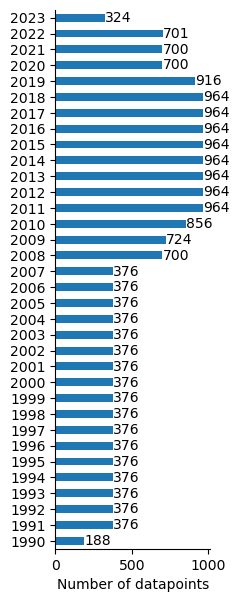

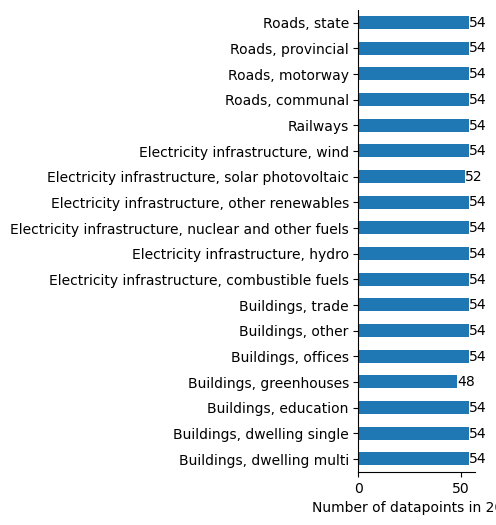

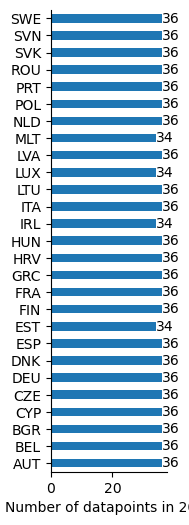

In [94]:
#VISUAL CHECKS of available data
df = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv').drop('Value', axis=1)
#df = df[df['Structure']!='Buildings, greenhouses']
ax = df.Year.value_counts().sort_index().loc[1990:2023].plot(kind='barh', figsize=(2,7), xlabel='Number of datapoints')
ax.bar_label(ax.containers[0], label_type='edge')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('images/bars_x_crow_sub_phys_datapoints_per_year.png', bbox_inches='tight', dpi=300)
plt.show()
ax = df[df['Year']==iot_year].Structure.value_counts().sort_index().plot(kind='barh', figsize=(1.5,6), xlabel='Number of datapoints in '+str(iot_year))
ax.bar_label(ax.containers[0], label_type='edge')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
ax = df[df['Year']==iot_year].Country.value_counts().sort_index().plot(kind='barh', figsize=(1.5,6), xlabel='Number of datapoints in '+str(iot_year))
ax.bar_label(ax.containers[0], label_type='edge')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [95]:
fd_out = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv', index_col=[0,1,2,3,4,5], header=0)
fd_out[fd_out<0] =0

df = fd_out.xs(2018, level=5).droplevel([1,3]).loc['MW'].groupby(level=[0,1]).sum().unstack(0).droplevel(0,axis=1)
df = df.div(df.sum(1), axis=0).sort_values('Electricity infrastructure, combustible fuels', ascending=False)
fig = px.bar(df, x=df.columns, y=df.index, text='value', text_auto='.0%',  labels={'value':'% MW constructed', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=px.colors.qualitative.Prism) #antique, vivid, prism, T10
fig.update_traces(textposition='inside')
fig.update_layout(width=350, height=1000, uniformtext_minsize=10, uniformtext_mode='hide', xaxis_tickformat = '.0%', yaxis = dict(autorange="reversed"), legend=dict(yanchor='top', y=-0.1, xanchor='left', x=-0.1))
fig.write_image('images/stackedbar_x_crow_sub_phys_electricity_country.svg')
fig.show()

df = fd_out.xs(2018, level=5).droplevel([1,3]).loc['m2'].groupby(level=[0,1]).sum().unstack(0).droplevel(0,axis=1).drop('Buildings, greenhouses', axis=1)
df = df.div(df.sum(1), axis=0).sort_values('Buildings, dwelling single', ascending=False)
fig = px.bar(df, x=df.columns, y=df.index, text='value', text_auto='.0%',  labels={'value':'% m2 constructed', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=px.colors.sequential.YlOrBr_r) #antique, vivid, prism, T10
fig.update_traces(textposition='inside')
fig.update_layout(width=350, height=1000, uniformtext_minsize=10, uniformtext_mode='hide', xaxis_tickformat = '.0%', yaxis = dict(autorange="reversed"), legend=dict(yanchor='top', y=-0.1, xanchor='left', x=-0.1))
fig.write_image('images/stackedbar_x_crow_sub_phys_buildings_country.svg')
fig.show()

fd_out = pd.read_csv('processed_data/x_crow_sub_phys_long'+transport_stocks+'.csv', index_col=[0,1,2,3,4,5], header=0)
fd_out[fd_out<0] =0

df = fd_out.xs(2018, level=5).droplevel([1,3]).loc['km2'].groupby(level=[0,1]).sum().unstack(0).droplevel(0,axis=1).drop('Railways', axis=1).reindex(['Roads, communal', 'Roads, provincial', 'Roads, state', 'Roads, motorway'], axis=1)
df = df.div(df.sum(1), axis=0).sort_values('Roads, communal', ascending=False)
fig = px.bar(df, x=df.columns, y=df.index, text='value', text_auto='.0%',  labels={'value':'% km2 stock', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=px.colors.sequential.Turbo) #antique, vivid, prism, T10
fig.update_traces(textposition='inside')
fig.update_layout(width=350, height=1000, uniformtext_minsize=10, uniformtext_mode='hide', xaxis_tickformat = '.0%', yaxis = dict(autorange="reversed"), legend=dict(yanchor='top', y=-0.1, xanchor='left', x=-0.1))
fig.write_image('images/stackedbar_x_crow_sub_phys_roads_country.svg')
fig.show()

In [96]:
#PLOTS of construction volumes

#construction volume (incl. expansion and maintenance work) of buildings
fd_out = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv', index_col=[0,1,2,3,4,5], header=0)
fd_out[fd_out<0] =0

m_plot = (fd_out.loc[('m2', slice(None), slice(None), slice(None), slice(None), slice(None))].groupby(['Year', 'Structure']).sum().drop('Buildings, greenhouses', axis=0, level=1).sort_index(level=[0,1], ascending=False)/1e6).reset_index()
m_plot = m_plot[(m_plot['Year']<2020) & (m_plot['Year']>2010)]
fig = px.area(m_plot, x='Year', y='Value', color='Structure',labels={'Value':'construction volume [km<sup>2</sup>]'}, template='simple_white', 
             color_discrete_sequence=px.colors.sequential.YlOrBr_r)
fig.update_layout(width=600, height=350, legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedarea_x_crow_sub_phys_buildings_eu.svg')
fig.show()

#construction volume (incl. expansion and maintenance work) of Electricity infrastructure
m_plot = (fd_out.loc[('MW', slice(None), slice(None), slice(None), slice(None), slice(None))].groupby(['Year', 'Structure']).sum().sort_index(level=[0,1], ascending=False)/1e3).reset_index()
m_plot = m_plot[(m_plot['Year']<2020) & (m_plot['Year']>2010)]
fig = px.area(m_plot, x='Year', y='Value', color='Structure',labels={'Value':'construction volume [1000 MW]'}, template='simple_white', 
             color_discrete_sequence=px.colors.sequential.Turbo_r[6:])
fig.update_layout(width=600, height=350, legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedarea_x_crow_sub_phys_electricity_eu.svg')
fig.show()

fd_out = pd.read_csv('processed_data/x_crow_sub_phys_long'+transport_stocks+'.csv', index_col=[0,1,2,3,4,5], header=0)
fd_out[fd_out<0] =0

#stocks of transport infrastructure
m_plot = (fd_out.loc[('km2', slice(None), slice(None), 'stock-area', slice(None), slice(None))].groupby(['Year', 'Structure']).sum().sort_index(level=[0,1], ascending=False)/1e3).reset_index()
m_plot = m_plot[(m_plot['Year']<2020) & (m_plot['Year']>2010)].sort_values(by=['Year','Value','Structure'])
fig = px.area(m_plot, x='Year', y='Value', color='Structure',labels={'Value':'stocks [1000 km<sup>2</sup>]'}, template='simple_white', 
             color_discrete_sequence=px.colors.sequential.Turbo)
fig.update_layout(width=600, height=350, legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedarea_x_crow_sub_phys_transport_eu.svg')
fig.show()

### Monetary total output

#### Data collection and cleaning

In [97]:
#STRUCTURAL BUSINESS STATISTICS: PRODUCTION VALUE per subsector in Million €
sbs_map = {1:'Construction',
     7:'Construction of buildings',
     37:'Civil engineering',
     43:'Construction of roads and railways',
     49:'Construction of roads and motorways', #misses values for NLD, CZE, MLT
     55:'Construction of railways and underground railways', #misses values for NLD, CZE, LUX
     61:'Construction of bridges and tunnels', #misses values for CZE, MLT
     67:'Construction of utility projects',
     79:'Construction of utility projects for electricity and telecommunications', #misses values for NLD, CZE, LUX, BEL
     103:'Specialised construction activities', 
     157:'Building completion and finishing'}
eurostat = {}
for key, sector in sbs_map.items():
    eurostat[sector] = pd.read_excel('external_data/240212_StructuralBusinessStatistics_TotalOutput_Labour_sbs_na_con_r2__custom_9831151_spreadsheet.xlsx', sheet_name='Sheet '+str(key), header=0, index_col=0, engine='openpyxl', skiprows=8, skipfooter=9, na_values=[':','de', 'b', 'p','d', 'e', 's', 'c', 'bd', 'du','u','bu', 'bu']) ##############################################
    eurostat[sector] = eurostat[sector].select_dtypes(include=['float64'])
    eurostat[sector].dropna(axis=1, how='all', inplace=True)
    eurostat[sector].dropna(axis=0, how='all', inplace=True)
    eurostat[sector].index = coco.convert(names=eurostat[sector].index, to='ISO3')
    eurostat[sector] = eurostat[sector].drop('not found', axis=0).reindex(eu_labels)
    eurostat[sector] = eurostat[sector].astype(np.float64)
    eurostat[sector] = eurostat[sector].interpolate(method='linear', limit_direction='both', axis=1)

#imputing missing values based on higher level values
sbs_detail_map = {'Construction of roads and motorways': 'Construction of roads and railways', 
     'Construction of railways and underground railways': 'Construction of roads and railways',
     'Construction of bridges and tunnels': 'Construction of roads and railways',
     'Construction of utility projects for electricity and telecommunications': 'Construction of utility projects'}
for k,i in sbs_detail_map.items():
    for year in range(int(eurostat[k].columns.min()), int(eurostat[k].columns.max())+1, 1):
        df = pd.concat([eurostat[k][str(year)], eurostat[i][str(year)]], axis=1)
        eurostat[k][str(year)] = KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')\
                    .fit(df).transform(df)[:,0]

#calculating horizontal differentiation of construction (instead of vertical) by distributing specialised construction activities across subsectors
eurostat['Other specialised construction activities'] = eurostat['Specialised construction activities'].sub(eurostat['Building completion and finishing'],fill_value=0)
eurostat['Construction except other specialised construction activities'] = eurostat['Construction'].sub(eurostat['Other specialised construction activities'],fill_value=0)

eurostat['Buildings'] = eurostat['Construction of buildings'].add(eurostat['Building completion and finishing'], fill_value=0)
eurostat['Buildings'] = eurostat['Buildings'].add((eurostat['Buildings'].div(eurostat['Construction except other specialised construction activities'], fill_value=0)).mul(eurostat['Other specialised construction activities'],fill_value=0), fill_value=0)

eurostat['Roads'] = eurostat['Construction of roads and motorways'].add((eurostat['Construction of roads and motorways'].div(eurostat['Construction of roads and motorways'].add(eurostat['Construction of railways and underground railways'],fill_value=0), fill_value=0)).mul(eurostat['Construction of bridges and tunnels'], fill_value=0), fill_value=0)
eurostat['Roads'] = eurostat['Roads'].add((eurostat['Roads'].div(eurostat['Construction except other specialised construction activities'],fill_value=0)).mul(eurostat['Other specialised construction activities'], fill_value=0), fill_value=0)

eurostat['Railways'] = eurostat['Construction of railways and underground railways'].add((eurostat['Construction of railways and underground railways'].div(eurostat['Construction of roads and motorways'].add(eurostat['Construction of railways and underground railways'], fill_value=0), fill_value=0)).mul(eurostat['Construction of bridges and tunnels'], fill_value=0), fill_value=0)
eurostat['Railways'] = eurostat['Railways'].add((eurostat['Railways'].div(eurostat['Construction except other specialised construction activities'], fill_value=0)).mul(eurostat['Other specialised construction activities'], fill_value=0), fill_value=0)

eurostat['Electricity infrastructure'] = eurostat['Construction of utility projects for electricity and telecommunications'].add((eurostat['Construction of utility projects for electricity and telecommunications'].div(eurostat['Construction except other specialised construction activities'],fill_value=0)).mul(eurostat['Other specialised construction activities'],fill_value=0), fill_value=0)

eurostat['Other civil engineering'] = eurostat['Construction'].sub(eurostat['Buildings'],fill_value=0).sub(eurostat['Roads'],fill_value=0).sub(eurostat['Railways'],fill_value=0).sub(eurostat['Electricity infrastructure'],fill_value=0) #residual total output not allocated to other subsectors
eurostat['Other civil engineering'][eurostat['Other civil engineering']<0] = 0 #negative values are set to zero to correct for wrong imputations

fd = add_structure(fd, eurostat, eurostat.keys(), 'production value', '€', 'Structural Business Statistics', 1e6)

# calculating each subsector share in total output of construction
if aggregated_output == True: 
    x_c_sub_pc = {}
    x_c_sub = {}
    for k in j_labels:
        x_c_sub_pc[k] = eurostat[k]/sum(df for key,df in eurostat.items() if key in j_labels)
        x_c_sub[k] = eurostat[k]
else: #in case aggregated_output==False, homogenous prices assumption is made, i.e. total output of each subsector is further detailed by structure using the share in physical construction volume of each structure
    #prices of output of broad subsectors

    #€/m2 building permit
    p_c_buildings = fd[(fd['Structure']=='Buildings')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') / fd[(fd['Structure']=='Buildings')&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum().unstack(1).droplevel(0, axis=1) # €/m2
    p_c_buildings.replace(0, np.NaN, inplace=True)
    p_c_buildings.dropna(axis=1, how='all', inplace=True)

    #€/m2-stock
    p_c_roads = fd[(fd['Structure']=='Roads')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') /fd[(fd['Structure'].isin(['Roads, communal', 'Roads, provincial','Roads, state','Roads, motorway']))&(fd['Value_process'].isin(['stock']))].groupby(by=['Country', 'Year'],sort=False).sum().unstack(1).droplevel(0, axis=1) # €/km
    p_c_roads.replace(0, np.NaN, inplace=True)
    p_c_roads.dropna(axis=1, how='all', inplace=True)
    for i in p_c_roads.columns[p_c_roads.isnull().any(axis=0)]:
            p_c_roads[i].fillna(p_c_roads[i].median(),inplace=True)

    #€/m2-stock
    p_c_railways = fd[(fd['Structure']=='Railways')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') /fd[(fd['Structure'].isin(['Railways']))&(fd['Value_process'].isin(['stock']))].groupby(by=['Country', 'Year'],sort=False).sum().unstack(1).droplevel(0, axis=1) # €/km
    p_c_railways.replace(0, np.NaN, inplace=True)
    p_c_railways.dropna(axis=1, how='all', inplace=True)
    for i in p_c_railways.columns[p_c_railways.isnull().any(axis=0)]:
            p_c_railways[i].fillna(p_c_railways[i].median(),inplace=True)

    #€/MW expansion and maintenance
    p_c_electricity = fd[(fd['Structure']=='Electricity infrastructure')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') / fd[(fd['Structure'].isin(['Electricity infrastructure, combustible fuels','Electricity infrastructure, nuclear and other fuels','Electricity infrastructure, other renewables', 'Electricity infrastructure, solar photovoltaic','Electricity infrastructure, wind', 'Electricity infrastructure, hydro']))&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).agg(lambda x: x[x>0].sum()).unstack(1).droplevel(0, axis=1) # €/MW
    p_c_electricity.replace(0, np.NaN, inplace=True)
    p_c_electricity.dropna(axis=1, how='all', inplace=True)
    for i in p_c_electricity.columns[p_c_electricity.isnull().any(axis=0)]:
            p_c_electricity[i].fillna(p_c_electricity[i].median(),inplace=True)  

    #monetary output per structure based on share in physical construction volume of structure group
    x_c_sub = {}
    for i in ['Buildings, dwelling multi', 
              'Buildings, dwelling single', 
              'Buildings, offices', 
              'Buildings, other', 
              'Buildings, education',
              'Buildings, trade', 
              'Buildings, greenhouses']:
        x_c_ = fd[(fd['Structure']=='Buildings')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') * (fd[(fd['Structure']==i)&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1) / fd[(fd['Structure']=='Buildings')&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1))
        x_c_.dropna(axis=1, how='all', inplace=True)
        x_c_sub[i] = x_c_

    for i in ['Roads, communal', 
              'Roads, provincial', 
              'Roads, state',
              'Roads, motorway']:
        x_c_ = fd[(fd['Structure']=='Roads')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') * (fd[(fd['Structure']==i)&(fd['Value_process'].isin(['stock-area']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1) / fd[(fd['Structure'].isin(['Roads, communal', 'Roads, provincial','Roads, state','Roads, motorway']))&(fd['Value_process'].isin(['stock-area']))].groupby(by=['Country', 'Year'],sort=False).sum().unstack(1).droplevel(0, axis=1))
        x_c_.dropna(axis=1, how='all', inplace=True)
        for j in x_c_[x_c_.isna().any(axis=1)].index: #Assumption if production value data not available, then production value is stock times average prices
            if fd[(fd['Structure']=='Roads')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value').loc[j].isna().all() and j in fd[(fd['Structure']==i)&(fd['Value_process'].isin(['stock']))].Country.unique():
                x_c_.loc[j]= p_c_roads.loc[j] * fd[(fd['Structure']==i)&(fd['Value_process'].isin(['stock']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1).loc[j]
        x_c_sub[i] = x_c_

    for i in ['Electricity infrastructure, combustible fuels', 
              'Electricity infrastructure, nuclear and other fuels', 
              'Electricity infrastructure, other renewables', 
              'Electricity infrastructure, solar photovoltaic', 
              'Electricity infrastructure, wind', 
              'Electricity infrastructure, hydro']:
        x_c_ = fd[(fd['Structure']=='Electricity infrastructure')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value') * (fd[(fd['Structure']==i)&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1) / fd[(fd['Structure'].isin(['Electricity infrastructure, combustible fuels','Electricity infrastructure, nuclear and other fuels','Electricity infrastructure, other renewables', 'Electricity infrastructure, solar photovoltaic','Electricity infrastructure, wind', 'Electricity infrastructure, hydro']))&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).agg(lambda x: x[x>0].sum()).unstack(1).droplevel(0, axis=1))
        x_c_.dropna(axis=1, how='all', inplace=True)
        for j in x_c_[x_c_.isna().any(axis=1)].index: #Assumption if production value data not available, then production value is stock times average prices
            if fd[(fd['Structure']=='Electricity infrastructure')&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value').loc[j].isna().all() and j in fd[(fd['Structure']==i)&(fd['Value_process'].isin(['stock']))].Country.unique():
                x_c_.loc[j]= p_c_electricity.loc[j] * fd[(fd['Structure']==i)&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1).loc[j]
        x_c_sub[i] = x_c_   

    for i in ['Railways', 
              'Other civil engineering', 
              'Construction']:
        x_c_ = fd[(fd['Structure']==i)&(fd['Value_process']=='production value')].pivot(index='Country', columns='Year', values='Value')
        x_c_.dropna(axis=1, how='all', inplace=True)
        x_c_sub[i] = x_c_

    x_c_sub_pc = {}
    for k, i in x_c_sub.items():
        x_c_sub_pc[k] = x_c_sub[k]/x_c_sub['Construction']

European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
European Union - 27 countries (from 2020) not found in regex
European Union - 28 coun

#### Checks and export

In [98]:
# EXPORT
eurostat['Construction'].to_csv('processed_data/sbs_construction.csv')

#total output according to Eurostat, €; for comparison with MRIOT-based estimates of x_crow_sub
if aggregated_output == True:
    x_crow_sub = pd.concat(x_c_sub, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
else:
    x_crow_sub = pd.concat(x_c_sub, axis=1).drop(['Buildings, greenhouses',c], axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
x_crow_sub.index.set_names(['year', 'region', 'sector'], inplace=True)
if building_mi_source == '_rasmi':
    x_crow_sub = x_crow_sub.reset_index()
    x_crow_sub.replace(['Buildings, education', 'Buildings, other', 'Buildings, trade', 'Buildings, offices'], 'Buildings, non-residential', inplace=True)
    x_crow_sub = x_crow_sub.groupby(by=['year','region','sector']).sum(numeric_only=True).squeeze()
x_crow_sub.to_csv('processed_data/x_crow_sub'+configuration+'.csv')

#distribution of total output across subsectors according to Eurostat, %currency; for disaggregation of Y_crow, Z_crow, Z_ccol
if aggregated_output == True:
    x_crow_sub_shares = pd.concat(x_c_sub_pc, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
else:
    x_crow_sub_shares = pd.concat(x_c_sub_pc, axis=1).drop(['Buildings, greenhouses',c], axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
x_crow_sub_shares.index.set_names(['year', 'region', 'sector'], inplace=True)
if building_mi_source == '_rasmi':
    x_crow_sub_shares = x_crow_sub_shares.reset_index()
    x_crow_sub_shares.replace(['Buildings, education', 'Buildings, other', 'Buildings, trade', 'Buildings, offices'], 'Buildings, non-residential', inplace=True)
    x_crow_sub_shares = x_crow_sub_shares.groupby(by=['year','region','sector']).sum(numeric_only=True).squeeze()
x_crow_sub_shares.to_csv('processed_data/x_crow_sub_shares'+configuration+'.csv')

#prices of subsector output, €/physical unit
if aggregated_output == False:
    p_c_buildings.to_csv('processed_data/p_c_buildings.csv')
    p_c_roads.to_csv('processed_data/p_c_roads'+transport_stocks+'.csv')
    p_c_railways.to_csv('processed_data/p_c_railways'+transport_stocks+'.csv')
    p_c_electricity.to_csv('processed_data/p_c_electricity.csv')

In [99]:
# PLOTS
# first graph: stacked area plot of shares of subsectors in total construction output
x_crow_sub_shares = pd.read_csv('processed_data/x_crow_sub_shares'+configuration+'.csv', index_col=[0,1,2]).squeeze('columns')
x_crow_sub_shares = x_crow_sub_shares.loc['2010':'2019']
x_crow_sub_shares[x_crow_sub_shares<0] = 0
x_crow_sub_shares = x_crow_sub_shares.unstack(0)
x_crow_sub_shares.columns.set_names(['year'], inplace=True)
x_crow_sub_shares.index.set_names(['region', 'subsector'], inplace=True)

icio_0 = icio_import(2010, 'cp')    
x_0 = icio_0.iloc[0:r*s,-1]
x_0[x_0<1] = 0   
x_construction = pd.DataFrame(index=x_0[:,c].index)
for year in range(2010,2020,1):
    icio_0 = icio_import(year, 'cp')
    x_0 = icio_0.iloc[0:r*s,-1]
    x_0[x_0<1] = 0
    x_construction[str(year)] = x_0[:,c]

x_crow_eu = x_construction.loc[eu_labels]
x_crow_eu.columns = x_crow_eu.columns.astype(int)
x_crow_eu.columns.set_names('year', inplace=True)

x_crow_sub_eu = multiply_subcategories(x_crow_sub_shares, x_crow_eu).stack().reset_index().rename(columns={0:'value'})
x_crow_sub_eu.year = x_crow_sub_eu.year.astype(int)
x_crow_sub_eu.subsector = [i.split(',')[0] for i in x_crow_sub_eu.subsector] #if 'Buildings' not in s else s 
x_crow_sub_eu.value = x_crow_sub_eu.value/1e6
x_crow_sub_eu.to_csv('processed_data/x_crow_sub_eu_icio_2010-2019.csv')
x_crow_sub_eu = x_crow_sub_eu.groupby(['year', 'subsector']).sum().drop('region', axis=1).reset_index()

fig = px.area(x_crow_sub_eu.sort_values(by=['year', 'value'], ascending=True), x='year', y='value', color='subsector',labels={'value':'total output of EU construction [trillion $]'}, template='simple_white', 
             color_discrete_sequence=[         
                                        '#785ef0', #railways
                                        '#ffb000', #electricity
                                        '#808080', #other civil engineering
                                        '#648fff', #roads
                                        '#fe6100', #buildings
                                        ])
fig.update_layout(width=750, height=450, legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedarea_x_crow_sub_eu'+configuration+'.svg')
fig.show()


In [100]:
# CHECKS: Prices

def lineplot_annotated(df):
    """ function to plot a lineplot with labels on the right side """
    ax = df.plot(legend=False)

    for line, name in zip(ax.lines, df.columns):
        y = line.get_ydata()[-1]
        ax.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=10, va="center")
        
    plt.margins(0)
    plt.show()

if aggregated_output == False:
    lineplot_annotated(p_c_buildings.T)
    lineplot_annotated(p_c_roads.T)
    lineplot_annotated(p_c_railways.T)
    lineplot_annotated(p_c_electricity.T)

## Disaggregation of construction supply to intermediate and final demand (**Z**, **Y**)

this section disaggregates the supply of construction to:
- intermediate demand, Z_crow --> later used in disaggregating Z_ccol
- final demand, Y_crow --> model output: Y_sub

In [101]:
#Subsector share in total output of construction for disaggregation of Y_crow and Z_crow, %currency
x_crow_sub_shares = pd.read_csv('processed_data/x_crow_sub_shares'+configuration+'.csv', index_col=[0,1,2]).squeeze('columns').loc[iot_year]
x_crow_sub_shares[x_crow_sub_shares<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material

### Supply to intermediate demand

In [102]:
#disaggregation of intermediate demand for EU construction based on total output shares
Z_crow_eu = Z_crow.loc[eu_labels,:] #select section of dataframe to be disaggregated

x_crow_sub_shares_wide = pd.concat([x_crow_sub_shares]*r*s, axis=1) 
x_crow_sub_shares_wide.columns = Z_crow_eu.columns
Z_crow_sub_eu = multiply_subcategories(x_crow_sub_shares_wide, Z_crow_eu) #disaggregate

if zmatching == '_zmatching': #matching intermediate demand by other sectors with the respective construction subsector
    for sector, subsectors in {'Real estate activities':['Buildings'],
                'Land transport and transport via pipelines': ['Roads', 'Railways', 'Other civil engineering'],
                'Electricity infrastructure, gas, steam and air conditioning supply':['Electricity infrastructure']}.items(): #this is an example, other matchings can be implemented
        Z_crow_sub_eu.loc[:, (slice(None), sector)] = 0
        for subsector in subsectors:
            Z_crow_sub_eu.loc[(slice(None),subsector), (slice(None), sector)] = Z_crow_eu.loc[:, (slice(None), sector)].mul(x_crow_sub_shares.unstack().div((x_crow_sub_shares.unstack()[subsectors]).sum(1), axis=0)[subsector], axis=0).assign(sector=subsector).set_index('sector', append=True).reorder_levels(['region', 'sector'])

Z_crow_sub_eu.index.set_names(['region', 'subsector'], inplace=True)
Z_crow_sub_eu = Z_crow_sub_eu.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector'])

#insert the disaggregated slice, Z_crow_sub_eu, back into Z
Z_subrow = Z.copy()
Z_subrow = Z_subrow.assign(subsector='Total').set_index('subsector', append=True)
Z_subrow = Z_subrow.append(Z_crow_sub_eu).sort_index() #this is creating a different sorting than columns
Z_subrow = Z_subrow.drop(index=Z_subrow.loc[pd.IndexSlice[eu_labels,c,'Total'],:].index)

#Check
len(Z_subrow) == r*s -len(eu_labels) + len(eu_labels)*n

#Export
Z_subrow.replace(np.nan, 0, inplace=True)
Z_subrow.to_csv('processed_data/Z_subrow'+configuration+'.csv') #million $ #later used in disaggregation of columns of Z

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/1659959016.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### Supply to final demand (including GFCF and final consumption)

In [103]:
# disaggregation of final demand for EU construction based on total output shares
Y_crow_eu = Y_crow.loc[eu_labels,:] #select section of dataframe to be disaggregated

x_crow_sub_shares_wide = pd.concat([x_crow_sub_shares]*r*d, axis=1)
x_crow_sub_shares_wide.columns = Y_crow_eu.columns
Y_crow_sub_eu = multiply_subcategories(x_crow_sub_shares_wide, Y_crow_eu) #disaggregate

Y_crow_sub_eu.index.set_names(['region', 'subsector'], inplace=True)
Y_crow_sub_eu = Y_crow_sub_eu.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector'])

#insert the disaggregated slice, Y_crow_sub_eu, back into Y
Y_sub = Y.copy()
Y_sub = Y_sub.assign(subsector='Total').set_index('subsector', append=True)
Y_sub = Y_sub.append(Y_crow_sub_eu).sort_index() #this is creating a different sorting than columns
Y_sub = Y_sub.drop(index=Y_sub.loc[pd.IndexSlice[eu_labels,c,'Total'],:].index)

#Check
len(Y_sub) == r*s -len(eu_labels) + len(eu_labels)*n

#Export
Y_sub.replace(np.nan, 0, inplace=True)
Y_sub.to_csv('processed_data/Y_sub'+configuration+'.csv') #million $ #output: Final demand in all countries disaggregated for construction in EU countries

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/499538938.py:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### Total output by subsector

In [104]:
Y_sub = pd.read_csv('processed_data/Y_sub'+configuration+'.csv', index_col=[0,1,2], header=[0,1]) #million $
Z_subrow = pd.read_csv('processed_data/Z_subrow'+configuration+'.csv', index_col=[0,1,2], header=[0,1]) #million $

#Total output per subsector, EU total, million $
x_crow_sub_summary = (Y_sub.sum(1).groupby(level=2).sum()+Z_subrow.sum(1).groupby(level=2).sum()).drop('Total') 
x_crow_sub_summary.to_csv('processed_data/x_crow_sub_summary'+configuration+'.csv')

#Total output per subsector in each EU country, million $
x_crow_sub_eu_icio = (Y_sub.sum(1).groupby(level=[0,2]).sum()+Z_subrow.sum(1).groupby(level=[0,2]).sum()).drop('Total', level=1).unstack(1)
if aggregated_output == True:
    x_crow_sub_eu_icio = x_crow_sub_eu_icio.sort_values('Buildings', ascending=False) #million $
else:
    x_crow_sub_eu_icio = x_crow_sub_eu_icio.sort_values('Buildings, dwelling single', ascending=False)
x_crow_sub_eu_icio.to_csv('processed_data/x_crow_sub_eu_icio'+configuration+'.csv')

### Checks

In [105]:
#share of gfcf in each subsector construction (variance is a result of variance between countries)
Y_sub.loc[pd.IndexSlice[eu_labels,c,:], pd.IndexSlice[eu_labels, 'GFCF']].sum(1).droplevel(1).unstack(1).sum() / x_crow_sub_eu_icio.sum() *100

subsector
Buildings                    61.16
Electricity infrastructure   61.09
Other civil engineering      60.87
Railways                     58.99
Roads                        61.17
dtype: float64

In [106]:
print(Z.sum().sum(), Z.isna().sum().sum(), (Z==0).sum().sum())
print(Z_subrow.sum().sum(), Z_subrow.isna().sum().sum(), (Z_subrow==0).sum().sum())
print(x.sum().sum(), x.isna().sum().sum(), (x==0).sum().sum())
print(x_crow[eu_labels].sum().sum(), x_crow[eu_labels].isna().sum().sum(), (x_crow[eu_labels]==0).sum().sum())
print(x_crow_sub_eu_icio.sum().sum(), x_crow_sub_eu_icio.isna().sum().sum(), (x_crow_sub_eu_icio==0).sum().sum()) #difference of 3 between self-calculated x and x recorded in ICIO
print(Y.sum().sum(), Y.isna().sum().sum(), (Y==0).sum().sum())
print(Y_sub.sum().sum(), Y_sub.isna().sum().sum(), (Y_sub==0).sum().sum())

85882103.25563526 0 1136487
85882103.25563526 0 1188817
169258183.9247483 0 28
1962199.809862608 0 0
1962199.8098626074 0 3
83376083.27164035 0 260787
83376083.27164035 0 269341


In [107]:
#DESCRIPTIVE STATISTICS: total output and distribution of total output
print((Y_sub.loc[pd.IndexSlice[eu_labels,c,:],eu_labels].xs('GFCF', axis=1, level=1).sum(1)/x_crow_sub_eu_icio.stack()).unstack(1).describe())
print(x_crow_sub_shares.unstack(1).describe())
x_crow_sub_shares.unstack(1)

subsector  Buildings  Electricity infrastructure  Other civil engineering  \
count          27.00                       27.00                    26.00   
mean            0.61                        0.61                     0.61   
std             0.11                        0.11                     0.11   
min             0.42                        0.42                     0.42   
25%             0.53                        0.53                     0.53   
50%             0.61                        0.61                     0.62   
75%             0.69                        0.69                     0.69   
max             0.83                        0.83                     0.83   

subsector  Railways  Roads  
count         25.00  27.00  
mean           0.61   0.61  
std            0.11   0.11  
min            0.42   0.42  
25%            0.53   0.53  
50%            0.62   0.61  
75%            0.69   0.69  
max            0.83   0.83  
sector  Buildings  Electricity infrastructure

sector  Buildings  Electricity infrastructure  Other civil engineering  \
region                                                                   
AUT          0.73                        0.02                     0.05   
BEL          0.77                        0.02                     0.12   
BGR          0.58                        0.03                     0.10   
CYP          0.92                        0.00                     0.02   
CZE          0.63                        0.04                     0.08   
DEU          0.76                        0.02                     0.10   
DNK          0.81                        0.01                     0.11   
ESP          0.81                        0.03                     0.03   
EST          0.66                        0.06                     0.10   
FIN          0.84                        0.06                     0.03   
FRA          0.75                        0.02                     0.05   
GRC          0.36                        0.07                     0.18   
HRV          0.65                        0.05                     0.11   
HUN          0.58                        0.06                     0.08   
IRL          0.89                        0.03                     0.03   
ITA          0.79                        0.04                     0.06   
LTU          0.72                        0.06                     0.08   
LUX          0.81                        0.00                     0.05   
LVA          0.64                        0.08                     0.08   
MLT          0.80                        0.00                     0.00   
NLD          0.77                        0.03                     0.06   
POL          0.71                        0.04                     0.06   
PRT          0.69                        0.03                     0.14   
ROU          0.74                        0.02                     0.05   
SVK          0.63                        0.03                     0.06   
SVN          0.67                        0.03                     0.08   
SWE          0.85                        0.02                     0.02   

sector  Railways  Roads  
region                   
AUT         0.01   0.19  
BEL         0.01   0.08  
BGR         0.03   0.27  
CYP         0.00   0.05  
CZE         0.05   0.20  
DEU         0.01   0.11  
DNK         0.03   0.04  
ESP         0.03   0.09  
EST         0.01   0.18  
FIN         0.02   0.06  
FRA         0.00   0.17  
GRC         0.05   0.35  
HRV         0.00   0.19  
HUN         0.06   0.22  
IRL         0.00   0.05  
ITA         0.03   0.08  
LTU         0.00   0.15  
LUX         0.00   0.12  
LVA         0.00   0.20  
MLT         0.00   0.20  
NLD         0.03   0.11  
POL         0.04   0.16  
PRT         0.01   0.14  
ROU         0.01   0.18  
SVK         0.02   0.26  
SVN         0.03   0.19  
SWE         0.03   0.08

## Preparation of model inputs: Material intensity (*mi*)

this section:
- shows the contribution of different inputs to the environmental impact of construction --> used to determine which inputs to focus on
- imports, cleans and harmonises data on material intensities per structure of buildings, transport infrastructure, electricity infrastructure --> later used to calculate physical bottom-up estimate of material use

### Which inputs to focus disaggregation effort on?

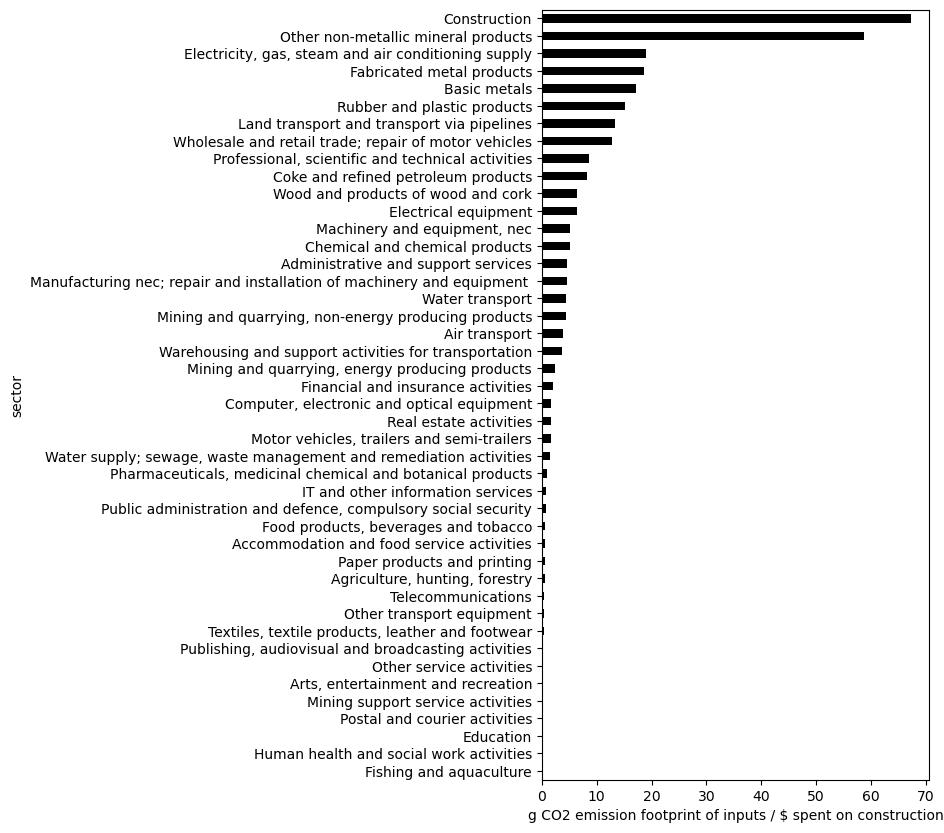

In [108]:
# mean multiplier of construction in EU
I = np.identity(Z.shape[0])
x_0_ = x.copy() 
x_0_[x_0_!=0] = 1/x_0_[x_0_!=0]
inv_diag_x_0 = np.diag(x_0_) 
A_0 = Z@inv_diag_x_0 
A_0.columns = Z.columns
A_0 = A_0.astype(float)
L_0 = np.linalg.inv(I-A_0)
mult_sector = f @ L_0
mult_sector.columns = A_0.columns
mult_sector_sum = mult_sector.groupby(level=1, axis=1, sort=False).mean() 

# calculation of the input contribution to the multiplier
A_mean = A_0.xs(c, level=1,axis=1).groupby(level=1,axis=0,sort=False).sum()[eu_labels]
((A_mean.mean(1)*mult_sector_sum.T.loc[:,f_label]).sort_values()*1e6)[1:].plot(kind='barh', figsize=(5,10), color='black')
plt.xlabel('g CO2 emission footprint of inputs / $ spent on construction')
plt.savefig('images/bars_mult_c_sector_sum.png', bbox_inches='tight', dpi=300)

### Intensity of specified inputs

In [109]:
#INITIALISE DATAFRAME to collect material intensities per structure
mi_df = pd.DataFrame(columns=['Year', 'Region', 'Structure', 'Material', 'Value', 'Value_source', 'Value_samplesize', 'Value_process', 'Unit'])

#### Buildings

In [110]:
if building_mi_source == '_rasmi':
    #FISHMAN ET AL. 2024: Material intensity database with partially synthetic (machine-learning-generated) data
    rasmi_d = pd.read_excel('external_data/240501_Fishman_RASMI_Buildings_MI_ranges_20230905.xlsx', sheet_name=None, index_col=0, header=0) ##################################
    rasmi_df = pd.DataFrame()
    for k, rasmi in rasmi_d.items():
        rasmi = rasmi[rasmi['R5_32'].isin(['OECD_EEU', 'OECD_EFTA', 'OECD_EU12-H', 'OECD_EU12-M', 'OECD_EU15','REF_EEU-FSU'])]
        structure_shares = 1/rasmi.groupby(by=['function', 'structure']).sum(numeric_only=True).increment_iterations.unstack(1).div(rasmi.groupby(by=['function']).sum(numeric_only=True).increment_iterations, axis=0)
        structure_shares = structure_shares.div(structure_shares.sum(1), axis=0).stack() #assumption: prevalence of each building structure type (e.g. wood-frame structure, concrete structure) is indicated by the prevalence among MSA studies
        rasmi = rasmi.set_index(['function', 'structure','R5_32']).drop(['R5','raw_HF_db_count', 'increment_iterations', 'incremented_count'], axis=1)
        rasmi = rasmi.multiply(structure_shares.reindex(rasmi.index, method='ffill'), axis=0).groupby(axis=0, level=[0,2]).sum(numeric_only=True)
        rasmi.rename(index={'NR': 'Buildings, non-residential', 'RM': 'Buildings, dwelling multi', 'RS': 'Buildings, dwelling single'}, inplace=True)
        rasmi_df[k] = rasmi[building_mi_range]
    rasmi_df.columns = [i.capitalize() for i in rasmi_df.columns]
    rasmi_df = rasmi_df.stack().reset_index()
    rasmi_df.columns = ['Structure', 'Region', 'Material', 'Value']
    mi_df = pd.merge(rasmi_df, mi_df, how='outer')
    mi_df['Value_source'] = 'Fishman et al. 2024'
    mi_df['Value_samplesize'] = 30
    mi_df['Value_process'] = 'expansion (& replacement)'
    mi_df['Unit'] = 'kg/m2'
else:
    #RÖCK ET AL. 2024: CARBENMATS-BUILDINGS LCA-Database including material intensities
    cem = pd.read_excel('external_data/240307_Roeck_MatIntensity_Buildings_carbenmats-buildings-7557e1f/CarbEnMats_dataset.xlsx', header=0, index_col=1, na_values='No data') ##############################################
    cem.drop(cem.columns[0], axis=1, inplace=True)

    cem_materials = pd.read_excel('external_data/240307_Roeck_MatIntensity_Buildings_carbenmats-buildings-7557e1f/CarbEnMats_materials.xlsx', header=1, skiprows=0,skipfooter=5, usecols=[0,1]) ##############################################
    cem_materials['related attribute (secondary)'] = [i[2:] for i in cem_materials['related attribute (secondary)']]
    materials = cem_materials.set_index('inv_mat_*_type').to_dict()['related attribute (secondary)']
    mi = []
    for material, matlab in materials.items():
        mi.append('mi_'+str(matlab)) #create a list of material intensity labels

    cem_mi = cem.dropna(how='all', subset=mi) #select only those records with material intensity information


    #DEETMAN ET AL. 2020: MSA/LCA database; adding another 16 point estimates of material intensity in non-residential buildings
    deetman_mi = pd.read_excel('external_data/240212_Deetman_2020_MatIntensity_Nonresidential/1-s2.0-S0959652619335280-mmc1.xlsx', header=None, names=['bldg_use_subtype', 'admin_data_partner','description', 'site_country', 'mi_steel_reinforcement', 'mi_concrete_reinforced', 'mi_aluminium', 'mi_brass_copper', 'mi_wood', 'mi_glass'], skiprows=1, skipfooter=1) ##############################################
    
    #harmonise labels with Röck et al. 
    deetman_mi.replace('Offices', 'Office', inplace=True)
    deetman_mi.replace('Retail+', 'Retail and Restaurant', inplace=True)
    deetman_mi.replace('Hotels+', 'Hotel & Resort', inplace=True)
    deetman_mi.drop('description', axis=1, inplace=True)
    deetman_mi.loc[13:14, 'bldg_use_subtype'] = 'School and Daycare'
    deetman_mi.loc[15, 'bldg_use_subtype'] = 'Hospital and Health'
    deetman_mi.loc[16, 'bldg_use_subtype'] = 'School and Daycare'

    cem_mi = pd.merge(cem_mi, deetman_mi, how='outer')


    #MARINOVA ET AL. 2020: MSA/LCA database; adding another set of point estimates of material intensity in residential buildings, Western Europe
    marinova_mi = pd.read_excel('external_data/240212_Marinova_2020_MatIntensity_Residential/Marinova_2020_MatIntensity_Residential.xlsx', sheet_name='Region 11', header=None, usecols=[1,4,8,9,11,18,22], names=['admin_data_partner','site_country', 'bldg_use_subtype', 'index','bldg_year_complete_interval', 'material', 'mi'], skiprows=1) ##############################################
    
    #harmonise labels with Röck et al. 
    marinova_mi[['site_city', 'site_country']] = marinova_mi['site_country'].str.split(', ', n=1, expand=True)
    marinova_mi['site_country'] = np.where((marinova_mi['site_city']=='South European Countries')|(marinova_mi['site_city']=='South European Countries ') | (marinova_mi['site_city']=='Central European countries')| (marinova_mi['site_city']=='North European countries') | (marinova_mi['site_city']=='Sweden') | (marinova_mi['site_city']=='UK'), marinova_mi['site_city'], marinova_mi['site_country'])
    marinova_mi['site_country'] = np.where(marinova_mi['site_city']=='Scotland','UK', marinova_mi['site_country'])
    marinova_mi.drop('site_city', axis=1, inplace=True)
    marinova_mi.replace(['Detached house', 'Detached house '], 'Single family house', inplace=True)
    marinova_mi.replace(['Apartment building ', 'High-rise building'], 'Multi-family house', inplace=True)
    marinova_mi.replace('Aluminium', 'mi_aluminium', inplace=True)
    marinova_mi.replace('Wood', 'mi_wood', inplace=True)
    marinova_mi.replace('Concrete', 'mi_concrete_reinforced', inplace=True)
    marinova_mi.replace('Glass', 'mi_glass', inplace=True)
    marinova_mi.replace('Copper', 'mi_brass_copper', inplace=True)
    marinova_mi.replace('Steel', 'mi_steel_reinforcement', inplace=True)
    marinova_mi = marinova_mi.pivot(index=['index', 'admin_data_partner', 'site_country', 'bldg_use_subtype','bldg_year_complete_interval'] , columns='material', values='mi')
    marinova_mi.reset_index(inplace=True)
    marinova_mi.drop('index', axis=1, inplace=True)

    cem_mi = pd.merge(cem_mi, marinova_mi, how='outer')


    #MARINOVA ET AL. 2020: MSA/LCA database; adding another set of point estimates of material intensity in residential buildings, Eastern Europe
    marinova_mi = pd.read_excel('external_data/240212_Marinova_2020_MatIntensity_Residential/Marinova_2020_MatIntensity_Residential.xlsx', sheet_name='Region 12', header=None, usecols=[1,4,8,9,11,18,22], names=['admin_data_partner','site_country', 'bldg_use_subtype', 'index','bldg_year_complete_interval', 'material', 'mi'], skiprows=1) ##############################################
    
    #harmonise labels with Röck et al. 
    marinova_mi.replace(['Detached house', 'Detached house '], 'Single family house', inplace=True)
    marinova_mi.replace(['Apartment building ', 'High-rise building'], 'Multi-family house', inplace=True)
    marinova_mi.replace('Aluminium', 'mi_aluminium', inplace=True)
    marinova_mi.replace('Wood', 'mi_wood', inplace=True)
    marinova_mi.replace('Concrete', 'mi_concrete_reinforced', inplace=True)
    marinova_mi.replace('Cement', 'mi_cement_mortar', inplace=True)
    marinova_mi.replace('Glass', 'mi_glass', inplace=True)
    marinova_mi.replace('Copper', 'mi_brass_copper', inplace=True)
    marinova_mi.replace('Steel', 'mi_steel_reinforcement', inplace=True)
    marinova_mi = marinova_mi.pivot(index=['index', 'admin_data_partner', 'site_country', 'bldg_use_subtype','bldg_year_complete_interval'] , columns='material', values='mi')
    marinova_mi.reset_index(inplace=True)
    marinova_mi.drop('index', axis=1, inplace=True)

    cem_mi = pd.merge(cem_mi, marinova_mi, how='outer')

    #further classification of material intensities by building type and region
    d_mi = {}
    d_mi = d_mi.fromkeys(mi, 0)
    cem_mi.fillna(d_mi, inplace=True) #fill nan values in material intensities with 0
    cem_mi['bldg_year_complete_interval'] = cem_mi['bldg_year_complete_interval'].str[-4:] #harmonise time period for potential time-period analysis
    cem_mi.replace('970s', '1980', inplace=True)
    cem_mi.drop(98, axis=0, inplace=True) #removing an outlier which had 100 times higher aluminium and plastic intensity
    cem_mi_out = cem_mi.copy()
    cem_mi_out.replace('Row house', 'Multi-family house', inplace=True)
    cem_mi_out.replace('Semi-detached', 'Multi-family house', inplace=True)
    cols = mi.copy()
    cols.append('bldg_use_subtype')
    cols.append('bldg_year_complete_interval')
    cols.append('site_country')
    cem_mi_out = cem_mi_out.loc[:,cols]
    cem_mi_out.reset_index(inplace=True)
    cem_mi_out.replace(['Denmark', 'Sweden', 'Finland', 'North European countries'], 'Northern Europe', inplace=True)
    cem_mi_out.replace(['Spain', 'Italy', 'France', 'Turkey', 'South European Countries', 'South European Countries '], 'Southern Europe', inplace=True)
    cem_mi_out.replace(['Austria', 'UK', 'UK ', 'United Kingdom','Belgium', 'Switzerland', 'Germany', 'Poland', 'Central European countries'], 'Central Europe', inplace=True)
    cem_mi_out.replace(['Singapore', 'China', 'Canada','Brazil', 'USA', 'Australia', 'South Korea', 'Mexico', 'Thailand', 'Japan', 'Sri Lanka', '-'], 'Other', inplace=True)
    l = pd.wide_to_long(cem_mi_out, stubnames='mi', i=['index', 'bldg_use_subtype', 'bldg_year_complete_interval', 'site_country'], j='material', sep='_', suffix=r'\w+')
    l.reset_index(inplace=True)
    l.replace(0, np.NaN, inplace=True)
    l.replace(['concrete_wo_reinforcement', 'concrete_reinforced'], 'concrete', inplace=True)
    l.replace('bamboo', 'wood', inplace=True)
    l.replace('EPS_XPS', 'plastics', inplace=True)
    l.replace('other', 'plastics', inplace=True)
    l.replace(['steel_reinforcement','metals'], 'steel', inplace=True)
    l.bldg_year_complete_interval = l.bldg_year_complete_interval.astype(float)

    #minimum threshold for sample size for calculation of median material intensity: 5 cases
    min_threshold = 5
    for i, v in cem_mi_out.groupby(by=['bldg_use_subtype']).size().items():
        if v < min_threshold:
            l.replace(i, 'Other', inplace=True)
            cem_mi_out.replace(i, 'Other', inplace=True)

    #grouping material intensities by building type and region if threshold is met otherwise only by building type
    l_detail = l.groupby(by=['bldg_use_subtype', 'site_country', 'material']).median(numeric_only=True).sort_index()
    l_global = l.groupby(by=['bldg_use_subtype', 'material']).median(numeric_only=True).sort_index()
    l_mi = pd.DataFrame(columns = l_detail.columns, index=l_detail.index)
    l_mi = l_mi.sort_index()
    for (i,j), v in cem_mi_out.groupby(by=['bldg_use_subtype', 'site_country']).size().items():
        if v >= min_threshold:
            for m in l.material.unique():
                l_mi.loc[(i,j,m)] = l_detail.loc[(i,j,m)]
                l_mi.loc[(i,j,m), 'Value_samplesize'] = v
        else:
            for m in l.material.unique():
                l_mi.loc[(i,'Global',m)] = l_global.loc[(i,m)]
                l_mi.loc[(i,'Global',m), 'Value_samplesize'] = cem_mi_out.groupby(by=['bldg_use_subtype']).size().loc[i]


    #further cleaning and adding the calculated material intensities to the database
    l_mi = l_mi.dropna(axis=0, how='all')
    l_mi['Value_samplesize'] = l_mi['Value_samplesize'].astype(int)
    l_mi = l_mi.drop(['index', 'bldg_year_complete_interval'], axis=1)
    l_mi.reset_index(inplace=True)
    l_mi.columns = ['Structure', 'Region', 'Material', 'Value', 'Value_samplesize']
    mi_df = pd.merge(l_mi, mi_df, how='outer')
    mi_df['Value_source'] = 'Röck et al. 2024, Deetman et al. 2021, Marinova et al. 2021'
    mi_df['Value_process'] = 'expansion (& replacement)'
    mi_df['Unit'] = 'kg/m2'

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/1471953491.py:48: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/1471953491.py:143: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/1471953491.py:143: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/1471953491.py:143: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/1471953491.py:143: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/1471953491.py:143: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folder

#### Transport infrastructure

In [111]:
#WIEDENHOFER ET AL. 2024: Material intensities of road and railway infrastructure in t/m2
wiedenhofer_mi = pd.read_excel('external_data/240212_Wiedenhofer_2024_MobilityInfrastructure_2021 - full supplementary data.xlsx', sheet_name='MI', index_col=[0,1], header=[0,1], skiprows=3, skipfooter=4, na_values='                        -  ') ##############################################
wiedenhofer_mi = wiedenhofer_mi.droplevel(0, axis=0)
wiedenhofer_mi.fillna(0, inplace=True)
wiedenhofer_mi = wiedenhofer_mi.astype(float)
widths = wiedenhofer_mi.xs('Width', axis=1, level=1)
wiedenhofer_mi = wiedenhofer_mi.drop('Width', axis=1, level=1)
wiedenhofer_mi = wiedenhofer_mi.drop('Total', axis=1, level=1)

#multiply width per country with material intensity to get to t/m
for i in wiedenhofer_mi.columns.levels[0].to_list():
    wiedenhofer_mi[(i,)] = wiedenhofer_mi.xs(i, axis=1, level=0).mul(widths[i], axis=0)

wiedenhofer_mi = wiedenhofer_mi*1000000 #multiply by 1000 to have kg/m, multiply by 1000 again to have kg/km

#drop not needed information
wiedenhofer_mi.drop('Runways (flexible) **', axis=0, inplace=True)
wiedenhofer_mi.drop('Runways (rigid) **', axis=0, inplace=True)
wiedenhofer_mi = wiedenhofer_mi.drop(['China', 'GCC', 'Japan', 'Nepal', 'South Africa', 'Turkey', 'USA'], axis=1, level=0)
wiedenhofer_mi_idx = wiedenhofer_mi.index

#divide 'Other' (used for railways only) into 'Aluminium' and 'Copper' (as specified in the supplementary material) assuming equal shares 
wiedenhofer_mi = wiedenhofer_mi.stack(0)
wiedenhofer_mi['Aluminium'] = wiedenhofer_mi['Other']*0.5
wiedenhofer_mi['Copper'] = wiedenhofer_mi['Other']*0.5
wiedenhofer_mi.drop('Other', axis=1, inplace=True)
wiedenhofer_mi = wiedenhofer_mi.unstack(1)
wiedenhofer_mi.columns = wiedenhofer_mi.columns.swaplevel(0, 1)


#expansion
# further cleaning and adding the calculated material intensities to the database
w = wiedenhofer_mi.stack().stack()
w = w.reset_index()
w.replace(0, np.NaN, inplace=True)
w.columns = ['Structure', 'Material', 'Region', 'Value']
w['Region'] = coco.CountryConverter().convert(w['Region'], to='ISO3')
w.replace('not found', 'Global', inplace=True)
w['Value_source'] = 'Wiedenhofer et al. 2024'
w['Value_process'] = 'expansion'
w['Unit'] = 'kg/km'
w['Year'] = 2021
mi_df = pd.merge(w, mi_df, how='outer')

#maintenance
#calculating material intensity per year of maintaining stocks, assuming linear replacement
wiedenhofer_mi = wiedenhofer_mi.reindex(wiedenhofer_mi_idx)

lifetimes = pd.DataFrame(index=wiedenhofer_mi.index)
lifetimes['Iron'] = [np.NaN]*6 + [120]*4 + [30] + [120]*5 + [30] ##############################################
lifetimes['Concrete'] = [33]*6 + [120]*4 + [50] + [120]*5 + [50] ##############################################
lifetimes['Asphalt'] = [21]*6 + [np.NaN]*11 ##############################################
lifetimes['Aggregate'] = [120]*17 ##############################################
lifetimes['Timber'] = [np.NaN]*6 + [np.NaN]*4 + [50] + [np.NaN]*5 + [50] ##############################################
lifetimes['Aluminium'] = [np.NaN]*6 + [120]*4 + [50] + [120]*5 + [50] ##############################################
lifetimes['Copper'] = [np.NaN]*6 + [120]*4 + [50] + [120]*5 + [50] ##############################################

wiedenhofer_mi.columns = wiedenhofer_mi.columns.swaplevel(0, 1)
wiedenhofer_mi.sort_index(axis=1, level=0, inplace=True)
for i in ['Aggregate', 'Asphalt', 'Concrete', 'Iron', 'Timber', 'Aluminium', 'Copper']:
    wiedenhofer_mi[(i)] = wiedenhofer_mi.xs(i, axis=1, level=0).div(lifetimes[i], axis=0)

#further cleaning and adding the calculated material intensities to the database
wiedenhofer_mi.columns = wiedenhofer_mi.columns.swaplevel(0, 1)
wiedenhofer_mi.sort_index(axis=1, level=0, inplace=True)
w = wiedenhofer_mi.stack().stack()
w = w.reset_index()
w.replace(0, np.NaN, inplace=True)
w.columns = ['Structure', 'Material', 'Region', 'Value']
w['Region'] = coco.CountryConverter().convert(w['Region'], to='ISO3')
w.replace('not found', 'Global', inplace=True)
w['Value_source'] = 'Wiedenhofer et al. 2024'
w['Value_process'] = 'replacement'
w['Unit'] = 'kg/km'
w['Year'] = 2021
mi_df = pd.merge(w, mi_df, how='outer')


# Applying onsite recycling and residual percentage to the material content intensities for transport infrastructure
recycling_percentage_roads_aggregate = 0.7 #based on informal conversation with road engineer in NL ##############################################
recycling_percentage_roads_asphalt = 0.3 #based on informal conversation with road engineer in NL ##############################################
residual_percentage_roads = (25/100*1000)/w[(w['Structure']=='Motorway') & (w['Value_process']=='replacement') & (w['Region']=='Global')].Value.sum() #residual percentage, extra material not incorporated into the road, 25 tonnes per 100km based on inquiry with NL road constructors ##############################################

mi_df.loc[mi_df['Unit']=='kg/km', 'Value'] = mi_df.loc[mi_df['Unit']=='kg/km', 'Value']/(1-residual_percentage_roads)
mi_df.loc[(mi_df['Unit']=='kg/km') & (mi_df['Material']=='Aggregate'), 'Value'] = mi_df.loc[(mi_df['Unit']=='kg/km') & (mi_df['Material']=='Aggregate'), 'Value']*(1-recycling_percentage_roads_aggregate)
mi_df.loc[(mi_df['Unit']=='kg/km') & (mi_df['Material']=='Asphalt'), 'Value'] = mi_df.loc[(mi_df['Unit']=='kg/km') & (mi_df['Material']=='Asphalt'), 'Value']*(1-recycling_percentage_roads_asphalt)

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/441947512.py:12: PerformanceWarning:

indexing past lexsort depth may impact performance.

Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * not found in regex
Global average * 

#### Electricity Generation Capacity

In [112]:
# DEETMAN ET AL. 2021: Material intensities of electricity infrastructure

# IMAGE file: Generation capacity (stock) in MW peak capacity (Used as proxy for grid growth)
gcap_BL_data = read_mym_df('external_data/240212_Deetman_2020_MatIntensity_Electricity/Gcap.out')
gcap_BL_data = gcap_BL_data.loc[gcap_BL_data['DIM_1'].isin([11,12])]
gcap_BL_data.DIM_1 = gcap_BL_data.DIM_1.replace(11,'Western Europe')
gcap_BL_data.DIM_1 = gcap_BL_data.DIM_1.replace(12,'Central Europe')
gcap_BL_data.time = gcap_BL_data.time.astype(str)
gcap_total = gcap_BL_data.set_index(['time', 'DIM_1']).loc[:,29].sort_index().rename_axis(['year', 'region']).loc['2016'] #only selecting total generation capacity

# Grid size in 2016
grid_m = pd.read_csv('external_data/240212_Deetman_2020_MatIntensity_Electricity/grid_materials_output_kt.csv', index_col=[0,1,2,3,4,5], header=0)
grid_m = grid_m.loc[pd.IndexSlice[grid_m.index.isin(['Western Europe','Central Europe'], level=0),'stock', :,:,:,:]]
grid_m = grid_m.groupby(axis=0, level=[0,5]).sum().stack().unstack(1).reorder_levels([1,0]).sort_index().rename_axis(['year', 'region']).loc['2016']

# Grid size per generation capacity
grid_mi = grid_m.div(gcap_total, axis=0)*1e6 #kg per MW

# Material intensity of electricity generation technology (power plants) in g/MW
deetman_mi = pd.read_csv('external_data/240212_Deetman_2020_MatIntensity_Electricity/composition_generation.csv', header=0, index_col=[0,1]) ##############################################
deetman_mi.drop(2050, axis=0, level=0, inplace=True)
deetman_mi = deetman_mi/1000 #from g/MW to kg/MW
deetman_mi.drop('<EMPTY>', axis=0, level=1, inplace=True)
deetman_mi = deetman_mi.add(grid_mi.mean(0)) #adding grid infrastructure to power plant material intensity; TODO: differentiate between Western Europe and Central Europe

#further cleaning and adding the calculated material intensities to the database
d_mi = deetman_mi.stack()
d_mi = d_mi.reset_index()
d_mi.replace('Cu', 'Copper', inplace=True)
d_mi.replace('Pb', 'Lead', inplace=True)
d_mi.replace('Co', 'Cobalt', inplace=True)
d_mi.columns = ['Year', 'Structure', 'Material', 'Value']
d_mi['Value_source'] = 'Deetman et al. 2021'
d_mi['Value_process'] = 'expansion (& replacement)'
d_mi['Unit'] = 'kg/MW peak'
d_mi['Region'] = 'Global'
mi_df = pd.merge(d_mi, mi_df, how='outer')

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/2045017862.py:37: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



In [113]:
grid_mi

materials       Aluminium   Co   Concrete        Cu  Glass   Nd     Pb  \
region                                                                   
Central Europe  33,349.36 0.00 266,718.15 16,506.29 689.12 0.00  12.08   
Western Europe  27,601.41 0.00 190,887.13 12,489.87 441.32 0.00 844.58   

materials       Plastics     Steel  
region                              
Central Europe  4,585.06 70,292.06  
Western Europe  4,854.73 49,980.55

#### Harmonise and apply residual percentages

In [114]:
#corresponding labels for materials
replacement_map = {'Concrete':'Other non-metallic mineral products_Concrete',
 'Aggregate':'Mining and quarrying, non-energy producing products_Sand and clay', #ambiguous category: could also be classified as rock in 'Other non-metallic mineral products_Stone'
 'Iron':'Fabricated metal products_Steel',
 'Other':'Basic metals_Other metals',
 'Asphalt':'Other non-metallic mineral products_Asphalt concrete',
 'Timber':'Wood and products of wood and cork_Timber',
 'Lead':'Basic metals_Lead',
 'Aluminium':'Basic metals_Aluminium',
 'Aluminum':'Basic metals_Aluminium',
 'Steel':'Fabricated metal products_Steel',
 'Cobalt':'Basic metals_Other metals',
 'Nd':'Basic metals_Other metals',
 'Copper':'Basic metals_Copper',
 'Glass':'Other non-metallic mineral products_Glass',
 'Plastics':'Rubber and plastic products_Plastics',
 'fungi':'Wood and products of wood and cork_Other metals',
 'straw_hemp':'Wood and products of wood and cork_Other metals',
 'stone_wool':'Other non-metallic mineral products_Stone wool',#
 'stone':'Other non-metallic mineral products_Stone',
 'steel':'Fabricated metal products_Steel',
 'plastics':'Rubber and plastic products_Plastics',
 'other':'Basic metals_Other metals',
 'glass':'Other non-metallic mineral products_Glass',
 'earth':'Mining and quarrying, non-energy producing products_Sand and clay',
 'concrete':'Other non-metallic mineral products_Concrete',
 'ceramics':'Other non-metallic mineral products_Bricks',
 'cement_mortar':'Other non-metallic mineral products_Mortar',
 'brass_copper':'Basic metals_Copper',
 'aluminium':'Basic metals_Aluminium',
 'wood':'Wood and products of wood and cork_Timber',
 'Brick': 'Other non-metallic mineral products_Bricks',
 'Wood':'Wood and products of wood and cork_Timber'}

mi_df['Material_group'] = mi_df['Material'].map(replacement_map)

#corresponding labels for structures
replacement_map = {'Single family house':'Buildings, dwelling single',
                    'Multi-family house':'Buildings, dwelling multi',
                    'Office': 'Buildings, offices',
                    'Railway':'Railways', 
                    'Tram and other rails':'Railways, local',
                    'Subway underground':'Railways, local',
                    'Subway elevated':'Railways, local',
                    'Subway ground-level':'Railways, local',
                    'School and Daycare':'Buildings, education',
                    'Retail and Restaurant': 'Buildings, trade',
                    'Greenhouses':'Buildings, greenhouses', #not used anymore
                    'Mixed use':'Buildings, other', #not used anymore
                    'Other':'Buildings, other',
                    'Hospital and Health':'Buildings, other', #not used anymore
                    'Hotel & Resort': 'Buildings, other', #not used anymore
                    'Buildings, non-residential': 'Buildings, non-residential', #rasmi
                    'Buildings, dwelling multi':'Buildings, dwelling multi' , #rasmi
                    'Buildings, dwelling single':'Buildings, dwelling single', #rasmi
                    'Local':'Roads, communal',
                    'Rural':'Roads, provincial',
                    'Primary':'Roads, state',
                    'Secondary':'Roads, state',
                    'Tertiary':'Roads, state',
                    'Motorway':'Roads, motorway',
                    'Other road':'Roads, state', #not used anymore
                    'Motorway bridges':'Roads, motorway bridges',
                    'Motorway tunnels':'Roads, motorway tunnels',
                    'Other road bridges':'Roads, state bridges',
                    'Other road tunnels':'Roads, state tunnels',
                    'Railway bridges':'Railways bridges',
                    'Railway tunnels':'Railways tunnels',
                    'Nuclear': 'Electricity infrastructure, nuclear and other fuels',
                    'Other renewables':'Electricity infrastructure, other renewables', #not used anymore
                    'Other Renewables':'Electricity infrastructure, other renewables',
                    'Solar PV':'Electricity infrastructure, solar photovoltaic',
                    'CSP':'Electricity infrastructure, solar CSP',
                    'Wind onshore':'Electricity infrastructure, wind',
                    'Wind offshore':'Electricity infrastructure, wind',
                    'Hydro':'Electricity infrastructure, hydro',
                    'Conv. Coal':'Electricity infrastructure, combustible fuels', 
                    'Conv. Oil':'Electricity infrastructure, combustible fuels',
                    'Conv. Natural Gas':'Electricity infrastructure, combustible fuels',
                    'CHP Coal':'Electricity infrastructure, combustible fuels',
                    'CHP Oil':'Electricity infrastructure, combustible fuels',
                    'CHP Natural Gas':'Electricity infrastructure, combustible fuels',
                    'CHP Biomass':'Electricity infrastructure, combustible fuels',
                    'Waste':'Electricity infrastructure, combustible fuels',
                    'IGCC':'Electricity infrastructure, combined cycle',
                    'OGCC':'Electricity infrastructure, combined cycle',
                    'NG CC':'Electricity infrastructure, combined cycle',
                    'Biomass CC':'Electricity infrastructure, combined cycle',
                    'Coal + CCS':'Electricity infrastructure, combustion CCS',
                    'Oil/Coal + CCS':'Electricity infrastructure, combustion CCS',
                    'Natural Gas + CCS':'Electricity infrastructure, combustion CCS',
                    'Biomass + CCS':'Electricity infrastructure, combustion CCS',
                    'CHP Coal + CCS':'Electricity infrastructure, combustion CCS',
                    'CHP Oil + CCS':'Electricity infrastructure, combustion CCS',
                    'CHP Natural Gas + CCS':'Electricity infrastructure, combustion CCS',
                    'CHP Biomass + CCS':'Electricity infrastructure, combustion CCS',
                    }

mi_df['Structure_group'] = mi_df['Structure'].map(replacement_map)

In [115]:
# Applying residual percentage to the material content intensities for building and electricity infrastructure

residual_percentage_steelconcrete = 0.05 #residual percentage, extra material not incorporated into the building ############################################## TODO: update these with the values from the appendix
residual_percentage_bricksplastics = 0.07 #residual percentage, extra material not incorporated into the building ##############################################
residual_percentage_timberglass = 0.09 #residual percentage, extra material not incorporated into the building ##############################################

for i in ['Basic metals_Aluminium', 
          'Basic metals_Other metals',
       'Other non-metallic mineral products_Concrete',
       'Basic metals_Copper', 
       'Basic metals_Lead', 
       'Fabricated metal products_Steel',
       'Mining and quarrying, non-energy producing products_Sand and clay',
       'Other non-metallic mineral products_Stone wool']:
    mi_df.loc[(mi_df['Material']==i), 'Value'] = mi_df.loc[(mi_df['Material']==i), 'Value']/(1-residual_percentage_steelconcrete)
for i in ['Other non-metallic mineral products_Bricks',
          'Other non-metallic mineral products_Mortar', 
          'Rubber and plastic products_Plastics',]:
    mi_df.loc[(mi_df['Material']==i), 'Value'] = mi_df.loc[(mi_df['Material']==i), 'Value']/(1-residual_percentage_bricksplastics)
for i in ['Other non-metallic mineral products_Glass', 
          'Wood and products of wood and cork_Timber',
          'Wood and products of wood and cork_Other']:
    mi_df.loc[(mi_df['Material']==i), 'Value'] = mi_df.loc[(mi_df['Material']==i), 'Value']/(1-residual_percentage_timberglass)

#### Checks and export

In [116]:
mi_df_out = mi_df.pivot(index=['Unit', 'Value_source','Structure_group','Structure', 'Value_process','Region','Year','Value_samplesize'], columns=['Material_group', 'Material'], values='Value')
mi_df_out = mi_df_out.groupby(axis=1, level=0).mean()
mi_df_out = mi_df_out.reset_index(level=7)
mi_df_out = mi_df_out.groupby(axis=0, level=[0,1,2,4,5]).mean()
mi_df_out.to_csv('processed_data/mi_sub'+building_mi_source+'.csv')
mi_df.to_csv('processed_data/mi_sub_long'+building_mi_source+'.csv')
mi_df

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/543431123.py:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



Year           Structure    Material      Value  \
0    2,020.00            Solar PV   Aluminium  40,651.39   
1    2,020.00            Solar PV      Cobalt       0.00   
2    2,020.00            Solar PV    Concrete 228,802.64   
3    2,020.00            Solar PV      Copper  20,839.88   
4    2,020.00            Solar PV       Glass     565.22   
...       ...                 ...         ...        ...   
1238      NaN  School and Daycare       glass       7.60   
1239      NaN  School and Daycare       steel      40.00   
1240      NaN  School and Daycare       stone        NaN   
1241      NaN  School and Daycare  stone_wool      67.96   
1242      NaN  School and Daycare  straw_hemp        NaN   

                                           Value_source  \
0                                   Deetman et al. 2021   
1                                   Deetman et al. 2021   
2                                   Deetman et al. 2021   
3                                   Deetman et al. 2021   
4                                   Deetman et al. 2021   
...                                                 ...   
1238  Röck et al. 2024, Deetman et al. 2021, Marinov...   
1239  Röck et al. 2024, Deetman et al. 2021, Marinov...   
1240  Röck et al. 2024, Deetman et al. 2021, Marinov...   
1241  Röck et al. 2024, Deetman et al. 2021, Marinov...   
1242  Röck et al. 2024, Deetman et al. 2021, Marinov...   

                  Value_process        Unit  Region  Value_samplesize  \
0     expansion (& replacement)  kg/MW peak  Global               NaN   
1     expansion (& replacement)  kg/MW peak  Global               NaN   
2     expansion (& replacement)  kg/MW peak  Global               NaN   
3     expansion (& replacement)  kg/MW peak  Global               NaN   
4     expansion (& replacement)  kg/MW peak  Global               NaN   
...                         ...         ...     ...               ...   
1238  expansion (& replacement)       kg/m2  Global             17.00   
1239  expansion (& replacement)       kg/m2  Global             17.00   
1240  expansion (& replacement)       kg/m2  Global             17.00   
1241  expansion (& replacement)       kg/m2  Global             17.00   
1242  expansion (& replacement)       kg/m2  Global             17.00   

                                       Material_group  \
0                              Basic metals_Aluminium   
1                           Basic metals_Other metals   
2        Other non-metallic mineral products_Concrete   
3                                 Basic metals_Copper   
4           Other non-metallic mineral products_Glass   
...                                               ...   
1238        Other non-metallic mineral products_Glass   
1239                  Fabricated metal products_Steel   
1240        Other non-metallic mineral products_Stone   
1241   Other non-metallic mineral products_Stone wool   
1242  Wood and products of wood and cork_Other metals   

                                     Structure_group  
0     Electricity infrastructure, solar photovoltaic  
1     Electricity infrastructure, solar photovoltaic  
2     Electricity infrastructure, solar photovoltaic  
3     Electricity infrastructure, solar photovoltaic  
4     Electricity infrastructure, solar photovoltaic  
...                                              ...  
1238                            Buildings, education  
1239                            Buildings, education  
1240                            Buildings, education  
1241                            Buildings, education  
1242                            Buildings, education  

[1243 rows x 11 columns]

## Calculation of physical bottom-up estimate of material use per subsector (*mat*)

this section: 
- calculates a timeseries of the physical bottom-up estimate of total material demand using the physical construction volumes (fd) and material intensities (mi) --> later used to disaggregate Z_ccol

Requirements for inputs:
- fd: a list of physical construction volume values with mutiindex containing (unit, structure, process, country, year)
- mi: a list of material intensity (kg/unit) values with multiindex containing (structure, process, region) #assumes same material intensity across all recent years

possible values for each multiindex variable:
- structure should contain any of j_labels
- process can be 'expansion', 'replacement', 'expansion (&replacement)', for fd: 'stock' (which will be converted to 'replacement')
- country can contain any of eu_labels + non-eu countries specified in southern, northern, central_europe
- region can be 'southern europe', 'northern europe', 'central europe', 'global', 'other'

In [117]:
# setting the region variable
if building_mi_source == '_rasmi':
    regions = {'OECD_EEU': oecd_eeu,
                'OECD_EFTA': oecd_efta, 
                'OECD_EU12-H': oecd_eu12_h,
                'OECD_EU12-M': oecd_eu12_m, 
                'OECD_EU15': oecd_eu15,
                'REF_EEU-FSU': ref_eeu_fsu}
else:
    regions = {'Central Europe': central_europe,
                'Southern Europe': southern_europe,
                'Northern Europe': northern_europe}
    
#IMPORTING CONSTRUCTION VOLUME calculated in previous step
fd = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv', header=0) #index_col=[1,2,4,5,6,7]
fd.replace('stock', 'replacement', inplace=True) 
fd = fd[~(fd['Value_process']=='production value')]
if building_mi_source == '_rasmi':
    fd.replace(['Buildings, education', 'Buildings, other', 'Buildings, trade', 'Buildings, offices'], 'Buildings, non-residential', inplace=True)
fd = fd.groupby(by=['Unit', 'Structure', 'Value_process', 'Country', 'Year']).sum().reset_index()

#IMPORTING MATERIAL INTENSITY calculated in previous step
mi = pd.read_csv('processed_data/mi_sub'+building_mi_source+'.csv', header=0) #index_col=[0,1,2,3,4,5]
mi = mi[mi.Structure_group.isin(fd.Structure.unique())]
mi.set_index(['Unit', 'Value_source', 'Structure_group', 'Value_process', 'Region', 'Value_samplesize'], inplace=True)
mi = mi.droplevel(['Unit', 'Value_source', 'Value_samplesize'])

fd.set_index(['Unit', 'Structure', 'Value_process', 'Country', 'Year'], inplace=True)
fd[fd<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material


# CALCULATION of material use per year, structure, process and country depending on data availability for country, region or only global scope
def if_structure_mult(region_name):
    if (structure, process) in mi.xs(region_name, axis=0, level=2).index.to_list():
        m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, process, region_name)]*fd.loc[(unit, structure, process, country, year)].Value
    elif (structure in mi.xs(region_name, axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list()) & (process == 'stock'):
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'replacement', region_name)]*fd.loc[(unit, structure, process, country, year)].Value
    elif structure in mi.xs(region_name, axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list():
        m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'expansion (& replacement)', region_name)]*fd.loc[(unit, structure, process, country, year)].Value
    elif (structure, process) in mi.xs('Global', axis=0, level=2).index.to_list():
        m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, process, 'Global')]*fd.loc[(unit, structure, process, country, year)].Value
    elif (structure in mi.xs('Global', axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list()) & (process == 'stock'):
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'replacement', 'Global')]*fd.loc[(unit, structure, process, country, year)].Value
    elif structure in mi.xs('Global', axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list():
        m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'expansion (& replacement)', 'Global')]*fd.loc[(unit, structure, process, country, year)].Value

m = pd.DataFrame(columns=mi.columns, index=fd.index)
for (unit, structure, process, country, year) in fd.index:
    if country in mi.index.get_level_values('Region').unique():
        if (structure, process) in mi.xs(country, axis=0, level=2).index.to_list():
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, process, country)]*fd.loc[(unit, structure, process, country, year)].Value
        elif (structure in mi.xs(country, axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list()) & (process == 'stock'):
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'replacement', country)]*fd.loc[(unit, structure, process, country, year)].Value
        elif structure in mi.xs(country, axis=0, level='Region').index.get_level_values('Structure_group').unique().to_list():
            m.loc[(unit, structure, process, country, year)] = mi.loc[(structure, 'expansion (& replacement)', country)]*fd.loc[(unit, structure, process, country, year)].Value
        else:
            for label, region in regions.items():
                if country in region:
                    if_structure_mult(label)
    else:
        for label, region in regions.items():
            if country in region:
                if_structure_mult(label)

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/2422604684.py:20: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



#### Checks and export

In [118]:
m = m.stack().droplevel('Unit', axis=0).unstack(['Country', 'Structure','Value_process']).sort_index(axis=1)
index = pd.MultiIndex.from_product([eu_labels, m.columns.get_level_values(1).unique(), ['expansion','replacement']], names=['region', 'sector', 'process'])
m = m.reindex(index, axis=1).replace(np.nan, 0)
m.to_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv') #kg

#export an excel file with the data summed by material used in Appendix D 
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv', index_col=[0,1], header=[0,1,2])
mat_ccol_sub_phys.sum(1).loc[iot_year].to_excel('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.xlsx') #kg

In [119]:
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv', index_col=[0,1], header=[0,1,2])
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=[0,1]).sum()

m_plot = mat_ccol_sub_phys.sum(1).unstack(0).loc[:,2010:2019].sort_values(by=2019, axis=0, ascending=False).T/1000000000 #conversion to Mt

if building_mi_source == '_rasmi':
    n_colors = 12
else:
    n_colors = 14
colors = px.colors.sample_colorscale("RdBu", [i/(n_colors -1) for i in range(n_colors)])

fig = px.bar(m_plot, x=m_plot.index, y=m_plot.columns, text='value', text_auto='.0f',  labels={'value':'material used for construction [Mt]', 'variable':'Material'}, template='simple_white', 
             color_discrete_sequence=colors) #antique, vivid, prism, T10px.colors.qualitative.Antique_r
fig.update_traces(textposition='inside')
fig.update_layout(width=1000, height=700,uniformtext_minsize=10, uniformtext_mode='hide', legend={'traceorder': 'reversed'}) 
fig.write_image('images/stackedbar_M_materials_annual_withtraces'+configuration_bottomup+'.svg')
fig.show()

In [120]:
# Total physical material inputs to EU construction --> Hotspots for decreasing material requirement
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv', index_col=[0,1], header=[0,1,2])
mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0).sum()
m_plot = mat_ccol_sub_phys.groupby(axis=1, level=1, sort=False).sum()
m_plot = m_plot.div(m_plot.sum(1), axis=0)

if building_mi_source == '_rasmi':
    n_colors = 15
else:
    n_colors = 18
colors = px.colors.sample_colorscale("turbo_r", [i/(n_colors -1) for i in range(n_colors)])

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'share of total material inputs to construction [% of kg]', 'index':''}, template='simple_white', 
             color_discrete_sequence=colors) #antique, vivid, prism, T10
fig.update_layout(width=1100, height=500, xaxis_tickformat = '.0%')
fig.write_image('images/stackedbar_mat_ccol_sub_phys_material_input_shares_by_subsector_detailed'+configuration_bottomup+'.svg')
fig.show()

mat_ccol_sub_phys = mat_ccol_sub_phys.stack(0).stack(-1)
mat_ccol_sub_phys.columns = [i.split(',')[0] for i in mat_ccol_sub_phys.columns]
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=0, sort=False).sum().unstack([1,2]).reorder_levels([1,0,2], axis=1)
mat_ccol_sub_phys.sort_index(inplace=True)

m_plot = mat_ccol_sub_phys.groupby(axis=1, level=[1,2], sort=False).sum().stack().groupby(level=1).sum().T
m_plot = m_plot.div(m_plot.sum(1), axis=0)

n_colors = 6
colors = px.colors.sample_colorscale("turbo", [i/(n_colors -1) for i in range(n_colors)])

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'share of total material inputs to construction [% of kg]', 'index':''}, template='simple_white', 
             color_discrete_sequence=colors) #antique, vivid, prism, T10
fig.update_layout(width=600, height=250, xaxis_tickformat = '.0%')
fig.write_image('images/stackedbar_mat_ccol_sub_phys_process_shares_by_subsector_agg'+configuration_bottomup+'.svg')

fig.show()

In [121]:
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv', index_col=[0,1], header=[0,1,2])
mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0).sum()
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=[1]).sum()

x_crow_sub_phys = pd.read_csv('processed_data/x_crow_sub_phys'+transport_stocks+'.csv', header=0) #index_col=[1,2,4,5,6,7]
x_crow_sub_phys = x_crow_sub_phys[~(x_crow_sub_phys['Value_process']=='production value')] 
x_crow_sub_phys.set_index(['Year', 'Country', 'Structure', 'Value_process', 'Unit'], inplace=True)
x_crow_sub_phys.sort_index(inplace=True)
x_crow_sub_phys.drop(columns=['Value_source'], inplace=True)
x_crow_sub_phys = x_crow_sub_phys.loc[iot_year]
x_crow_sub_phys[x_crow_sub_phys<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material
x_crow_sub_phys = x_crow_sub_phys.groupby(level=[1]).sum(numeric_only=True).squeeze()
x_crow_sub_phys.index.rename('sector', inplace=True)
if building_mi_source == '_rasmi':
    x_crow_sub_phys = x_crow_sub_phys.reset_index()
    x_crow_sub_phys.replace(['Buildings, education', 'Buildings, other', 'Buildings, trade', 'Buildings, offices'], 'Buildings, non-residential', inplace=True)
    x_crow_sub_phys = x_crow_sub_phys.groupby(by=['sector']).sum().squeeze()

m_plot = mat_ccol_sub_phys.div(x_crow_sub_phys, axis=1).loc[:,'Buildings, dwelling multi':'Buildings, trade'].dropna(axis=1, how='all').replace(0, np.nan).dropna(axis=0, how='all')

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, barmode='group',labels={'value':'material intensity of construction [kg/m<sup>2</sup>]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Prism_r, log_x=True) #antique, vivid, prism, T10px.colors.qualitative.Prism
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, gridcolor='lightgray', showgrid=True))
if building_mi_source == '_rasmi':
    fig.update_layout(width=1000, height=400, legend={'traceorder': 'reversed'})
else:
    fig.update_layout(width=1000, height=700, legend={'traceorder': 'reversed'})
fig.write_image('images/stackedbar_mat_ccol_sub_phys_material_intensity_Buildings_kgperm2'+building_mi_source+'.svg')
fig.show()

m_plot = mat_ccol_sub_phys.div(x_crow_sub_phys, axis=1).loc[:,'Electricity infrastructure, combustible fuels':'Electricity infrastructure, wind'].dropna(axis=1, how='all').replace(0, np.nan).dropna(axis=0, how='all')/1000

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, barmode='group',labels={'value':'material intensity of construction [kg/kW]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Prism_r[4:], log_x=True) #antique, vivid, prism, T10px.colors.qualitative.Prism_r
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, gridcolor='lightgray', showgrid=True))
fig.update_layout(width=1000, height=500, legend={'traceorder': 'reversed'})
fig.write_image('images/stackedbar_mat_ccol_sub_phys_material_intensity_Electricity_kgperkW.svg')
fig.show()

m_plot = mat_ccol_sub_phys.div(x_crow_sub_phys, axis=1).loc[:,'Railway':'Roads, state'].dropna(axis=1, how='all').replace(0, np.nan).dropna(axis=0, how='all')/1000

fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, barmode='group',labels={'value':'material intensity of construction [kg/m stock]', 'variable':'Sector', 'index':''}, template='simple_white', 
             color_discrete_sequence=px.colors.qualitative.Prism, log_x=True) #antique, vivid, prism, T10px.colors.qualitative.Prism_r
fig.update_xaxes(minor=dict(ticks="inside", ticklen=6, gridcolor='lightgray', showgrid=True))
fig.update_layout(width=900, height=400, legend={'traceorder': 'reversed'})
fig.write_image('images/stackedbar_mat_ccol_sub_phys_material_intensity_Transport_kgperm'+transport_stocks+'.svg')
fig.show()

## Preparation of model inputs: Material prices (*p*)

this section:
- imports the material prices specified in the BONSAI databases and aligns them with them with the corresponding material labels --> later used to calculate the monetary bottom-up estimate of material use and disaggregate Z_ccol
- calculates the prices per material input sector given the material and structure composition of each country --> later used to balance inputs and total output

### Data collection and cleaning

In [122]:
bonsai = pd.read_excel('external_data/240411_Merciai_BONSAI_prices.xlsx', sheet_name='prices') #in million euros per ton ##############################################

prod_codes = {'M_SDCL':'Mining and quarrying, non-energy producing products_Sand and clay', #sand, clay
              'M_FABM':'Fabricated metal products_Steel', #iron, steel #ambiguous category: could also be classified as A_STEL production of basic iron and steel
              'M_ONFM':'Basic metals_Other metals', #other non-ferrous metal products
              'M_WOOD':'Wood and products of wood and cork_Timber', #wood, straw
              'M_LZTP':'Basic metals_Lead', #lead, zink, tin products
              'M_ALUM':'Basic metals_Aluminium', #aluminium products
              'M_COPP':'Basic metals_Copper', #copper products
              'M_GLAS':'Other non-metallic mineral products_Glass', #glass
              'M_RUBP':'Rubber and plastic products_Plastics', #rubber, plastic
              'M_STON':'Other non-metallic mineral products_Stone', #stone
              'M_BRIK':'Other non-metallic mineral products_Bricks', #bricks, tiles, baked clay construction products
              'M_CMNT':'Other non-metallic mineral products_Mortar',#cement, lime, plaster
              }

bonsai = bonsai[(bonsai['Exio prod code'].isin(prod_codes.keys())) & (bonsai['Exio country code'].isin(coco.CountryConverter().EU27as('ISO2').ISO2.to_list()))]
bonsai['material'] = bonsai['Exio prod code'].map(prod_codes)
bonsai.drop(['Exio prod code'], axis=1, inplace=True)
bonsai.set_index(['Exio country code', 'material'], inplace=True)
bonsai.index.rename(['region', 'sector'], inplace=True)
bonsai = bonsai*1e3 #convert from Million euros to euros (multiply by 1e6), and from per ton to per kg (divide by 1e3)
bonsai.columns = ['price (euro/kg)']

#missing: concrete, asphalt concrete --> replace with CMNT and SDCL mix, future version might include Bitumen
bonsai = bonsai.unstack(0).droplevel(0, axis=1)
concrete_cement_pc = 0.35 #based on M20 and M25 concrete grade
bonsai.loc['Other non-metallic mineral products_Concrete'] = bonsai.loc[['Other non-metallic mineral products_Mortar']].squeeze() * concrete_cement_pc + bonsai.loc[['Mining and quarrying, non-energy producing products_Sand and clay']].squeeze()*(1-concrete_cement_pc)
asphalt_cement_pc = 0.25 #based on M10 and M15 concrete grade
bonsai.loc['Other non-metallic mineral products_Asphalt concrete'] = bonsai.loc[['Other non-metallic mineral products_Mortar']].squeeze() * asphalt_cement_pc + bonsai.loc[['Mining and quarrying, non-energy producing products_Sand and clay']].squeeze()*(1-asphalt_cement_pc)

#### Checks and export

In [123]:
bonsai.columns = coco.convert(names=bonsai.columns.tolist(), to='ISO3')
bonsai.to_csv('processed_data/p_ccol_mat_bonsai.csv')

### Calculation of prices per material input sector in ICIO

In [124]:
    # Materials of c
    mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv', index_col=[0,1], header=[0,1,2]) #kg
    mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
    mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
    mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0, sort=False).sum()
    if aggregated_output == True:
        mat_ccol_sub_phys = mat_ccol_sub_phys.stack(0).stack(-1)
        mat_ccol_sub_phys.columns = [i.split(',')[0] for i in mat_ccol_sub_phys.columns]
        mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=0, sort=False).sum().unstack([1,2]).reorder_levels([1,0,2], axis=1)
        mat_ccol_sub_phys.sort_index(inplace=True)

    #prices of material inputs to construction sector per EU country, based on Bonsai data
    p_ccol_mat_bonsai = pd.read_csv('processed_data/p_ccol_mat_bonsai.csv', index_col=[0], header=[0]) #€/kg #m x eu

    #calculation of prices per sector (instead of per material)
    mat_ccol_sub = pd.DataFrame(index=mat_ccol_sub_phys.index, columns=mat_ccol_sub_phys.columns) 
    for i in p_ccol_mat_bonsai.columns:
        mat_ccol_sub[i] = mat_ccol_sub_phys[i].mul(p_ccol_mat_bonsai[i], axis=0) #€

    mat_ccol_sub.index = [i.split('_')[0] for i in mat_ccol_sub.index]
    mat_ccol_sub = mat_ccol_sub.groupby(axis=0, level=0, sort=False).sum()
    metals_in_fabricatedmetalproducts = 0.7
    mat_ccol_sub.loc['Fabricated metal products'] = mat_ccol_sub.loc['Fabricated metal products'] + mat_ccol_sub.loc['Basic metals']*metals_in_fabricatedmetalproducts
    mat_ccol_sub.loc['Basic metals'] = mat_ccol_sub.loc['Basic metals']*(1-metals_in_fabricatedmetalproducts)
    mat_ccol_sub.sort_index(inplace=True)
    mat_ccol_sub_ = mat_ccol_sub

    mat_ccol_sub = mat_ccol_sub_phys
    mat_ccol_sub.index = [i.split('_')[0] for i in mat_ccol_sub.index]
    mat_ccol_sub = mat_ccol_sub.groupby(axis=0, level=0, sort=False).sum()
    metals_in_fabricatedmetalproducts = 0.7
    mat_ccol_sub.loc['Fabricated metal products'] = mat_ccol_sub.loc['Fabricated metal products'] + mat_ccol_sub.loc['Basic metals']*metals_in_fabricatedmetalproducts
    mat_ccol_sub.loc['Basic metals'] = mat_ccol_sub.loc['Basic metals']*(1-metals_in_fabricatedmetalproducts)
    mat_ccol_sub.sort_index(inplace=True)

    p_ccol_mat_sub_eu = (mat_ccol_sub_.fillna(0).groupby(axis=1, level=[0,1]).sum()*eur_to_usd)/mat_ccol_sub.fillna(0).groupby(axis=1, level=[0,1]).sum()

    p_ccol_mat_sub_eu.to_csv('processed_data/p_ccol_mat_sub_eu'+configuration+'.csv')

## Preparation of model inputs: Value added per subsector (*v*)

this section imports, cleans and harmonises data on:
- value added per subsector --> later used to balance total inputs with total outputs

### Data collection and cleaning

In [125]:
#STRUCTURAL BUSINESS STATISTICS: VALUE ADDED (at factor cost) per subsector in Million €
sbs_map = {1:'Construction',
     2:'Construction of buildings',
     7:'Civil engineering',
     8:'Construction of roads and railways',
     9:'Construction of roads and motorways', #misses values for NLD, CZE, MLT
     10:'Construction of railways and underground railways', #misses values for NLD, CZE, LUX
     11:'Construction of bridges and tunnels', #misses values for CZE, MLT
     12:'Construction of utility projects',
     14:'Construction of utility projects for electricity and telecommunications', #misses values for NLD, CZE, LUX, BEL
     18:'Specialised construction activities', 
     27:'Building completion and finishing'}

eurostat = {}
for key, sector in sbs_map.items():
    eurostat[sector] = pd.read_excel('external_data/sbs_na_con_r2__custom_11417943_spreadsheet.xlsx', sheet_name='Sheet '+str(key), header=0, index_col=0, engine='openpyxl', skiprows=8, skipfooter=9, na_values=[':','de', 'b', 'p','d', 'e', 's', 'c', 'bd', 'du','u','bu', 'bu']) ##############################################
    eurostat[sector] = eurostat[sector].select_dtypes(include=['float64'])
    eurostat[sector].dropna(axis=1, how='all', inplace=True)
    eurostat[sector].dropna(axis=0, how='all', inplace=True)
    eurostat[sector].index = coco.convert(names=eurostat[sector].index, to='ISO3')
    eurostat[sector] = eurostat[sector].drop('not found', axis=0).reindex(eu_labels)
    eurostat[sector] = eurostat[sector].astype(np.float64)
    eurostat[sector] = eurostat[sector].interpolate(method='linear', limit_direction='both', axis=1)

#imputing missing values based on higher level values
sbs_detail_map = {'Construction of roads and motorways': 'Construction of roads and railways', 
     'Construction of railways and underground railways': 'Construction of roads and railways',
     'Construction of bridges and tunnels': 'Construction of roads and railways',
     'Construction of utility projects for electricity and telecommunications': 'Construction of utility projects'}
for k,i in sbs_detail_map.items():
    for year in range(int(eurostat[k].columns.min()), int(eurostat[k].columns.max())+1, 1):
        df = pd.concat([eurostat[k][str(year)], eurostat[i][str(year)]], axis=1)
        eurostat[k][str(year)] = KNNImputer(missing_values=np.nan, n_neighbors=3, weights='distance')\
                    .fit(df).transform(df)[:,0]
        
#calculating horizontal differentiation of construction (instead of vertical)
eurostat['Other specialised construction activities'] = eurostat['Specialised construction activities'].sub(eurostat['Building completion and finishing'],fill_value=0)
eurostat['Construction except other specialised construction activities'] = eurostat['Construction'].sub(eurostat['Other specialised construction activities'],fill_value=0)

eurostat['Buildings'] = eurostat['Construction of buildings'].add(eurostat['Building completion and finishing'], fill_value=0)
eurostat['Buildings'] = eurostat['Buildings'].add((eurostat['Buildings'].div(eurostat['Construction except other specialised construction activities'], fill_value=0)).mul(eurostat['Other specialised construction activities'],fill_value=0), fill_value=0)

eurostat['Roads'] = eurostat['Construction of roads and motorways'].add((eurostat['Construction of roads and motorways'].div(eurostat['Construction of roads and motorways'].add(eurostat['Construction of railways and underground railways'],fill_value=0), fill_value=0)).mul(eurostat['Construction of bridges and tunnels'], fill_value=0), fill_value=0)
eurostat['Roads'] = eurostat['Roads'].add((eurostat['Roads'].div(eurostat['Construction except other specialised construction activities'],fill_value=0)).mul(eurostat['Other specialised construction activities'], fill_value=0), fill_value=0)

eurostat['Railways'] = eurostat['Construction of railways and underground railways'].add((eurostat['Construction of railways and underground railways'].div(eurostat['Construction of roads and motorways'].add(eurostat['Construction of railways and underground railways'], fill_value=0), fill_value=0)).mul(eurostat['Construction of bridges and tunnels'], fill_value=0), fill_value=0)
eurostat['Railways'] = eurostat['Railways'].add((eurostat['Railways'].div(eurostat['Construction except other specialised construction activities'], fill_value=0)).mul(eurostat['Other specialised construction activities'], fill_value=0), fill_value=0)

eurostat['Electricity infrastructure'] = eurostat['Construction of utility projects for electricity and telecommunications'].add((eurostat['Construction of utility projects for electricity and telecommunications'].div(eurostat['Construction except other specialised construction activities'],fill_value=0)).mul(eurostat['Other specialised construction activities'],fill_value=0), fill_value=0)

eurostat['Other civil engineering'] = eurostat['Construction'].sub(eurostat['Buildings'],fill_value=0).sub(eurostat['Roads'],fill_value=0).sub(eurostat['Railways'],fill_value=0).sub(eurostat['Electricity infrastructure'],fill_value=0) #residual total output not allocated to other subsectors


# calculating share of subsectors in total construction 
if aggregated_output == True:
    # removing negative value added values to ensure consistency with total output and inputs recorded in IOT
    for k in j_labels:
        eurostat[k][eurostat[k]<0] = 0
    eurostat['Construction'] = sum(df for key,df in eurostat.items() if key in j_labels)

    v_ccol_sub_shares = {}
    v_ccol_sub = {}
    for k in j_labels:
        v_ccol_sub_shares[k] = eurostat[k]/eurostat['Construction']
        v_ccol_sub[k] = eurostat[k]
else: #in case aggregated_output==False, homogenous prices assumption is made, i.e. value added of each subsector is further detailed by structure using the share in physical construction volume of each structure assumed in the total output shares
    x_crow_sub_eu_icio = pd.read_csv('processed_data/x_crow_sub_eu_icio'+configuration+'.csv', index_col=[0])
    x_crow_sub_eu_icio = x_crow_sub_eu_icio.stack()
    x_crow_sub_eu_icio.index.names = ['region', 'sector']

    x_crow_sub_eu_icio_agg = pd.read_csv('processed_data/x_crow_sub_eu_icio_agg.csv', index_col=[0])
    x_crow_sub_eu_icio_agg = x_crow_sub_eu_icio_agg.stack()
    x_crow_sub_eu_icio_agg.index.names = ['region', 'sector']
    v_ccol_sub = {}
    for i in ['Buildings, dwelling multi', 'Buildings, dwelling single', 'Buildings, offices', 'Buildings, other', 'Buildings, education','Buildings, trade']:
        x_c_ = eurostat['Buildings'][str(iot_year)] * (x_crow_sub_eu_icio.unstack()[i] / x_crow_sub_eu_icio_agg.unstack()['Buildings'])
        v_ccol_sub[i] = x_c_

    for i in ['Roads, communal', 'Roads, provincial', 'Roads, state','Roads, motorway']:
        x_c_ = eurostat['Roads'][str(iot_year)] * (x_crow_sub_eu_icio.unstack()[i] / x_crow_sub_eu_icio_agg.unstack()['Roads'])
        v_ccol_sub[i] = x_c_

    for i in ['Electricity infrastructure, combustible fuels', 'Electricity infrastructure, nuclear and other fuels', 'Electricity infrastructure, other renewables', 'Electricity infrastructure, solar photovoltaic', 'Electricity infrastructure, wind', 'Electricity infrastructure, hydro']:
        x_c_ = eurostat['Electricity infrastructure'][str(iot_year)] * (x_crow_sub_eu_icio.unstack()[i] / x_crow_sub_eu_icio_agg.unstack()['Electricity infrastructure'])
        v_ccol_sub[i] = x_c_   

    for i in ['Railways', 'Other civil engineering']:
        v_ccol_sub[i] = eurostat[i][str(iot_year)]

    for k in j_labels:
        v_ccol_sub[k][v_ccol_sub[k]<0] = 0
    eurostat['Construction'] = sum(df for key,df in v_ccol_sub.items() if key in j_labels)
    
    v_ccol_sub_shares = {}
    for k in v_ccol_sub.keys():
        v_ccol_sub_shares[k] = v_ccol_sub[k]/eurostat['Construction']

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not found in regex
European Union - 27 countries (2007-2013) not found in regex
/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

European Union - 27 countries (from 2020) not found in regex
European Union - 28 countries (2013-2020) not

### Checks and export

In [126]:
# EXPORT
eurostat['Construction'].to_csv('processed_data/sbs_construction_va.csv')

if aggregated_output == True:
    v_ccol_sub = pd.concat(v_ccol_sub, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
    v_ccol_sub.index.set_names(['year', 'region', 'sector'], inplace=True)
    v_ccol_sub.to_csv('processed_data/v_ccol_sub'+configuration+'.csv')

    v_ccol_sub_shares = pd.concat(v_ccol_sub_shares, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
    v_ccol_sub_shares.index.set_names(['year', 'region', 'sector'], inplace=True)
    v_ccol_sub_shares.to_csv('processed_data/v_ccol_sub_shares'+configuration+'.csv')
else:
    v_ccol_sub = pd.concat(v_ccol_sub, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
    v_ccol_sub.index.set_names(['region', 'sector'], inplace=True)
    v_ccol_sub.to_csv('processed_data/v_ccol_sub'+configuration+'.csv')
    
    v_ccol_sub_shares = pd.concat(v_ccol_sub_shares, axis=1).stack(0).unstack(0).sort_index(axis=1).unstack()
    v_ccol_sub_shares.index.set_names(['region', 'sector'], inplace=True)
    v_ccol_sub_shares.to_csv('processed_data/v_ccol_sub_shares'+configuration+'.csv')

## Disaggregation of inputs (*z_mat*, *z_other*, *f*)

this section disaggregates:
- the specified material inputs of construction using the physical bottom-up estimate of material use per subsector
- other industry inputs and the environmental extension using the subsector share in total output
- value added using the subsector share in value added --> later used to balance inputs with total output

### Data for disaggregation of specified and other inputs

In [127]:
Z_subrow = pd.read_csv('processed_data/Z_subrow'+configuration+'.csv', index_col=[0,1,2], header=[0,1]) #million $
Z_ccol = Z_subrow.xs(c, axis=1, level=1) #production technology of c to be disaggregated #million $

#For disaggregation of Z_ccol
x_crow_sub_shares = pd.read_csv('processed_data/x_crow_sub_shares'+configuration+'.csv', index_col=[0,1,2]).squeeze('columns').loc[iot_year] 
x_crow_sub_shares[x_crow_sub_shares<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material

#For disaggregation of va_ccol
x_crow_sub_eu_icio = pd.read_csv('processed_data/x_crow_sub_eu_icio'+configuration+'.csv', index_col=[0])
x_crow_sub_eu_icio = x_crow_sub_eu_icio.stack()
x_crow_sub_eu_icio.index.names = ['region', 'sector']

# Physical bottom-up estimate
mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv', index_col=[0,1], header=[0,1,2]) #kg
mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0, sort=False).sum()
if aggregated_output == True:
    mat_ccol_sub_phys = mat_ccol_sub_phys.stack(0).stack(-1)
    mat_ccol_sub_phys.columns = [i.split(',')[0] for i in mat_ccol_sub_phys.columns]
    mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=0, sort=False).sum().unstack([1,2]).reorder_levels([1,0,2], axis=1)
    mat_ccol_sub_phys.sort_index(inplace=True)

#prices of material inputs to construction sector per EU country, based on Bonsai data
p_ccol_mat_bonsai = pd.read_csv('processed_data/p_ccol_mat_bonsai.csv', index_col=[0], header=[0]) #€/kg #m x eu

### Disaggregation of specified inputs

In [128]:
# converting the physical bottom-up estimate of material use to monetary units using the material prices
mat_ccol_sub = pd.DataFrame(index=mat_ccol_sub_phys.index, columns=mat_ccol_sub_phys.columns) 
for i in p_ccol_mat_bonsai.columns:
    mat_ccol_sub[i] = mat_ccol_sub_phys[i].mul(p_ccol_mat_bonsai[i], axis=0) #€

mat_ccol_sub.index = [i.split('_')[0] for i in mat_ccol_sub.index]
mat_ccol_sub = mat_ccol_sub.groupby(axis=0, level=0, sort=False).sum()
metals_in_fabricatedmetalproducts = 0.7
mat_ccol_sub.loc['Fabricated metal products'] = mat_ccol_sub.loc['Fabricated metal products'] + mat_ccol_sub.loc['Basic metals']*metals_in_fabricatedmetalproducts
mat_ccol_sub.loc['Basic metals'] = mat_ccol_sub.loc['Basic metals']*(1-metals_in_fabricatedmetalproducts)
mat_ccol_sub.sort_index(inplace=True)
for (k, i) in x_crow_sub_eu_icio[x_crow_sub_eu_icio==0].index: #ensuring that no inputs are allocated where no output is recorded
    if i != 'Other civil engineering':
        mat_ccol_sub.loc[:,pd.IndexSlice[k, i, :]] = 0.0

#section of Z that contains only materials as input sectors to EU construction
Z_ccol_mat_eu = Z_ccol.loc[pd.IndexSlice[:, m_labels], eu_labels] 
Z_ccol_mat_eu.sort_index(level=0, inplace=True) #million $

#aggregating Z without sourcing
Z_ccol_mat_eu_phys_tech = Z_ccol_mat_eu.groupby(level=1, axis=0, sort=False).sum() # (s+n) x r #million $

#calculate sourcing composition (share of countries where inputs come from) of construction inputs in each sourcing country
Z_ccol_mat_eu_phys_tech_long = Z_ccol_mat_eu_phys_tech.copy()  #million $

for i in range(1,r,1):
    Z_ccol_mat_eu_phys_tech_long = pd.concat([Z_ccol_mat_eu_phys_tech_long, Z_ccol_mat_eu_phys_tech])

Z_ccol_mat_eu_phys_tech_long.index = Z_ccol_mat_eu.index #million $
Z_ccol_mat_eu_phys_source = Z_ccol_mat_eu_phys_tech_long.copy()
Z_ccol_mat_eu_phys_source[Z_ccol_mat_eu_phys_source!=0] = Z_ccol_mat_eu/Z_ccol_mat_eu_phys_source[Z_ccol_mat_eu_phys_source!=0]
    
for j in range(0,Z_ccol_mat_eu_phys_source.shape[1],1):
    if Z_ccol_mat_eu_phys_source.iloc[:,j].sum(0) == 0:
        for i in range(0,Z_ccol_mat_eu_phys_source.shape[1],1):
            Z_ccol_mat_eu_phys_source.iloc[i,j] = 1/r

Z_ccol_mat_eu_phys_source = Z_ccol_mat_eu_phys_source.astype(float) #r(s+n) x r # % $

# Apply the sourcing structure of material inputs to EU construction subsectors
mat_ccol_sub = mat_ccol_sub * eur_to_usd #$
Z_ccol_sub_mat_eu_phys_long = mat_ccol_sub.copy() #$
for i in range(1,r,1):
    Z_ccol_sub_mat_eu_phys_long = pd.concat([Z_ccol_sub_mat_eu_phys_long, mat_ccol_sub])

Z_ccol_sub_mat_eu_phys_long.index = Z_ccol_mat_eu_phys_source.index #$

Z_ccol_sub_mat_eu_phys = pd.DataFrame(index=Z_ccol_sub_mat_eu_phys_long.index, columns=Z_ccol_sub_mat_eu_phys_long.columns) 
for i in Z_ccol_mat_eu_phys_source.columns:
    Z_ccol_sub_mat_eu_phys[i] = Z_ccol_sub_mat_eu_phys_long[i].mul(Z_ccol_mat_eu_phys_source[i], axis=0) #$

if residuals_distribution == '':
    Z_ccol_other = Z_ccol_mat_eu*1e6 - Z_ccol_sub_mat_eu_phys.groupby(axis=1, level=0).sum() #$ - $
    Z_ccol_other = Z_ccol_other.T.assign(subsector='Other civil engineering').set_index('subsector', append=True).assign(process='expansion, replacement').set_index('process', append=True).T

Z_ccol_sub_mat_eu_phys.columns.set_names(['region', 'subsector', 'process'], inplace=True) #$

if residuals_distribution == '':
    Z_ccol_sub_mat_eu_phys = pd.concat([Z_ccol_sub_mat_eu_phys, Z_ccol_other], axis=1) 

Z_ccol_sub_mat_eu_phys = Z_ccol_sub_mat_eu_phys.sort_index(axis=1).groupby(axis=1, level=[0,1], sort=False).sum() #removing the distinction between expansion and replacement

# Normalising outliers for which already only material inputs strongly exceed total output. Assumption: the error lies in the physical construction volumes rather than material intensities or prices.
for i in Z_ccol_sub_mat_eu_phys.columns:
    if Z_ccol_sub_mat_eu_phys[i].sum() > (x_crow_sub_eu_icio.rename_axis(index={'sector':'subsector'}).loc[i]*1e6):
        Z_ccol_sub_mat_eu_phys[i] = Z_ccol_sub_mat_eu_phys[i]*((x_crow_sub_eu_icio.rename_axis(index={'sector':'subsector'}).loc[i]*1e6)/Z_ccol_sub_mat_eu_phys[i].sum())*2/3 #inputs normalised to 2/3rds of total output which is the upper quartile range of share of material inputs in outputs

Z_ccol_sub_mat_eu = Z_ccol_sub_mat_eu_phys/1e6 #million $ 

### Disaggregation of other inputs, extension and value added

In [129]:
# Disaggregation of inputs to EU construction based on total output shares
Z_ccol_eu = Z_ccol.loc[:, eu_labels] #million $

x_sub_shares_long = pd.concat([x_crow_sub_shares]*(r*s+len(eu_labels)*(n-1)), axis=1).T # % currency
x_sub_shares_long.index = Z_ccol.index

Z_ccol_sub_eu = pd.DataFrame(index=x_sub_shares_long.index, columns=x_sub_shares_long.columns)
for i in Z_ccol_sub_eu.columns.levels[0]:
    Z_ccol_sub_eu[i] = x_sub_shares_long[i].mul(Z_ccol_eu[i], axis=0) 

Z_ccol_sub_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $

In [130]:
# Disaggregation of extensions of EU construction based on total output shares
F_ccol = F.xs(c, axis=1, level=1) #million $
F_ccol_eu = F_ccol.loc[:, eu_labels] #million $

x_sub_shares_long = pd.concat([x_crow_sub_shares]*(F_ccol_eu.shape[0]), axis=1).T # % currency
x_sub_shares_long.index = F_ccol_eu.index

F_ccol_sub_eu = pd.DataFrame(index=x_sub_shares_long.index, columns=x_sub_shares_long.columns)
for i in F_ccol_sub_eu.columns.levels[0]:
    F_ccol_sub_eu[i] = x_sub_shares_long[i].mul(F_ccol_eu[i], axis=0) 

F_ccol_sub_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $
F_ccol_sub_eu = F_ccol_sub_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T

In [131]:
#Disaggregation of Value Added based on value added shares
V_ccol_eu = pd.DataFrame((x-Z.sum(0))[eu_labels].loc[(slice(None), c)], columns=['VA']).T #million $
if aggregated_output ==True:
    v_sub_shares_long = pd.concat([v_ccol_sub_shares.loc[str(iot_year)]]*(V_ccol_eu.shape[0]), axis=1).T # % currency
else:
    v_sub_shares_long = pd.concat([v_ccol_sub_shares]*(V_ccol_eu.shape[0]), axis=1).T # % currency
v_sub_shares_long.index = V_ccol_eu.index

V_ccol_sub_eu = pd.DataFrame(index=v_sub_shares_long.index, columns=v_sub_shares_long.columns)
for i in V_ccol_sub_eu.columns.levels[0]:
    V_ccol_sub_eu[i] = v_sub_shares_long[i].mul(V_ccol_eu[i], axis=0) 

va_ccol_sub_eu = V_ccol_sub_eu/x_crow_sub_eu_icio.transpose() #extension intensity vector
va_ccol_sub_eu = va_ccol_sub_eu.replace([np.inf, -np.inf, np.nan], 0)

va_ccol_sub_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $
va_ccol_sub_eu.to_csv('processed_data/va_ccol_sub_eu'+configuration+'.csv') # only for balancing
va_ccol_sub_eu = va_ccol_sub_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T

V_ccol_sub_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $
V_ccol_sub_eu.to_csv('processed_data/V_ccol_sub_eu'+configuration+'.csv') # only for balancing
V_ccol_sub_eu = V_ccol_sub_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T


### Distribution of residuals

In [132]:
#insert Z_ccol_sub_mat_eu into Z_ccol_sub_eu
Z_ccol_sub_eu.update(Z_ccol_sub_mat_eu)
Z_ccol_sub_eu = Z_ccol_sub_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T

In [133]:
    
    Z_ccol_sub_eu_grouped = Z_ccol_sub_eu.groupby(level=1, sort=False).sum().reindex(Z.loc['AUT'].index)
    Z_ccol_sub_eu_grouped.loc['Value added'] = V_ccol_sub_eu.loc['VA']
    mat_phys_summary = Z_ccol_sub_eu_grouped.groupby(axis=1,level=2).sum() # million $
    sector_agg = ['_AB Other raw material extraction']*3 + ['Mining and quarrying, non-energy producing products'] + ['_AB Other raw material extraction'] + ['_C Other manufacturing']*2 + ['Wood and products of wood and cork'] + ['_C Other manufacturing']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_C Other manufacturing']*6 + ['_DEJMNOPQRSTU Other services']*2 + ['_F Construction'] + ['_GHI Retail and logistics services']*7 + ['_DEJMNOPQRSTU Other services']*3 + ['_KL Financial and real estate services']*2 + ['_DEJMNOPQRSTU Other services']*8 + ['_Value added']
    sector_agg = ['_Other inputs']*3 + ['Mining and quarrying, non-energy producing products'] + ['_Other inputs'] + ['_Other inputs']*2 + ['Wood and products of wood and cork'] + ['_Other inputs']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_Other inputs']*6 + ['_Other inputs']*2 + ['_Other inputs'] + ['_Other inputs']*7 + ['_Other inputs']*3 + ['_Other inputs']*2 + ['_Other inputs']*8 + ['_Value added']
    mat_phys_summary.index = sector_agg
    mat_phys_summary = mat_phys_summary.groupby(level=0).sum()

    x_crow_sub_summary = pd.read_csv('processed_data/x_crow_sub_summary'+configuration+'.csv', index_col=0).squeeze()
    mat_intensity = mat_phys_summary.div(x_crow_sub_summary, axis=1) #million kg / million $ = kg/$
    mat_intensity = mat_intensity.rename(columns={'Other civil engineering':'_Other civil engineering'}).sort_index(axis=1)
    m_plot = mat_intensity.T

    fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'direct input intensity per total output [USD/USD]', 'variable':'Inputs'}, template='simple_white', 
                color_discrete_sequence=['rgb(148, 203, 236)', #basic metals
                                        'rgb(046, 037, 133)', #fabricated metal products
                                        'rgb(220, 205, 125)',#mining
                                        'rgb(194, 106, 119)', #other non-metallic
                                        'rgb(093, 168, 153)', #plastc
                                        'rgb(051, 117, 056)', #wood
                                        '#aaaaaa', #other goods,
                                        '#2a2a2a', #value added
                                        ]) #antique, vivid, prism, T10
    fig.update_traces(showlegend=False, marker_line_width=0)
    fig.update_xaxes(range=[0, 1.4])  
    if aggregated_output ==True:
        fig.update_layout(width=1000, height=300, yaxis = dict(autorange="reversed"))
    else:
        fig.update_layout(width=1100, height=600, yaxis = dict(autorange="reversed"))
    fig.write_image('images/stackedbar_input_intensity_per_subsector_and_va_USD_predistribution_conservative'+configuration+'.svg')
    fig.show()

In [134]:
df = (pd.concat([Z_ccol_sub_eu.groupby(axis=1, level=0).sum().loc[pd.IndexSlice[:,m_labels,:]].groupby(level=1, axis=0).sum().sum(1), Z_ccol_eu.loc[pd.IndexSlice[:,m_labels,:]].groupby(level=1, axis=0).sum().sum(1)], axis=1, keys=['bottom-up estimate', 'ICIO account']).stack()/1000).reset_index()
df.columns = ['input', 'figure', 'input value to construction [billion $]']
fig = px.bar(df, x='input value to construction [billion $]', y="input", 
             color='figure', barmode='group', 
             orientation='h', 
             labels={}, 
            template='simple_white', 
            color_discrete_sequence=['#aaaaaa', #other goods,
                                        '#2a2a2a', #value added
                                        ]
            )
fig.update_layout(width=1000, height=400, yaxis=dict(autorange="reversed", categoryorder='total ascending'))
fig.write_image("images/barsgrouped_inputestimate_difference_predistribution_"+f_label+"_"+str(iot_year)+configuration+".svg")
fig.show()

In [135]:
        # Distribution of residuals

        Z_ccol_sub_eu_initial = Z_ccol_sub_eu.copy()
        Z_ccol_residuals_eu = Z_ccol_eu - Z_ccol_sub_eu.groupby(axis=1, level=0).sum()
        print(Z_ccol_residuals_eu.sum().sum())
        print(Z_ccol_residuals_eu.groupby(level=1, axis=0).sum().T[m_labels].sum() / Z_ccol_eu.groupby(level=1, axis=0).sum().T[m_labels].sum())

        #everywhere where residuals are negative, and the result of the addition is positive (the negative residuals are smaller than the inputs in Other civil engineering), the addition is performed (residuals are directly subtracted from the 'Other civil engineering' sector)
        mask = (Z_ccol_residuals_eu.T.assign(sector=c, subsector='Other civil engineering').set_index(['sector', 'subsector'], append=True).reorder_levels(['region', 'sector', 'subsector']).T.reindex(Z_ccol_sub_eu.columns, axis=1) < 0) & (Z_ccol_sub_eu.add(Z_ccol_residuals_eu.T.assign(sector=c, subsector='Other civil engineering').set_index(['sector', 'subsector'], append=True).reorder_levels(['region', 'sector', 'subsector']).T, fill_value=0) >= 0)
        Z_ccol_sub_eu[mask] = Z_ccol_sub_eu.add(Z_ccol_residuals_eu.T.assign(sector=c, subsector='Other civil engineering').set_index(['sector', 'subsector'], append=True).reorder_levels(['region', 'sector', 'subsector']).T, fill_value=0)
        Z_ccol_residuals_eu[mask.xs('Other civil engineering', axis=1, level=2).droplevel(1, axis=1)] = Z_ccol_residuals_eu.sub(Z_ccol_residuals_eu[Z_ccol_sub_eu.add(Z_ccol_residuals_eu.T.assign(sector=c, subsector='Other civil engineering').set_index(['sector', 'subsector'], append=True).reorder_levels(['region', 'sector', 'subsector']).T, fill_value=0) >= 0], fill_value=0)
        print(Z_ccol_residuals_eu.sum().sum())

        # positive residuals are distributed across subsectors based on the subsector share in total output
        x_sub_shares_long = pd.concat([x_crow_sub_shares]*(r*s+len(eu_labels)*(n-1)), axis=1).T # % currency
        x_sub_shares_long.index = Z_ccol.index
        Z_ccol_sub_residuals_eu_positive = pd.DataFrame(index=x_sub_shares_long.index, columns=x_sub_shares_long.columns)
        for i in Z_ccol_sub_residuals_eu_positive.columns.levels[0]:
            if residuals_distribution == '_residualsconservative':
                Z_ccol_sub_residuals_eu_positive[i] = Z_ccol_sub_eu.div(Z_ccol_sub_eu.groupby(level=0, axis=1).sum(), level=0).droplevel('sector', axis=1)[i].mul(Z_ccol_residuals_eu[Z_ccol_residuals_eu>0][i], axis=0) 
            else:
                Z_ccol_sub_residuals_eu_positive[i] = x_sub_shares_long[i].mul(Z_ccol_residuals_eu[Z_ccol_residuals_eu>0][i], axis=0)

        # any other negative residuals are distributed across subsectors based on the subsector share in this input
        Z_ccol_sub_residuals_eu_negative = pd.DataFrame(index=x_sub_shares_long.index, columns=x_sub_shares_long.columns)
        for i in Z_ccol_sub_residuals_eu_negative.columns.levels[0]:
            Z_ccol_sub_residuals_eu_negative[i] = Z_ccol_sub_eu.div(Z_ccol_sub_eu.groupby(level=0, axis=1).sum(), level=0).droplevel('sector', axis=1)[i].mul(Z_ccol_residuals_eu[Z_ccol_residuals_eu<0][i], axis=0)

        #positive residuals and negative residuals are added to the subsectors
        Z_ccol_sub_residuals_eu = Z_ccol_sub_residuals_eu_positive.add(Z_ccol_sub_residuals_eu_negative, fill_value=0)
        Z_ccol_sub_residuals_eu.columns.set_names(['region', 'subsector'], inplace=True) #million $
        Z_ccol_sub_residuals_eu = Z_ccol_sub_residuals_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T
        print(Z_ccol_sub_residuals_eu.sum().sum())

        mask = (Z_ccol_sub_eu + Z_ccol_sub_residuals_eu)>= 0 #Z_ccol_sub_eu_initial*0.1 #only add or subtract if the result is not negative
        Z_ccol_sub_eu = Z_ccol_sub_eu.add(Z_ccol_sub_residuals_eu[mask], fill_value=0) 
        Z_ccol_sub_residuals_eu = Z_ccol_sub_residuals_eu.sub(Z_ccol_sub_residuals_eu[mask], fill_value=0)
        print(Z_ccol_sub_residuals_eu.sum().sum())

        Z_ccol_sub_eu.to_csv('processed_data/Z_ccol_sub_eu'+configuration+'.csv') #only for balancing

105348.21549870395
sector
Basic metals                                          0.84
Fabricated metal products                             0.18
Mining and quarrying, non-energy producing products   0.06
Other non-metallic mineral products                   0.33
Rubber and plastic products                           0.42
Wood and products of wood and cork                    0.66
dtype: float64
105502.3019655386
105502.3019655386
0.0


In [136]:
    Z_ccol_sub_eu_grouped = Z_ccol_sub_eu.groupby(level=1, sort=False).sum().reindex(Z.loc['AUT'].index)
    Z_ccol_sub_eu_grouped.loc['Value added'] = V_ccol_sub_eu.loc['VA']
    mat_phys_summary = Z_ccol_sub_eu_grouped.groupby(axis=1,level=2).sum() # million $
    sector_agg = ['_AB Other raw material extraction']*3 + ['Mining and quarrying, non-energy producing products'] + ['_AB Other raw material extraction'] + ['_C Other manufacturing']*2 + ['Wood and products of wood and cork'] + ['_C Other manufacturing']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_C Other manufacturing']*6 + ['_DEJMNOPQRSTU Other services']*2 + ['_F Construction'] + ['_GHI Retail and logistics services']*7 + ['_DEJMNOPQRSTU Other services']*3 + ['_KL Financial and real estate services']*2 + ['_DEJMNOPQRSTU Other services']*8 + ['_Value added']
    sector_agg = ['_Other inputs']*3 + ['Mining and quarrying, non-energy producing products'] + ['_Other inputs'] + ['_Other inputs']*2 + ['Wood and products of wood and cork'] + ['_Other inputs']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_Other inputs']*6 + ['_Other inputs']*2 + ['_Other inputs'] + ['_Other inputs']*7 + ['_Other inputs']*3 + ['_Other inputs']*2 + ['_Other inputs']*8 + ['_Value added']
    mat_phys_summary.index = sector_agg
    mat_phys_summary = mat_phys_summary.groupby(level=0).sum()

    x_crow_sub_summary = pd.read_csv('processed_data/x_crow_sub_summary'+configuration+'.csv', index_col=0).squeeze()
    mat_intensity = mat_phys_summary.div(x_crow_sub_summary, axis=1) #million kg / million $ = kg/$
    mat_intensity = mat_intensity.rename(columns={'Other civil engineering':'_Other civil engineering'}).sort_index(axis=1)
    m_plot = mat_intensity.T

    fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'direct input intensity per total output [USD/USD]', 'variable':'Inputs'}, template='simple_white', 
                color_discrete_sequence=['rgb(148, 203, 236)', #basic metals
                                        'rgb(046, 037, 133)', #fabricated metal products
                                        'rgb(220, 205, 125)',#mining
                                        'rgb(194, 106, 119)', #other non-metallic
                                        'rgb(093, 168, 153)', #plastc
                                        'rgb(051, 117, 056)', #wood
                                        '#aaaaaa', #other goods,
                                        '#2a2a2a', #value added
                                        ]) #antique, vivid, prism, T10
    fig.update_traces(showlegend=False, marker_line_width=0)
    fig.update_xaxes(range=[0, 1.4]) 
    if aggregated_output ==True:
        fig.update_layout(width=1000, height=300, yaxis = dict(autorange="reversed"))
    else:
        fig.update_layout(width=1100, height=600, yaxis = dict(autorange="reversed"))
    fig.write_image('images/stackedbar_input_intensity_per_subsector_and_va_USD_postdistribution_conservative'+configuration+'.svg')
    fig.show()

### Balancing total inputs with total output

In [137]:
# optimisation algorithm for balancing total inputs with total output

# Data
Z_ccol_sub_eu = pd.read_csv('processed_data/Z_ccol_sub_eu'+configuration+'.csv', index_col=[0,1,2], header=[0,1,2])
Z_ccol_sub_eu.index = pd.MultiIndex.from_tuples([(r,s) if s != c else (r,str(c+', '+i)) for r,s,i in Z_ccol_sub_eu.index])
Z_ccol_sub_eu = Z_ccol_sub_eu.droplevel(1, axis=1)
Z_ccol_sub_eu.columns.names = ['region', 'sector']

va_ccol_sub_eu = pd.read_csv('processed_data/V_ccol_sub_eu'+configuration+'.csv', index_col=0, header=[0,1]).loc['VA']

x_crow_sub_eu_icio = pd.read_csv('processed_data/x_crow_sub_eu_icio'+configuration+'.csv', index_col=[0])
x_crow_sub_eu_icio = x_crow_sub_eu_icio.stack()
x_crow_sub_eu_icio.index.names = ['region', 'sector']

# Z in monetary units, million $
Z_ccol_sub_eu_m = Z_ccol_sub_eu.loc[pd.IndexSlice[slice(None), m_labels],:].groupby(axis=0, level=1).sum()
Z_ccol_sub_eu_m = Z_ccol_sub_eu_m.stack([0,1])
Z_ccol_sub_eu_m.index.names = ['material input','region', 'sector']
Z_ccol_sub_eu_m_dict = Z_ccol_sub_eu_m.to_dict()

# prices per material input sector, $/kg
p_ccol_sub_eu_m = pd.read_csv('processed_data/p_ccol_mat_sub_eu'+configuration+'.csv', index_col=0, header=[0,1]) 
p_ccol_sub_eu_m = p_ccol_sub_eu_m.stack(0)
p_ccol_sub_eu_m['Other civil engineering'] = p_ccol_sub_eu_m.mean(1)
p_ccol_sub_eu_m = p_ccol_sub_eu_m.T.fillna(p_ccol_sub_eu_m.mean(1)).T
p_ccol_sub_eu_m = p_ccol_sub_eu_m.unstack(1).swaplevel(0,1, axis=1).sort_index(axis=1)
p_ccol_sub_eu_m = p_ccol_sub_eu_m.stack([0,1], dropna=False).replace(np.NaN, 0)
p_ccol_sub_eu_m.index.names = ['material input','region', 'sector']
p_ccol_sub_eu_m_dict = p_ccol_sub_eu_m.to_dict()

# Z in physical units, million kg = 1000 tonnes
Z_ccol_sub_eu_m_phys = (Z_ccol_sub_eu_m / p_ccol_sub_eu_m).replace([np.inf, -np.inf, np.nan], 0)
Z_ccol_sub_eu_m_phys.to_csv('processed_data/Z_ccol_sub_eu_m_phys'+configuration+'.csv')
Z_ccol_sub_eu_m_phys_dict = Z_ccol_sub_eu_m_phys.to_dict()

# Z non-material inputs in monetary units, million $
Z_ccol_sub_eu_not_m_use = Z_ccol_sub_eu.drop(m_labels, axis=0, level=1).sum(0)
Z_ccol_sub_eu_not_m_use_dict = Z_ccol_sub_eu_not_m_use.to_dict()

# Model
name = 'balancing_model'
model = pyo.ConcreteModel(name=name)

# Objective function

model.set_users = pyo.Set(initialize=list(Z_ccol_sub_eu_not_m_use_dict.keys()), dimen=2)
model.var = pyo.Var(model.set_users, initialize=Z_ccol_sub_eu_not_m_use_dict, domain=pyo.NonNegativeReals) 
model.pinitial = pyo.Param(model.set_users, initialize=Z_ccol_sub_eu_not_m_use_dict)

model.set_mat_users = pyo.Set(initialize=list(p_ccol_sub_eu_m_dict.keys()), dimen=3) 
model.var2 = pyo.Var(model.set_mat_users, initialize=p_ccol_sub_eu_m_dict, domain=pyo.NonNegativeReals) 
model.pinitial2 = pyo.Param(model.set_mat_users, initialize=p_ccol_sub_eu_m_dict)

def distance_from_initialvalues(model):
    return sum((1-model.var[i,j]/model.pinitial[i,j])**2 + ((1-model.var2[m,i,j]/model.pinitial2[m,i,j])*5)**2 if model.pinitial[i,j]!=float(0) and model.pinitial2[m,i,j]!= float(0) 
               else ((1-model.var[i,j]/model.pinitial[i,j])**2 if model.pinitial[i,j]!=0 
                     else (((1-model.var2[m,i,j]/model.pinitial2[m,i,j])*5)**2 if model.pinitial2[m,i,j]!=0 
                          else 0)) for m, i, j in model.set_mat_users)

model.obj = pyo.Objective(rule=distance_from_initialvalues, sense=pyo.minimize)


# Constraints
model.p2 = pyo.Param(model.set_users, initialize=va_ccol_sub_eu.to_dict())

model.p3 = pyo.Param(model.set_users, initialize=x_crow_sub_eu_icio.to_dict())

Z_ccol_sub_eu_not_m_totalsupply_dict = Z_ccol_sub_eu.drop(m_labels, axis=0, level=1).sum(0).groupby(level=0).sum().to_dict()
model.set_countries = pyo.Set(initialize=list(Z_ccol_sub_eu_not_m_totalsupply_dict.keys()))
model.p4 = pyo.Param(model.set_countries, initialize=Z_ccol_sub_eu_not_m_totalsupply_dict)

model.p5 = pyo.Param(model.set_mat_users, initialize=Z_ccol_sub_eu_m_phys_dict) #total physical input of each material to each construction subsector

#the sum of a non-specified input across construction subsectors should not exceed total output of that input to construction of a country
def constraint1(model, i):
    return sum(model.var[i,:]) == model.p4[i]

model.con1 = pyo.Constraint(model.set_countries, rule=constraint1)

Z_ccol_sub_eu_m_totalsupply_dict = Z_ccol_sub_eu_m.groupby(level=[0,1]).sum().to_dict()
model.set_mat_countries = pyo.Set(initialize=list(Z_ccol_sub_eu_m_totalsupply_dict.keys()), dimen=2)
model.p6 = pyo.Param(model.set_mat_countries, initialize=Z_ccol_sub_eu_m_totalsupply_dict)

#the sum of a specified input across construction subsectors should not exceed total output of that input to construction of a country
def constraint5(model, m, i):
    return sum(model.var2[m,i,j] * model.p5[m,i,j] for j in j_labels) == model.p6[m,i]

model.con5 = pyo.Constraint(model.set_mat_countries, rule=constraint5)

#the sum of inputs to construction subsectors should not exceed total output of that subsector
if aggregated_output == True:
    max_distance = 0 #0.2
    def constraint7(model, i, j):
        return ((sum(model.var2[m,i,j] * model.p5[m,i,j] for m in m_labels) + model.var[i,j] + model.p2[i,j]) - model.p3[i,j])**2 <= max_distance**2
    model.con6 = pyo.Constraint(model.set_users, rule=constraint7)
else:
    model.set_users_notzero = pyo.Set(initialize=[(i,j) for i,j in model.set_users if model.p3[i,j]!=0], dimen=2)
    max_distance = 0.05
    def constraint6(model, i, j):
        return (1 - (sum(model.var2[m,i,j] * model.p5[m,i,j] for m in m_labels) + model.var[i,j] + model.p2[i,j]) / model.p3[i,j])**2 <= max_distance**2
    model.con6 = pyo.Constraint(model.set_users_notzero, rule=constraint6)


#the other industry inputs should not be lower than 10% of the initial values
def constraint8(model, i,j):
    return model.var[i,j] >= model.pinitial[i,j]*0.2

model.con8 = pyo.Constraint(model.set_users, rule=constraint8)

opt = pyo.SolverFactory("ipopt")
result_model = opt.solve(model)

model.display()

#saving model ouput
Z_ccol_sub_eu_not_m_use_optimized_dict = {(i, m): pyo.value(v) for (i, m), v in model.var.items()}
Z_ccol_sub_eu_not_m_use_optimized = pd.Series(Z_ccol_sub_eu_not_m_use_optimized_dict)
Z_ccol_sub_eu_not_m_use_optimized.to_csv('processed_data/Z_ccol_sub_eu_not_m_use_optimized.csv')

p_ccol_sub_eu_m_optimized_dict = {(m,i,j): pyo.value(v) for (m,i,j), v in model.var2.items()}
p_ccol_sub_eu_m_optimized = pd.Series(p_ccol_sub_eu_m_optimized_dict)
p_ccol_sub_eu_m_optimized.to_csv('processed_data/p_ccol_sub_eu_m_optimized.csv')

#updating variables with model output
Z_ccol_sub_eu_not_m_sourced = Z_ccol_sub_eu.drop(m_labels, axis=0, level=1)
Z_ccol_sub_eu_not_m_sourced = Z_ccol_sub_eu_not_m_sourced.mul((Z_ccol_sub_eu_not_m_use_optimized/Z_ccol_sub_eu_not_m_use).replace([np.inf,-np.inf, np.NaN], 0))

Z_ccol_sub_eu_m_sourced = Z_ccol_sub_eu.loc[pd.IndexSlice[slice(None), m_labels],:].unstack(1)
Z_ccol_sub_eu_m_sourced.columns.names = ['region', 'sector', 'material input']
Z_ccol_sub_eu_m_sourced = (Z_ccol_sub_eu_m_sourced.mul(((Z_ccol_sub_eu_m_phys*p_ccol_sub_eu_m_optimized)/Z_ccol_sub_eu_m).replace([np.inf, -np.inf, np.nan], 0).swaplevel(0,2).swaplevel(0,1))).stack()
Z_ccol_sub_eu_m_sourced.index.names = [None,None]

Z_ccol_sub_eu = pd.concat([Z_ccol_sub_eu_not_m_sourced, Z_ccol_sub_eu_m_sourced], axis=0)
Z_ccol_sub_eu.index = pd.MultiIndex.from_tuples([(r,s,'Total') if c not in s else (r,c,s.split('n, ')[1]) for r,s in Z_ccol_sub_eu.index])
Z_ccol_sub_eu = Z_ccol_sub_eu.reindex(Z_subrow.index)

Model balancing_model

  Variables:
    var : Size=135, Index=set_users
        Key                                   : Lower : Value                 : Upper : Fixed : Stale : Domain
                         ('AUT', 'Buildings') :     0 :    22493.885908234977 :  None : False : False : NonNegativeReals
        ('AUT', 'Electricity infrastructure') :     0 :     99.10055731609195 :  None : False : False : NonNegativeReals
           ('AUT', 'Other civil engineering') :     0 :    1375.1448330722292 :  None : False : False : NonNegativeReals
                          ('AUT', 'Railways') :     0 :    303.51244284597743 :  None : False : False : NonNegativeReals
                             ('AUT', 'Roads') :     0 :     7424.962454136598 :  None : False : False : NonNegativeReals
                         ('BEL', 'Buildings') :     0 :    41675.211705842106 :  None : False : False : NonNegativeReals
        ('BEL', 'Electricity infrastructure') :     0 :    246.33208498387992 :  None : Fal

In [138]:
(p_ccol_sub_eu_m_optimized.unstack().unstack().stack(0)/ p_ccol_sub_eu_m.unstack().unstack().stack(0)).T.describe().T

count  \
Basic metals                                       Buildings                   27.00   
                                                   Electricity infrastructure  27.00   
                                                   Other civil engineering     27.00   
                                                   Railways                    27.00   
                                                   Roads                       27.00   
Fabricated metal products                          Buildings                   27.00   
                                                   Electricity infrastructure  27.00   
                                                   Other civil engineering     27.00   
                                                   Railways                    27.00   
                                                   Roads                       27.00   
Mining and quarrying, non-energy producing prod... Buildings                   27.00   
                                                   Electricity infrastructure  27.00   
                                                   Other civil engineering     27.00   
                                                   Railways                    27.00   
                                                   Roads                       27.00   
Other non-metallic mineral products                Buildings                   27.00   
                                                   Electricity infrastructure  27.00   
                                                   Other civil engineering     27.00   
                                                   Railways                    27.00   
                                                   Roads                       27.00   
Rubber and plastic products                        Buildings                   27.00   
                                                   Electricity infrastructure  27.00   
                                                   Other civil engineering     27.00   
                                                   Railways                    27.00   
                                                   Roads                       27.00   
Wood and products of wood and cork                 Buildings                   27.00   
                                                   Electricity infrastructure  27.00   
                                                   Other civil engineering     27.00   
                                                   Railways                    27.00   
                                                   Roads                       27.00   

                                                                               mean  \
Basic metals                                       Buildings                   1.00   
                                                   Electricity infrastructure  0.97   
                                                   Other civil engineering     1.00   
                                                   Railways                    1.00   
                                                   Roads                       1.00   
Fabricated metal products                          Buildings                   1.08   
                                                   Electricity infrastructure  0.87   
                                                   Other civil engineering     1.02   
                                                   Railways                    0.90   
                                                   Roads                       1.00   
Mining and quarrying, non-energy producing prod... Buildings                   1.00   
                                                   Electricity infrastructure  1.00   
                                                   Other civil engineering     1.00   
                                                   Railways                    1.00   
                                             

In [139]:
(Z_ccol_sub_eu_not_m_use.unstack() / Z_ccol_sub_eu_not_m_use_optimized.unstack()).describe()

sector  Buildings  Electricity infrastructure  Other civil engineering  \
count       27.00                       27.00                    27.00   
mean         0.98                        2.83                     1.25   
std          0.05                        1.65                     0.43   
min          0.92                        0.95                     0.00   
25%          0.94                        1.47                     1.06   
50%          0.97                        2.03                     1.12   
75%          0.99                        5.00                     1.47   
max          1.11                        5.00                     2.21   

sector  Railways  Roads  
count      27.00  27.00  
mean        2.06   1.10  
std         1.70   0.35  
min         0.00   0.65  
25%         0.89   0.90  
50%         1.33   0.99  
75%         3.25   1.18  
max         5.00   2.09

In [140]:
#insert Z_ccol_sub_eu into Z
Z_sub = Z_subrow.copy()
Z_sub = Z_sub.T.assign(subsector='Total').set_index('subsector', append=True).T
Z_ccol_sub_eu.columns.set_names(['region', 'subsector'], inplace=True)
Z_ccol_sub_eu = Z_ccol_sub_eu.T.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T
Z_sub = pd.concat([Z_sub, Z_ccol_sub_eu], axis=1).sort_index(axis=1)
Z_sub = Z_sub.drop(columns=Z_sub.loc[:,pd.IndexSlice[eu_labels,c,'Total']].columns)

In [141]:

    Z_ccol_sub_eu_grouped = Z_ccol_sub_eu.groupby(level=1, sort=False).sum().reindex(Z.loc['AUT'].index)
    Z_ccol_sub_eu_grouped.loc['Value added'] = V_ccol_sub_eu.loc['VA']
    mat_phys_summary = Z_ccol_sub_eu_grouped.groupby(axis=1,level=2).sum() # million $
    sector_agg = ['_AB Other raw material extraction']*3 + ['Mining and quarrying, non-energy producing products'] + ['_AB Other raw material extraction'] + ['_C Other manufacturing']*2 + ['Wood and products of wood and cork'] + ['_C Other manufacturing']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_C Other manufacturing']*6 + ['_DEJMNOPQRSTU Other services']*2 + ['_F Construction'] + ['_GHI Retail and logistics services']*7 + ['_DEJMNOPQRSTU Other services']*3 + ['_KL Financial and real estate services']*2 + ['_DEJMNOPQRSTU Other services']*8 + ['_Value added']
    sector_agg = ['_Other inputs']*3 + ['Mining and quarrying, non-energy producing products'] + ['_Other inputs'] + ['_Other inputs']*2 + ['Wood and products of wood and cork'] + ['_Other inputs']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_Other inputs']*6 + ['_Other inputs']*2 + ['_Other inputs'] + ['_Other inputs']*7 + ['_Other inputs']*3 + ['_Other inputs']*2 + ['_Other inputs']*8 + ['_Value added']
    mat_phys_summary.index = sector_agg
    mat_phys_summary = mat_phys_summary.groupby(level=0).sum()

    x_crow_sub_summary = pd.read_csv('processed_data/x_crow_sub_summary'+configuration+'.csv', index_col=0).squeeze()
    mat_intensity = mat_phys_summary.div(x_crow_sub_summary, axis=1) #million kg / million $ = kg/$
    mat_intensity = mat_intensity.rename(columns={'Other civil engineering':'_Other civil engineering'}).sort_index(axis=1)
    m_plot = mat_intensity.T

    fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'direct input intensity per total output [USD/USD]', 'variable':'Inputs'}, template='simple_white', 
                color_discrete_sequence=['rgb(148, 203, 236)', #basic metals
                                        'rgb(046, 037, 133)', #fabricated metal products
                                        'rgb(220, 205, 125)',#mining
                                        'rgb(194, 106, 119)', #other non-metallic
                                        'rgb(093, 168, 153)', #plastc
                                        'rgb(051, 117, 056)', #wood
                                        '#aaaaaa', #other goods,
                                        '#2a2a2a', #value added
                                        ]) #antique, vivid, prism, T10
    fig.update_traces(showlegend=False, marker_line_width=0)
    fig.update_xaxes(range=[0, 1.4]) 
    if aggregated_output ==True:
        fig.update_layout(width=1000, height=300, yaxis = dict(autorange="reversed"))
    else:
        fig.update_layout(width=1100, height=600, yaxis = dict(autorange="reversed"))
    fig.write_image('images/stackedbar_input_intensity_per_subsector_and_va_USD_postoptimisation_conservative'+configuration+'.svg')
    fig.show()

In [142]:
#insert F_ccol_sub_eu into F
F_sub = F.copy()
F_sub = F_sub.T.assign(subsector='Total').set_index('subsector', append=True).T
F_sub = pd.concat([F_sub, F_ccol_sub_eu], axis=1).sort_index(axis=1)
F_sub = F_sub.drop(columns=F_sub.loc[:,pd.IndexSlice[eu_labels,c,'Total']].columns)

### Checks and Export

In [143]:
Z_sub.to_csv('processed_data/Z_sub'+configuration+'.csv')
F_sub.to_csv('processed_data/F_sub'+configuration+'.csv')

In [144]:
#materials used, monetary

mat_phys_summary = Z_sub.loc[pd.IndexSlice[:, m_labels, :], pd.IndexSlice[eu_labels, c, :]].groupby(axis=1, level=[0,2], sort=False).sum().groupby(level=1).sum().groupby(axis=1,level=1).sum() # million $

m_plot = (mat_phys_summary.T)/1000 #conversion to bilion USD
m_plot = m_plot.reindex(j_labels)
fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'material inputs to construction [billion US$]', 'sector':'Input sector'}, template='simple_white', 
             color_discrete_sequence=['rgb(148, 203, 236)', #basic metals
                                        'rgb(046, 037, 133)', #fabricated metal products
                                        'rgb(220, 205, 125)',#mining
                                        'rgb(194, 106, 119)', #other non-metallic
                                        'rgb(093, 168, 153)', #plastc
                                        'rgb(051, 117, 056)', #wood
                                        'rgb(126, 041, 084)',
                                        'rgb(159, 074, 150)']) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=1100, height=300, yaxis = dict(autorange="reversed"))
else:
    fig.update_layout(width=1100, height=600, yaxis = dict(autorange="reversed"))
     
fig.write_image('images/stackedbar_Z_ccol_sub_mat_eu_material_inputs_USD'+configuration+'.svg')
fig.show()

In [145]:
m_plot = Z_ccol_sub_eu_m_phys.groupby(level=[0,2]).sum().unstack().T/1000 #conversion to Mt
m_plot = m_plot.reindex(j_labels)
fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'material inputs to construction [Mt]', 'material input':'Input sector', 'sector':'subsector'}, template='simple_white', 
             color_discrete_sequence=['rgb(148, 203, 236)', #basic metals
                                        'rgb(046, 037, 133)', #fabricated metal products
                                        'rgb(220, 205, 125)',#mining
                                        'rgb(194, 106, 119)', #other non-metallic
                                        'rgb(093, 168, 153)', #plastc
                                        'rgb(051, 117, 056)', #wood
                                        'rgb(126, 041, 084)',
                                        'rgb(159, 074, 150)']) #antique, vivid, prism, T10
if aggregated_output ==True:
    fig.update_layout(width=1100, height=300, yaxis = dict(autorange="reversed"))
else:
    fig.update_layout(width=1100, height=600, yaxis = dict(autorange="reversed"))
fig.write_image('images/stackedbar_Z_ccol_sub_mat_eu_material_inputs_Mt'+configuration+'.svg')
fig.show()

In [146]:

    Z_ccol_sub_eu_grouped = Z_ccol_sub_eu.groupby(level=1, sort=False).sum().reindex(Z.loc['AUT'].index)
    Z_ccol_sub_eu_grouped.loc['Value added'] = V_ccol_sub_eu.loc['VA']
    mat_phys_summary = Z_ccol_sub_eu_grouped.groupby(axis=1,level=2).sum() # million $
    sector_agg = ['_AB Other raw material extraction']*3 + ['Mining and quarrying, non-energy producing products'] + ['_AB Other raw material extraction'] + ['_C Other manufacturing']*2 + ['Wood and products of wood and cork'] + ['_C Other manufacturing']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_C Other manufacturing']*6 + ['_DEJMNOPQRSTU Other services']*2 + ['_F Construction'] + ['_GHI Retail and logistics services']*7 + ['_DEJMNOPQRSTU Other services']*3 + ['_KL Financial and real estate services']*2 + ['_DEJMNOPQRSTU Other services']*8 + ['_Value added']
    sector_agg = ['_Other inputs']*3 + ['Mining and quarrying, non-energy producing products'] + ['_Other inputs'] + ['_Other inputs']*2 + ['Wood and products of wood and cork'] + ['_Other inputs']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_Other inputs']*6 + ['_Other inputs']*2 + ['_Other inputs'] + ['_Other inputs']*7 + ['_Other inputs']*3 + ['_Other inputs']*2 + ['_Other inputs']*8 + ['_Value added']
    mat_phys_summary.index = sector_agg
    mat_phys_summary = mat_phys_summary.groupby(level=0).sum()

    x_crow_sub_summary = pd.read_csv('processed_data/x_crow_sub_summary'+configuration+'.csv', index_col=0).squeeze()
    mat_intensity = mat_phys_summary.div(x_crow_sub_summary, axis=1) #million kg / million $ = kg/$
    mat_intensity = mat_intensity.rename(columns={'Other civil engineering':'_Other civil engineering'}).sort_index(axis=1)
    m_plot = mat_intensity.T
    if aggregated_output == False:
        m_plot = m_plot.div(m_plot.sum(1), axis=0)

    fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, labels={'value':'direct input intensity per total output [USD/USD]', 'variable':'Inputs'}, template='simple_white', 
                color_discrete_sequence=['rgb(148, 203, 236)', #basic metals
                                        'rgb(046, 037, 133)', #fabricated metal products
                                        'rgb(220, 205, 125)',#mining
                                        'rgb(194, 106, 119)', #other non-metallic
                                        'rgb(093, 168, 153)', #plastc
                                        'rgb(051, 117, 056)', #wood
                                        '#aaaaaa', #other goods,
                                        '#2a2a2a', #value added
                                        ]) #antique, vivid, prism, T10
    if aggregated_output ==True:
        fig.update_layout(width=1000, height=350, yaxis = dict(autorange="reversed"))
    else:
        fig.update_layout(width=1100, height=600, yaxis = dict(autorange="reversed"))
    fig.write_image('images/stackedbar_input_intensity_per_subsector_and_va_USD'+configuration+'.svg')
    fig.show()


In [147]:
Z_ccol_sub_eu_grouped = Z_ccol_sub_eu.groupby(level=1, sort=False).sum().reindex(Z.loc['AUT'].index)

## Data Analysis: Calculation of multipliers, footprint and location of emissions (**m**, **e**, **E**)

In [148]:
Z_sub = pd.read_csv('processed_data/Z_sub'+configuration+'.csv', index_col=[0,1,2], header=[0,1,2])
Y_sub = pd.read_csv('processed_data/Y_sub'+configuration+'.csv', index_col=[0,1,2], header=[0,1])
F_sub = pd.read_csv('processed_data/F_sub'+configuration+'.csv', index_col=[0], header=[0,1,2])

Z_sub.replace([np.inf, -np.inf], np.nan, inplace=True)
Z_sub.replace(np.nan, 0, inplace=True)
Z_0 = Z_sub.copy()
x_0 = Z_sub.sum(1)+Y_sub.sum(1) #million $
x_0.replace([np.inf, -np.inf], np.nan, inplace=True)
x_0.replace(np.nan, 0, inplace=True)

I = np.identity(Z_sub.shape[0])

x_0[x_0<1] = 0

x_0_ = x_0.copy() 
x_0_[x_0_!=0] = 1/x_0_[x_0_!=0]
inv_diag_x_0 = np.diag(x_0_) 
A_0 = Z_0 @ inv_diag_x_0
A_0.columns = Z_0.columns
A_0 = A_0.astype(float)
L_0 = np.linalg.inv(I-A_0)

f_sub = F_sub/x_0.transpose() 
f_sub = f_sub.replace([np.inf, -np.inf, np.nan], 0)

#multiplier
mult_sector_sub_detail = pd.DataFrame(np.diag(f_sub.loc[f_label]) @ L_0, index=A_0.index, columns=A_0.columns)
mult_sector_sub = pd.DataFrame(mult_sector_sub_detail.sum(0), columns=[f_label]).T 
mult_c_input = A_0.xs(c, axis=1, level=1).mul(mult_sector_sub.squeeze(), axis=0)

#footprint
y_sub_eu = Y_sub.loc[:,eu_labels].sum(1)
e_sub_eu = mult_sector_sub @ np.diag(y_sub_eu)
e_sub_eu.columns = mult_sector_sub.columns
e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels, c, :]].droplevel(1).to_csv('processed_data/e_c_sub_eu.csv')
e_sub_eu_detail = mult_sector_sub_detail @ np.diag(y_sub_eu)
e_sub_eu_detail.columns = mult_sector_sub_detail.columns

#source specific multiplier matrix
mult_sub_eu_detail_source = e_sub_eu_detail.loc[:,pd.IndexSlice[eu_labels, c, :]].groupby(level=0, axis=0).sum().groupby(level=2, axis=1).sum().div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum())*1e6

#export
mult_sub_eu_detail_source.to_csv('processed_data/mult_sub_eu_detail_source.csv') #g per dollar
mult_sector_sub.to_csv('processed_data/mult_sector_sub'+configuration+'.csv')
e_sub_eu.to_csv('processed_data/e_sub_eu'+configuration+'.csv')

In [149]:
m_plot = e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack()
m_plot = m_plot.div(m_plot.sum(1), axis=0).sort_index()
m_plot = m_plot.reindex(j_labels, axis=1)
fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, text='value', text_auto='.0%', labels={'value':'Share in carbon footprint <br> of construction [% Mt CO<sub>2</sub>]', 'region':''}, template='simple_white', 
             color_discrete_sequence=['#fe6100', #buildings                                              
                                        '#648fff', #roads
                                        '#785ef0', #railways
                                        '#ffb000', #electricity
                                        '#808080' #other civil engineering
                                        ]) 
fig.update_traces(showlegend=False, textposition='inside')
fig.add_trace(go.Scatter(
    y=m_plot.index, 
    x=m_plot.sum(1)+0.1,
    text=round(e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum(1).sort_index(),0).astype(int).astype(str)+'Mt',
    mode='text',
    textposition='middle center',
    textfont=dict(
        size=12,
    ),
    showlegend=False
)) 
fig.update_layout(width=420, height=800, xaxis_tickformat = '.0%', uniformtext_minsize=10, uniformtext_mode='hide',  yaxis = dict(autorange="reversed"))
fig.write_image("images/stackedbar_e_sub_eu_share"+f_label+"_"+str(iot_year)+configuration+".svg")
fig.show()

In [150]:
x_crow_sub_shares = pd.read_csv('processed_data/x_crow_sub_shares'+configuration+'.csv', index_col=[0,1,2]).squeeze('columns').loc[iot_year]
x_crow_sub_shares[x_crow_sub_shares<0] = 0 #removes negative values since the model is only about inflows of valuable material not about outflows of waste material
m_plot = x_crow_sub_shares.unstack()
m_plot = m_plot.reindex(j_labels, axis=1)
fig = px.bar(m_plot, x=m_plot.columns, y=m_plot.index, text='value', text_auto='.0%', labels={'value':'Share in total output <br> of construction [% US$]', 'region':''}, template='simple_white', 
             color_discrete_sequence=['#fe6100', #buildings                                              
                                        '#648fff', #roads
                                        '#785ef0', #railways
                                        '#ffb000', #electricity
                                        '#808080' #other civil engineering
                                        ]) 
fig.update_traces(showlegend=False, textposition='inside')
fig.add_trace(go.Scatter(
    y=m_plot.index, 
    x=m_plot.sum(1)+0.1,
    text=round(x_crow_sub_eu_icio.unstack().sum(1).sort_index() / 1000,0).astype(int).astype(str)+'B',
    mode='text',
    textposition='middle center',
    textfont=dict(
        size=12,
    ),
    showlegend=False
)) 

fig.update_layout(width=420, height=800, xaxis_tickformat = '.0%', uniformtext_minsize=10, uniformtext_mode='hide', yaxis = dict(autorange="reversed"))
fig.write_image("images/stackedbar_x_crow_sub_share"+f_label+"_"+str(iot_year)+configuration+".svg")
fig.show()

### Sourcing of materials

In [151]:
A = {}
for year in range(2010,2020,1):
    icio = icio_import(year, 'cp')
    Z_0 = icio.iloc[0:r*s,0:r*s]
    x_0 = icio.iloc[0:r*s,-1]
    x_0[x_0<1] = 0

    x_0_ = x_0.copy() 
    x_0_[x_0_!=0] = 1/x_0_[x_0_!=0]
    inv_diag_x_0 = np.diag(x_0_) 
    A_0 = Z_0@inv_diag_x_0 
    A_0.columns = Z_0.columns
    A_0 = A_0.astype(float)
    
    A[str(year)] = A_0.xs('Construction', level=1,axis=1)

A_mean = sum(A.values())/len(A)

dictio = {}
dictio2 = {}
dictio3 = {}
df = {}
for i in ['Basic metals', 
            'Fabricated metal products',
            'Mining and quarrying, non-energy producing products',
            'Other non-metallic mineral products', 
            'Rubber and plastic products',
            'Wood and products of wood and cork']:
    dictio[i] = (A_mean.xs(i, axis=0, level=1).loc[eu_labels, eu_labels].sort_index(axis=1).sort_index(axis=0) * np.eye(27)).sum()
    dictio2[i] = (A_mean.xs(i, axis=0, level=1).loc[eu_labels, eu_labels].sort_index(axis=1).sort_index(axis=0)).sum()
    dictio3[i] = (A_mean.xs(i, axis=0, level=1).loc[:, eu_labels]).sum()
    df[i] = pd.DataFrame(dictio[i]) #direct domestic inputs
    df[i]['2'] = dictio2[i] #direct eu inputs
    df[i]['3'] = dictio3[i] #direct inputs world
    df[i].columns = ['1', '2', '3']
    df[i] = pd.concat([(df[i]['1']/df[i]['3']), ((df[i]['2']-df[i]['1'])/df[i]['3']), ((df[i]['3']-df[i]['2'])/df[i]['3'])], axis=1)
    df[i].columns = ['domestic', 'EU', 'non-EU']
    df[i] = df[i].sort_values('domestic')
    fig = px.bar(df[i], x=df[i].columns, y=df[i].index, text='value', text_auto='.0%',  labels={'value':i+'<br> Direct sourcing for construction [% USD]', 'variable':'Input source', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=px.colors.qualitative.Prism)
    fig.update_traces(textposition='inside')
    fig.update_layout(width=400, height=800, uniformtext_minsize=10, uniformtext_mode='hide', xaxis_tickformat = '.0%', yaxis = dict(autorange="reversed"))
    fig.write_image('images/stackedbar_sourcing_A_ICIO'+i+'.svg')
    fig.show()

### Sourcing of emissions

In [152]:
A_mean = e_sub_eu_detail.loc[:,pd.IndexSlice[eu_labels, c, :]].groupby(level=0, axis=0).sum().droplevel(1, axis=1).div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0))*1e6

dictio = {}
dictio2 = {}
dictio3 = {}
df = {}
for i in j_labels:
    dictio[i] = (A_mean.xs(i, axis=1, level=1).loc[eu_labels, eu_labels].sort_index(axis=1).sort_index(axis=0) * np.eye(27)).sum()
    dictio2[i] = (A_mean.xs(i, axis=1, level=1).loc[eu_labels, eu_labels].sort_index(axis=1).sort_index(axis=0)).sum()
    dictio3[i] = (A_mean.xs(i, axis=1, level=1).loc[:, eu_labels]).sum()
    df[i] = pd.DataFrame(dictio[i]) #direct domestic inputs
    df[i]['2'] = dictio2[i] #direct eu inputs
    df[i]['3'] = dictio3[i] #direct inputs world
    df[i].columns = ['1', '2', '3']
    df[i] = pd.concat([(df[i]['1']/df[i]['3']), ((df[i]['2']-df[i]['1'])/df[i]['3']), ((df[i]['3']-df[i]['2'])/df[i]['3'])], axis=1)
    df[i].columns = ['domestic', 'EU', 'non-EU']
    df[i] = df[i].sort_values('domestic')
    df[i] = df[i].mul(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).xs(i, level=1), axis=0).sum(0)

df = pd.DataFrame.from_dict(df, orient='columns')
df = df.div(df.sum(0))
df = df.T

fig = px.bar(df, x=df.columns, y=df.index, text_auto='.0%',  labels={'value':'Location of CO<sub>2</sub> emission for construction in EU-27', 'index':'subsector', 'variable':''}, template='simple_white', 
                color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(textposition='inside')
fig.update_xaxes(range=[0,1])
fig.update_layout(width=1000, height=350, uniformtext_minsize=10, uniformtext_mode='hide', xaxis_tickformat = '.0%', yaxis = dict(autorange="reversed"), font=dict(size=18), 
                  legend=dict(
        orientation="h",
        #entrywidth=70,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
    ))
fig.write_image('images/stackedbar_sourcing_mult_ICIO.svg')
fig.show()

In [153]:
A_mean = e_sub_eu_detail.loc[:,pd.IndexSlice[eu_labels, c, :]].groupby(level=0, axis=0).sum().droplevel(1, axis=1).div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0))*1e6

dictio = {}
dictio2 = {}
dictio3 = {}
df = {}
for i in j_labels:
    dictio[i] = (A_mean.xs(i, axis=1, level=1).loc[eu_labels, eu_labels].sort_index(axis=1).sort_index(axis=0) * np.eye(27)).sum()
    dictio2[i] = (A_mean.xs(i, axis=1, level=1).loc[eu_labels, eu_labels].sort_index(axis=1).sort_index(axis=0)).sum()
    dictio3[i] = (A_mean.xs(i, axis=1, level=1).loc[:, eu_labels]).sum()
    df[i] = pd.DataFrame(dictio[i]) #direct domestic inputs
    df[i]['2'] = dictio2[i] #direct eu inputs
    df[i]['3'] = dictio3[i] #direct inputs world
    df[i].columns = ['1', '2', '3']
    df[i] = pd.concat([(df[i]['1']/df[i]['3']), ((df[i]['2']-df[i]['1'])/df[i]['3']), ((df[i]['3']-df[i]['2'])/df[i]['3'])], axis=1)
    df[i].columns = ['domestic', 'EU', 'non-EU']
    df[i] = df[i].sort_values('domestic')
    df[i].mul(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).xs(i, level=1), axis=0).sum(0)
    fig = px.bar(df[i], x=df[i].columns, y=df[i].index, text='value', text_auto='.0%',  labels={'value':i+'<br> Direct sourcing for construction [% USD]', 'variable':'Input source', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=px.colors.qualitative.Prism)
    fig.update_traces(textposition='inside')
    fig.update_layout(width=400, height=800, uniformtext_minsize=10, uniformtext_mode='hide', xaxis_tickformat = '.0%', yaxis = dict(autorange="reversed"))
    fig.write_image('images/stackedbar_sourcing_mult_ICIO'+i+'.svg')
    fig.show()

### Multipliers: physical material-specific approach BONSAI

In [154]:
prod_codes = {'M_SDCL':'Mining and quarrying, non-energy producing products_Sand and clay', #sand, clay
              'M_FABM':'Fabricated metal products_Steel', #iron, steel #ambiguous category: could also be classified as A_STEL production of basic iron and steel
              'M_ONFM':'Basic metals_Other metals', #other non-ferrous metal products
              'M_WOOD':'Wood and products of wood and cork_Timber', #wood, straw
              'M_LZTP':'Basic metals_Lead', #lead, zink, tin products
              'M_ALUM':'Basic metals_Aluminium', #aluminium products
              'M_COPP':'Basic metals_Copper', #copper products
              'M_GLAS':'Other non-metallic mineral products_Glass', #glass
              'M_RUBP':'Rubber and plastic products_Plastics', #rubber, plastic
              'M_STON':'Other non-metallic mineral products_Stone', #stone
              'M_BRIK':'Other non-metallic mineral products_Bricks', #bricks, tiles, baked clay construction products
              'M_CMNT':'Other non-metallic mineral products_Mortar',#cement, lime, plaster
              }

mult_bonsai = pd.read_csv('external_data/240605_BONSAI_ghg_for_all_iluc.csv', index_col=[0,1,2,3], header=[0], skipfooter=9)
mult_bonsai = mult_bonsai[mult_bonsai.index.get_level_values(0).isin(prod_codes.keys())] # per tonne
mult_bonsai = mult_bonsai.droplevel([1,2,3]).reset_index()
mult_bonsai['material'] = mult_bonsai['Exio prod code'].map(prod_codes)
mult_bonsai = mult_bonsai.drop('Exio prod code', axis=1).set_index('material')
concrete_cement_pc = 0.35 #based on M20 and M25 concrete grade
mult_bonsai.loc['Other non-metallic mineral products_Concrete'] = mult_bonsai.loc[['Other non-metallic mineral products_Mortar']].squeeze()*concrete_cement_pc + mult_bonsai.loc[['Mining and quarrying, non-energy producing products_Sand and clay']].squeeze()*(1-concrete_cement_pc)
asphalt_cement_pc = 0.25 #based on M10 and M15 concrete grade
mult_bonsai.loc['Other non-metallic mineral products_Asphalt concrete'] = mult_bonsai.loc[['Other non-metallic mineral products_Mortar']].squeeze()* asphalt_cement_pc + mult_bonsai.loc[['Mining and quarrying, non-energy producing products_Sand and clay']].squeeze()*(1-asphalt_cement_pc)

mult_bonsai.index = pd.MultiIndex.from_tuples([tuple(i.split('_')) for i in mult_bonsai.index], names=['Material_group', 'Material'])
mult_bonsai = pd.concat([mult_bonsai, (mult_bonsai.xs('Basic metals', axis=0, level=0)).assign(Material_group='Fabricated metal products').set_index('Material_group', append=True).reorder_levels(['Material_group', 'Material'])], axis=0)
mult_bonsai.columns = coco.convert(names=mult_bonsai.columns.tolist(), to='ISO3')
mult_bonsai = mult_bonsai[eu_labels].sort_index()

/var/folders/__/twfrdq8n75n5f0118_f882700000gn/T/ipykernel_7459/2156246508.py:15: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

Global not found in regex
WA not found in ISO2
WE not found in ISO2
WL not found in ISO2
WM not found in ISO2


In [155]:
# calculation of input-specific multiplier, only materials

mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv', index_col=[0,1], header=[0,1,2]) #kg
mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0, sort=False).sum()
if aggregated_output == True:
    mat_ccol_sub_phys = mat_ccol_sub_phys.stack(0).stack(-1)
    mat_ccol_sub_phys.columns = [i.split(',')[0] for i in mat_ccol_sub_phys.columns]
    mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=0, sort=False).sum().unstack([1,2]).reorder_levels([1,0,2], axis=1)
    mat_ccol_sub_phys.sort_index(inplace=True)


x_crow_sub_eu_icio = pd.read_csv('processed_data/x_crow_sub_eu_icio'+configuration+'.csv', index_col=[0])
x_crow_sub_eu_icio = x_crow_sub_eu_icio.stack()
x_crow_sub_eu_icio.index.names = ['region', 'sector']

mat_ccol_sub_phys.index = pd.MultiIndex.from_tuples([tuple(i.split('_')) for i in mat_ccol_sub_phys.index], names=['Material_group', 'Material'])
mat_ccol_sub_phys = pd.concat([mat_ccol_sub_phys, (mat_ccol_sub_phys.xs('Basic metals', axis=0, level=0)*0.7).assign(Material_group='Fabricated metal products').set_index('Material_group', append=True).reorder_levels(['Material_group', 'Material'])], axis=0)
mat_ccol_sub_phys.update(mat_ccol_sub_phys.loc['Basic metals'].assign(Material_group='Basic metals').set_index('Material_group', append=True).reorder_levels(['Material_group', 'Material'])*0.3)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(level=[0,1], axis=1).sum().sort_index()
mat_ccol_sub_phys_shares = mat_ccol_sub_phys.div(mat_ccol_sub_phys.groupby(level=0).sum(), level=0)
mat_ccol_sub_phys_shares = mat_ccol_sub_phys_shares.reindex(x_crow_sub_eu_icio.index, axis=1)
mat_ccol_sub_phys_shares = mat_ccol_sub_phys_shares.T.fillna(mat_ccol_sub_phys_shares.mean(1)).T
mat_ccol_sub_phys_shares.columns.names = ['region', 'sector']
mat_ccol_sub_phys_shares.index.names = ['material input', 'Material']
mat_ccol_sub_phys_shares.to_csv('processed_data/mat_ccol_sub_phys_shares'+configuration+'.csv')

Z_ccol_sub_eu_m_phys = pd.read_csv('processed_data/Z_ccol_sub_eu_m_phys'+configuration+'.csv', index_col=[0,1,2]).squeeze() #million kg = 1000 tonnes
mat_ccol_sub_phys_shares = pd.read_csv('processed_data/mat_ccol_sub_phys_shares'+configuration+'.csv', index_col=[0,1], header=[0,1])
Z_ccol_sub_eu_mat_phys = multiply_subcategories(mat_ccol_sub_phys_shares, Z_ccol_sub_eu_m_phys.unstack(0).T)

A_ccol_sub_eu_mat_phys = Z_ccol_sub_eu_mat_phys.div(x_crow_sub_eu_icio.replace(0,np.nan), axis=1) # kg input per dollar output, million kg per million $
mult_c_mat = multiply_subcategories(A_ccol_sub_eu_mat_phys.T, (mult_bonsai.T/1000)).T #TODO: check unit, should be kg emission per dollar spent, emission-kg/input-kg * input-kg/$; 
mult_c_mat.index = pd.MultiIndex.from_tuples([tuple([i,'Metal: '+j]) if i in ['Basic metals', 'Fabricated metal products'] else tuple([i,'Mineral: '+j]) if i in ['Mining and quarrying, non-energy producing products','Other non-metallic mineral products'] else tuple([i,j]) for (i, j) in mult_c_mat.index], names=['Material_group', 'Material'])

n_colors = 14
colors = px.colors.sample_colorscale("turbo", [i/(n_colors -1) for i in range(n_colors)])
for i in j_labels:
    m_plot = mult_c_mat.groupby(level=1).sum().xs(i,axis=1, level=1)*1e6
    #m_plot = m_plot.sort_values(by=m_plot.index.to_list(), axis=1)
    m_plot = m_plot[m_plot.sum(0).sort_values(ascending=False).index]
    fig = px.bar(m_plot.T, x=m_plot.columns, y=m_plot.index, labels={'value':'Construction of '+i+' [kg CO<sub>2</sub>/$]', 'input_group':'related to direct input sector:', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=colors) #antique, vivid, prism, T10
    #fig.add_hline(y=m_plot.sum().mean(),line_width=3, line_dash="dot", line_color="purple", opacity=1)
    if aggregated_output ==True:
        fig.update_layout(width=700, height=450, legend={'traceorder': 'reversed'})
    else:
        fig.update_layout(width=1100, height=600, legend={'traceorder': 'reversed'})
    fig.update_yaxes(range=[0, 1700])  
    fig.write_image('images/stackedbar_mult_c_mat_BONSAI'+i+''+configuration+'.svg')
    fig.show()

In [156]:
# calculation of input-specific multiplier, all inputs

mult_c_input_summary = mult_c_input[eu_labels].groupby(level=1).sum().reindex(Z.loc['AUT'].index)
sector_agg = ['_ABC Other goods']*3 + ['Mining and quarrying, non-energy producing products'] + ['_ABC Other goods'] + ['_ABC Other goods']*2 + ['Wood and products of wood and cork'] + ['_ABC Other goods']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_ABC Other goods']*6 + ['_D Electricity and gas'] + ['_EJMNOPQRSTU Other services'] + ['_F Construction'] + ['_EJMNOPQRSTU Other services']*7 + ['_EJMNOPQRSTU Other services']*3 + ['_EJMNOPQRSTU Other services']*2 + ['_EJMNOPQRSTU Other services']*8
mult_c_input_summary.index = pd.MultiIndex.from_tuples(tuple(zip(sector_agg, mult_c_input_summary.index)), names=['input_group', 'input']) 
mult_c_input_summary.loc[('_F Direct emission', 'Direct emission'),:] = f_sub.xs(c, level=1, axis=1).loc[f_label, eu_labels]
mult_c_input_summary = pd.concat([mult_c_input_summary, mult_c_mat], axis=0)
mult_c_input_summary.drop(m_labels, level=1, inplace=True)
mult_c_input_summary = pd.concat([mult_c_input_summary, mult_c_mat.swaplevel(1,0, axis=0)], axis=0)
mult_c_input_summary.drop(m_labels, level=0, inplace=True)

y_c_sub_eu_gfcf = Y_sub.loc[:,pd.IndexSlice[eu_labels, 'GFCF']].sum(1).loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0) #y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0)
e_c_sub_eu_hybrid = mult_c_input_summary.fillna(0) @ np.diag(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0))
e_c_sub_eu_hybrid.columns = mult_c_input_summary.columns
if aggregated_output == True:
    m_plot = e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways'], axis=1).div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways']))*1e6
else:
    m_plot = e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(j_labels, axis=1).div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum().reindex(j_labels))*1e6
mult_c_sub_eu = m_plot.sum()

mult_c_input_summary.sum().to_csv('processed_data/mult_c_input_summary_bonsai.csv')
e_c_sub_eu_hybrid.sum(0).to_csv('processed_data/e_c_sub_eu_hybrid_sum_bonsai.csv')


for i in j_labels:
    m_plot = mult_c_input_summary.fillna(0).groupby(level=0).sum().xs(i,axis=1, level=1)*1e6
    m_plot = m_plot[m_plot.sum(0).sort_values(ascending=False).index]
    fig = px.bar(m_plot.T, x=m_plot.columns, y=m_plot.index, labels={'value':'Construction of '+i+' [g CO<sub>2</sub>/$]', 'input_group':'related to direct input sector:', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=['#3182bd', 
                                         '#6baed6', 
                                         '#9ecae1', 
                                         '#c6dbef', #basic metals
                                         '#393b79', #steel
                                         '#843c39', #asphalt concrete
                                         '#d6616b', #bricks 
                                         '#ad494a', #concrete
                                         '#e7ba52', #sand and clay
                                         '#de9ed6', #glass
                                         '#e7969c', #mortar
                                         '#8c6d31', #stone
                                         '#a1d99b', #plastic
                                         '#637939', #timber
                                         '#aaaaaa', #other goods
                                         '#555555', #electricity
                                        '#d5d5d5', # other services
                                         '#2a2a2a', # construction
                                         '#808080', #direct emission
                                            #'rgb(126, 041, 084)',
                                            #'rgb(159, 074, 150)'
                                            ]) #antique, vivid, prism, T10
    fig.add_hline(y=mult_c_sub_eu[i],line_width=3, line_dash="dot", line_color='#000000', opacity=1, annotation_text="EU-27 multiplier", 
              annotation_position="bottom right")
    if aggregated_output ==True:
        fig.update_layout(width=900, height=550, legend={'traceorder': 'reversed'})
    else:
        fig.update_layout(width=1100, height=600, legend={'traceorder': 'reversed'})
    fig.update_traces(marker_line_width=0)
    fig.update_yaxes(range=[0, 1700])  
    fig.write_image('images/stackedbar_mult_c_inputs_BONSAI'+i+''+configuration+'.svg')
    fig.show()
if aggregated_output == True:
    m_plot = e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways'], axis=1).div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways']))*1e6
else:
    m_plot = e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(j_labels, axis=1).div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum().reindex(j_labels))*1e6

labels = m_plot.columns
widths = (y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum().reindex(labels)/1e3).to_numpy() #(x_crow_sub_eu_icio.unstack(0).loc['Roads'].reindex(m_plot.columns)/1000).to_numpy()
colors = dict(zip(m_plot.index.to_list(),['#3182bd', 
                                         '#6baed6', 
                                         '#9ecae1', 
                                         '#c6dbef', #basic metals
                                         '#393b79', #steel
                                         '#843c39', #asphalt concrete
                                         '#d6616b', #bricks 
                                         '#ad494a', #concrete
                                         '#e7ba52', #sand and clay
                                         '#ce6dbd', #glass
                                         '#e7969c', #mortar
                                         '#8c6d31', #stone
                                         '#a1d99b', #plastic
                                         '#637939', #timber
                                         '#aaaaaa', #other goods
                                         '#555555', #electricity
                                        '#d5d5d5', # other services
                                         '#2a2a2a', # construction
                                         '#808080', #direct emission
                                         ]))

fig = go.Figure()
for key in m_plot.index:
    fig.add_trace(go.Bar(
        name=key,
        y=m_plot.loc[key],
        x=np.cumsum(widths)-widths,
        width=widths,
        offset=0,
        #customdata=np.transpose([labels, widths*m_plot.loc[key]]),
        marker_color=colors[key]
    ))
    if aggregated_output == True:
        fig.add_trace(go.Scatter(
            y=m_plot.sum()+30, 
            x=widths.cumsum()-widths/2+10,
            text=round(e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways'], axis=1).sum(),0).astype(int).astype(str)+'Mt<br>CO<sub>2</sub>',
            mode='text',
            textposition='middle center',
            textfont=dict(
                size=12,
            ),
            showlegend=False
        )) 
    else:
        fig.add_trace(go.Scatter(
            y=m_plot.sum()+30, 
            x=widths.cumsum()-widths/2+10,
            text=round(e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(j_labels, axis=1).sum(),0).astype(int).astype(str)+'Mt<br>CO<sub>2</sub>',
            mode='text',
            textposition='middle center',
            textfont=dict(
                size=12,
            ),
            showlegend=False
        )) 


fig.update_xaxes(
    tickmode = 'array',
    tickvals=np.cumsum(widths)-widths/2,
    ticktext= ["%s: %dbn$" % (l, w) for l, w in zip(labels, widths)]
)

fig.update_xaxes(range=[0,sum(widths)+25], tickangle=90)
fig.update_yaxes(range=[0,950])
fig.update_traces(marker_line_width=0.2)
fig.update_layout(template='simple_white',
    xaxis_title="Final demand per subsector",
    yaxis_title='Carbon multiplier per subsector [g CO<sub>2</sub>/$]',
    barmode="stack",
    uniformtext=dict(mode="hide", minsize=10),
    width=1050, height=800,
)
fig.write_image('images/marimekko_subsectors_BONSAI'+i+''+configuration+'.png', scale=3)
fig.show()

In [157]:
# calculation of multipliers of base MRIOT
Z_0 = (Z_sub.groupby(level=[0,1]).sum().groupby(level=[0,1], axis=1).sum()).reindex(Z.index).reindex(Z.columns, axis=1) #Z.copy()
x_0 = (Z_sub.groupby(level=[0,1]).sum().groupby(level=[0,1], axis=1).sum()).reindex(Z.index).reindex(Z.columns, axis=1).sum(1)+Y.sum(1) #million $
x_0.replace([np.inf, -np.inf], np.nan, inplace=True)
x_0.replace(np.nan, 0, inplace=True)

I = np.identity(Z.shape[0])

x_0[x_0<1] = 0

x_0_ = x_0.copy() 
x_0_[x_0_!=0] = 1/x_0_[x_0_!=0]
inv_diag_x_0 = np.diag(x_0_) 
A_0 = Z_0 @ inv_diag_x_0
A_0.columns = Z_0.columns
A_0 = A_0.astype(float)
L_0 = np.linalg.inv(I-A_0)

f.replace([np.inf, -np.inf], np.nan, inplace=True)
f.replace(np.nan, 0, inplace=True)
mult_sector_detail = pd.DataFrame(np.diag(f.loc[f_label]) @ L_0, index=A_0.index, columns=A_0.columns)
mult_sector = pd.DataFrame(mult_sector_detail.sum(0), columns=[f_label]).T
y_eu = Y.loc[:,eu_labels].sum(1)
e_eu = mult_sector @ np.diag(y_eu)
e_eu.columns = mult_sector.columns

In [158]:
bonsai.index = pd.MultiIndex.from_tuples([tuple(i.split('_')) for i in bonsai.index], names=['Material_group', 'Material'])
((mult_bonsai/1000) / bonsai)/eur_to_usd*1e6 # emission-kg per dollar, emission-kg/kg divided by euro/kg #one reason for the comparably high intensity could be the assumption that concrete has similar GHG intensity as mortar, although it is more diluted
print(mult_bonsai.median(1)) #physical
print(((mult_bonsai/1000) / bonsai).T.median()/eur_to_usd*1e6) #monetary
print(mult_sector.stack().droplevel(0,axis=0).loc[m_labels, eu_labels].median(1)*1e6) #monetary

Material_group                                       Material        
Basic metals                                         Aluminium          6.06
                                                     Copper             3.55
                                                     Lead               1.57
                                                     Other metals       8.44
Fabricated metal products                            Aluminium          6.06
                                                     Copper             3.55
                                                     Lead               1.57
                                                     Other metals       8.44
                                                     Steel              2.82
Mining and quarrying, non-energy producing products  Sand and clay      0.01
Other non-metallic mineral products                  Asphalt concrete   0.28
                                                     Bricks             0.23
      

In [159]:
mult_c_hybrid = mult_c_input_summary.fillna(0).sum(0)
mult_c_hybrid = pd.DataFrame(mult_c_hybrid, columns=[f_label])
mult_c_hybrid.index.names = ['region', 'subsector']
mult_c_hybrid = mult_c_hybrid.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T
mult_sector_sub_hybrid = mult_sector_sub.copy()
mult_sector_sub_hybrid.update(mult_c_hybrid)
e_sub_eu_hybrid = mult_sector_sub_hybrid @ np.diag(y_sub_eu)
e_sub_eu_hybrid.columns = mult_sector_sub_hybrid.columns
e_sub_eu_hybrid.to_csv('processed_data/e_sub_eu_bonsai.csv')

x_crow_sub_eu_icio = pd.read_csv('processed_data/x_crow_sub_eu_icio'+configuration+'.csv', index_col=[0])
x_crow_sub_eu_icio = x_crow_sub_eu_icio.stack()
x_crow_sub_eu_icio.index.names = ['region', 'sector']
x_plot = x_crow_sub_eu_icio.unstack().sum().div(x_crow_sub_eu_icio.unstack().sum().sum()) * e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum().sum()
m_plot = e_sub_eu_hybrid.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum()
m_plot2 = e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum()
df = pd.concat([m_plot, m_plot2, x_plot], axis=1) 
df.columns = ['material-specific disaggregated', 'disaggregated', 'total output']
df = df.reindex(j_labels)
df_text = df.div(df.sum())
df = df.stack().reset_index()
df.columns=['subsector', 'approach', 'value']
df['percentage'] = df_text.stack().values
df.loc[15] = ['Construction', 'ICIO', e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum().sum(), 1]
if aggregated_output == True:
    colors = ['#fe6100', #buildings                                              
                                        '#648fff', #roads
                                        '#785ef0', #railways
                                        '#ffb000', #electricity
                                        '#808080', #other civil engineering
                                        '#000000', #construction
                                        ]
else:
    colors = px.colors.sample_colorscale("turbo_r", [i/(len(j_labels) -1) for i in range(len(j_labels))])#.append('#808080')
if aggregated_output == True:
    fig = px.bar(df, x='value', y='approach',color='subsector', text=df['percentage'].apply(lambda x: '{0:.1%}'.format(x)), labels={'value':'Carbon footprint of EU construction in '+str(iot_year)+' [Mt CO<sub>2</sub> emission]', 'subsector':''}, template='simple_white', 
             color_discrete_sequence=colors) 
    fig.update_traces(textposition='inside')
    fig.add_trace(go.Scatter(
        y=df.groupby('approach', sort=False).sum(numeric_only=True).value.index, 
        x=df.groupby('approach', sort=False).sum(numeric_only=True).value + 5,
        text=round(df.groupby('approach', sort=False).sum(numeric_only=True).value,0).astype(int).astype(str)+'Mt',
        mode='text',
        textposition='middle right',
        textfont=dict(
            size=12,
        ),
        showlegend=False
    )) 
    fig.update_layout(width=1000, height=300, 
                      #xaxis_tickformat = '.0%',
                      legend=dict(
        orientation="h",
        #entrywidth=70,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        #x=1
    ))
    fig.update_xaxes(range=[0, 690])  
else:
    fig = px.bar(df, x='value', y='approach',color='subsector', text=df['percentage'].apply(lambda x: '{0:.1%}'.format(x)), labels={'value':'Carbon footprint of EU construction in '+str(iot_year)+' [Mt CO<sub>2</sub> emission]', 'subsector':''}, template='simple_white', 
             color_discrete_sequence=colors) 
    fig.update_traces(textposition='inside')
    fig.update_layout(width=500, height=800, xaxis_tickformat = '.0%',  legend={'traceorder': 'reversed'})
fig.write_image("images/stackedbar_e_sub_eu_share_method_"+f_label+"_"+str(iot_year)+configuration+".svg")
fig.write_image("images/stackedbar_e_sub_eu_share_method_"+f_label+"_"+str(iot_year)+configuration+".png", scale=2)
fig.show()

### Multipliers: material-specific approach FIGARO

In [160]:
prod_codes = {'Quarrying of sand and clay':'Mining and quarrying, non-energy producing products_Sand and clay', #sand, clay
              'Manufacture of fabricated metal products, except machinery and equipment':'Fabricated metal products_Steel', #iron, steel #ambiguous category: could also be classified as A_STEL production of basic iron and steel
              'Other non-ferrous metal production':'Basic metals_Other metals', #other non-ferrous metal products
              'Manufacture of wood and of products of wood and cork, except furniture, manufacture of articles of straw and plaiting materials':'Wood and products of wood and cork_Timber', #wood, straw
              'Lead, zinc and tin production':'Basic metals_Lead', #lead, zink, tin products
              'Aluminium production':'Basic metals_Aluminium', #aluminium products
              'Copper production':'Basic metals_Copper', #copper products
              'Manufacture of glass and glass products':'Other non-metallic mineral products_Glass', #glass
              'Manufacture of rubber and plastic products':'Rubber and plastic products_Plastics', #rubber, plastic
              'Quarrying of stone':'Other non-metallic mineral products_Stone', #stone
              'Manufacture of bricks, tiles and construction products, in baked clay':'Other non-metallic mineral products_Bricks', #bricks, tiles, baked clay construction products
              'Manufacture of cement, lime and plaster':'Other non-metallic mineral products_Mortar',#cement, lime, plaster
              }

mult_figaro = pd.read_csv('external_data/240717_FIGARO_co2_multiplier.csv',index_col=[1,0])*1.09 #.groupby(level=1, sort=False).median().to_excel('external_data/240717_FIGARO_co2_multiplier_eumedian.xlsx') #per euro
mult_figaro = mult_figaro[mult_figaro.index.get_level_values(0).isin(prod_codes.keys())] # per euro
mult_figaro = mult_figaro.reset_index()
mult_figaro['material'] = mult_figaro['s_labs'].map(prod_codes)
mult_figaro = mult_figaro.drop('s_labs', axis=1).set_index(['material', 'r_labs']).unstack().droplevel(0, axis=1)
concrete_cement_pc = 0.35 #based on M20 and M25 concrete grade
mult_figaro.loc['Other non-metallic mineral products_Concrete'] = mult_figaro.loc[['Other non-metallic mineral products_Mortar']].squeeze()*concrete_cement_pc + mult_figaro.loc[['Mining and quarrying, non-energy producing products_Sand and clay']].squeeze()*(1-concrete_cement_pc)
asphalt_cement_pc = 0.25 #based on M10 and M15 concrete grade
mult_figaro.loc['Other non-metallic mineral products_Asphalt concrete'] = mult_figaro.loc[['Other non-metallic mineral products_Mortar']].squeeze()* asphalt_cement_pc + mult_figaro.loc[['Mining and quarrying, non-energy producing products_Sand and clay']].squeeze()*(1-asphalt_cement_pc)
mult_figaro.index = pd.MultiIndex.from_tuples([tuple(i.split('_')) for i in mult_figaro.index], names=['Material_group', 'Material'])
mult_figaro = pd.concat([mult_figaro, (mult_figaro.xs('Basic metals', axis=0, level=0)).assign(Material_group='Fabricated metal products').set_index('Material_group', append=True).reorder_levels(['Material_group', 'Material'])], axis=0)
mult_figaro.columns = coco.convert(names=mult_figaro.columns.tolist(), to='ISO3')
mult_figaro = mult_figaro[eu_labels].sort_index()
mult_figaro.loc[('Other non-metallic mineral products', 'Glass'), 'LUX'] = mult_figaro.loc[('Other non-metallic mineral products', 'Glass'), 'LUX']/1000 #corrected error

ROW not found in ISO3


In [161]:

mat_ccol_sub_phys = pd.read_csv('processed_data/mat_ccol_sub_phys'+configuration_bottomup+'.csv', index_col=[0,1], header=[0,1,2]) #kg
mat_ccol_sub_phys = mat_ccol_sub_phys.xs(iot_year, axis=0, level=0)
mat_ccol_sub_phys.rename(index={'Other non-metallic mineral products_Stone wool':'Other non-metallic mineral products_Stone'},inplace=True)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=0, level=0, sort=False).sum()
if aggregated_output == True:
    mat_ccol_sub_phys = mat_ccol_sub_phys.stack(0).stack(-1)
    mat_ccol_sub_phys.columns = [i.split(',')[0] for i in mat_ccol_sub_phys.columns]
    mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(axis=1, level=0, sort=False).sum().unstack([1,2]).reorder_levels([1,0,2], axis=1)
    mat_ccol_sub_phys.sort_index(inplace=True)


#prices of material inputs to construction sector per EU country, based on Bonsai data
p_ccol_mat_bonsai = pd.read_csv('processed_data/p_ccol_mat_bonsai.csv', index_col=[0], header=[0]) #€/kg #m x eu

mat_ccol_sub = pd.DataFrame(index=mat_ccol_sub_phys.index, columns=mat_ccol_sub_phys.columns) 
for i in p_ccol_mat_bonsai.columns:
    mat_ccol_sub[i] = mat_ccol_sub_phys[i].mul(p_ccol_mat_bonsai[i], axis=0) #€


x_crow_sub_eu_icio = pd.read_csv('processed_data/x_crow_sub_eu_icio'+configuration+'.csv', index_col=[0])
x_crow_sub_eu_icio = x_crow_sub_eu_icio.stack()
x_crow_sub_eu_icio.index.names = ['region', 'sector']

mat_ccol_sub_phys = mat_ccol_sub.copy()
mat_ccol_sub_phys.index = pd.MultiIndex.from_tuples([tuple(i.split('_')) for i in mat_ccol_sub_phys.index], names=['Material_group', 'Material'])
mat_ccol_sub_phys = pd.concat([mat_ccol_sub_phys, (mat_ccol_sub_phys.xs('Basic metals', axis=0, level=0)*0.7).assign(Material_group='Fabricated metal products').set_index('Material_group', append=True).reorder_levels(['Material_group', 'Material'])], axis=0)
mat_ccol_sub_phys.update(mat_ccol_sub_phys.loc['Basic metals'].assign(Material_group='Basic metals').set_index('Material_group', append=True).reorder_levels(['Material_group', 'Material'])*0.3)
mat_ccol_sub_phys = mat_ccol_sub_phys.groupby(level=[0,1], axis=1).sum().sort_index()
mat_ccol_sub_phys_shares = mat_ccol_sub_phys.div(mat_ccol_sub_phys.groupby(level=0).sum(), level=0)
mat_ccol_sub_phys_shares = mat_ccol_sub_phys_shares.reindex(x_crow_sub_eu_icio.index, axis=1)
mat_ccol_sub_phys_shares = mat_ccol_sub_phys_shares.T.fillna(mat_ccol_sub_phys_shares.mean(1)).T
mat_ccol_sub_phys_shares.columns.names = ['region', 'subsector']
mat_ccol_sub_phys_shares.index.names = ['material input', 'Material']
mat_ccol_sub_phys_shares.to_csv('processed_data/mat_ccol_sub_shares'+configuration+'.csv')

Z_ccol_sub_eu_m = Z_sub.loc[pd.IndexSlice[:,m_labels,:], pd.IndexSlice[eu_labels, c, :]]
Z_ccol_sub_eu_m = Z_ccol_sub_eu_m.droplevel(1, axis=1).groupby(level=1, axis=0).sum().rename_axis('material input', axis=0)
mat_ccol_sub_shares = pd.read_csv('processed_data/mat_ccol_sub_shares'+configuration+'.csv', index_col=[0,1], header=[0,1])
Z_ccol_sub_eu_mat = multiply_subcategories(mat_ccol_sub_shares, Z_ccol_sub_eu_m.sort_index(axis=1))

A_ccol_sub_eu_mat = Z_ccol_sub_eu_mat.div(x_crow_sub_eu_icio.replace(0,np.nan), axis=1) # kg input per dollar output, million kg per million $
mult_c_mat = multiply_subcategories(A_ccol_sub_eu_mat.T, (mult_figaro.T/1000)).T #TODO: check unit, should be kg emission per dollar spent, emission-kg/input-kg * input-kg/$; 
mult_c_mat.index = pd.MultiIndex.from_tuples([tuple([i,'Metal: '+j]) if i in ['Basic metals', 'Fabricated metal products'] else tuple([i,'Mineral: '+j]) if i in ['Mining and quarrying, non-energy producing products','Other non-metallic mineral products'] else tuple([i,j]) for (i, j) in mult_c_mat.index], names=['Material_group', 'Material'])

n_colors = 14
colors = px.colors.sample_colorscale("turbo", [i/(n_colors -1) for i in range(n_colors)])
for i in j_labels:
    m_plot = mult_c_mat.groupby(level=1).sum().xs(i,axis=1, level=1)*1e6
    m_plot = m_plot[m_plot.sum(0).sort_values(ascending=False).index]
    fig = px.bar(m_plot.T, x=m_plot.columns, y=m_plot.index, labels={'value':'Construction of '+i+' [kg CO<sub>2</sub>/$]', 'input_group':'related to direct input sector:', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=colors)
    if aggregated_output ==True:
        fig.update_layout(width=700, height=450, legend={'traceorder': 'reversed'})
    else:
        fig.update_layout(width=1100, height=600, legend={'traceorder': 'reversed'})
    fig.update_yaxes(range=[0, 1700])  
    fig.write_image('images/stackedbar_mult_c_mat_FIGARO'+i+''+configuration+'.svg')
    fig.show()


In [162]:
mult_c_input_summary = mult_c_input[eu_labels].groupby(level=1).sum().reindex(Z.loc['AUT'].index)
sector_agg = ['_ABC Other goods']*3 + ['Mining and quarrying, non-energy producing products'] + ['_ABC Other goods'] + ['_ABC Other goods']*2 + ['Wood and products of wood and cork'] + ['_ABC Other goods']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_ABC Other goods']*6 + ['_D Electricity and gas'] + ['_EJMNOPQRSTU Other services'] + ['_F Construction'] + ['_EJMNOPQRSTU Other services']*7 + ['_EJMNOPQRSTU Other services']*3 + ['_EJMNOPQRSTU Other services']*2 + ['_EJMNOPQRSTU Other services']*8
mult_c_input_summary.index = pd.MultiIndex.from_tuples(tuple(zip(sector_agg, mult_c_input_summary.index)), names=['input_group', 'input']) 
mult_c_input_summary.loc[('_F Direct emission', 'Direct emission'),:] = f_sub.xs(c, level=1, axis=1).loc[f_label, eu_labels]
mult_c_input_summary = pd.concat([mult_c_input_summary, mult_c_mat], axis=0)
mult_c_input_summary.drop(m_labels, level=1, inplace=True)
mult_c_input_summary = pd.concat([mult_c_input_summary, mult_c_mat.swaplevel(1,0, axis=0)], axis=0)
mult_c_input_summary.drop(m_labels, level=0, inplace=True)

y_c_sub_eu_gfcf = Y_sub.loc[:,pd.IndexSlice[eu_labels, 'GFCF']].sum(1).loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0) 
e_c_sub_eu_hybrid = mult_c_input_summary.fillna(0) @ np.diag(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0))
e_c_sub_eu_hybrid.columns = mult_c_input_summary.columns
m_plot = e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways'], axis=1).div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways']))*1e6
mult_c_sub_eu = m_plot.sum()

mult_c_input_summary.sum().to_csv('processed_data/mult_c_input_summary_figaro.csv')
e_c_sub_eu_hybrid.sum(0).to_csv('processed_data/e_c_sub_eu_hybrid_sum_figaro.csv')

for i in j_labels:
    m_plot = mult_c_input_summary.fillna(0).groupby(level=0).sum().xs(i,axis=1, level=1)*1e6
    m_plot = m_plot[m_plot.sum(0).sort_values(ascending=False).index]
    fig = px.bar(m_plot.T, x=m_plot.columns, y=m_plot.index, labels={'value':'Construction of '+i+' [g CO<sub>2</sub>/$]', 'input_group':'related to direct input sector:', 'region':'country'}, template='simple_white', 
                color_discrete_sequence=['#3182bd', 
                                         '#6baed6', 
                                         '#9ecae1', 
                                         '#c6dbef', #basic metals
                                         '#393b79', #steel
                                         '#843c39', #asphalt concrete
                                         '#d6616b', #bricks 
                                         '#ad494a', #concrete
                                         '#de9ed6', #glass
                                         '#e7969c', #mortar
                                         '#e7ba52', #sand and clay
                                         '#8c6d31', #stone
                                         '#a1d99b', #plastic
                                         '#637939', #timber
                                         '#aaaaaa', #other goods
                                         '#555555', #electricity
                                        '#d5d5d5', # other services
                                         '#2a2a2a', # construction
                                         '#808080', #direct emission
                                            #'rgb(126, 041, 084)',
                                            #'rgb(159, 074, 150)'
                                            ]) #antique, vivid, prism, T10
    fig.add_hline(y=mult_c_sub_eu[i],line_width=3, line_dash="dot", line_color='#000000', opacity=1, annotation_text="EU-27 multiplier", 
              annotation_position="top right")
    if aggregated_output ==True:
        fig.update_layout(width=900, height=550, legend={'traceorder': 'reversed'})
    else:
        fig.update_layout(width=1100, height=600, legend={'traceorder': 'reversed'})
    fig.update_traces(marker_line_width=0)
    fig.update_yaxes(range=[0, 1100])  
    fig.write_image('images/stackedbar_mult_c_inputs_FIGARO'+i+''+configuration+'.svg')
    fig.show()

In [163]:
m_plot = e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways'], axis=1).div(y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways']))*1e6
labels = m_plot.columns
widths = (y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).groupby(level=1).sum().reindex(labels)/1e3).to_numpy()
label_position = list(widths.cumsum()-widths/2-5)
label_position[-1] = label_position[-1]+30
m_plot.columns = ['Buildings', 'Roads', 'Other CE      ', 'Electricity<br>infrastructure', '      Railway']
labels = m_plot.columns
colors = dict(zip(m_plot.index.to_list(),['#3182bd', 
                                         '#6baed6', 
                                         '#9ecae1', 
                                         '#c6dbef', #basic metals
                                         '#393b79', #steel
                                         '#843c39', #asphalt concrete
                                         '#d6616b', #bricks 
                                         '#ad494a', #concrete
                                         '#ce6dbd', #glass
                                         '#e7969c', #mortar
                                         '#e7ba52', #sand and clay
                                         '#8c6d31', #stone
                                         '#a1d99b', #plastic
                                         '#637939', #timber
                                         '#aaaaaa', #other goods
                                         '#555555', #electricity
                                        '#d5d5d5', # other services
                                         '#2a2a2a', # construction
                                         '#808080', #direct emission
                                         ]))

fig = go.Figure()
for key in m_plot.index:
    fig.add_trace(go.Bar(
        name=key,
        y=m_plot.loc[key],
        x=np.cumsum(widths)-widths,
        width=widths,
        offset=0,
        marker_color=colors[key]
    ))
    fig.add_trace(go.Scatter(
        y=m_plot.sum()*1.07, 
        x=label_position,
        text=labels+'<br>'+round(e_c_sub_eu_hybrid.groupby(level=1, axis=1).sum().groupby(level=0).sum().reindex(['Buildings', 'Roads', 'Other civil engineering', 'Electricity infrastructure', 'Railways'], axis=1).sum(),0).astype(int).astype(str)+'Mt<br>CO<sub>2</sub>',
        mode='text',
        textposition='middle center',
        textfont=dict(
            size=16,
        ),
        showlegend=False
    )) 



fig.update_xaxes(range=[0,sum(widths)+115], 
                 )
fig.update_yaxes(range=[0,380])
fig.update_traces(marker_line_width=0)
fig.update_layout(template='simple_white',
    xaxis_title="Final demand per subsector [bn$]",
    yaxis_title='Carbon multiplier per subsector [g CO<sub>2</sub>/$]',
    barmode="stack",
    uniformtext=dict(mode="hide", minsize=16),
    width=1050, height=850,
    font=dict(size=18),
    xaxis={'automargin': True},
    yaxis={'automargin': True},
    legend=dict(
        font=dict(size=16),
        yanchor="bottom",
        y=0,
        )
)
fig.write_image('images/marimekko_subsectors_FIGARO'+i+''+configuration+'.png', scale=3)
fig.show()

In [164]:
mult_c_hybrid = mult_c_input_summary.fillna(0).sum(0)
mult_c_hybrid = pd.DataFrame(mult_c_hybrid, columns=[f_label])
mult_c_hybrid.index.names = ['region', 'subsector']
mult_c_hybrid = mult_c_hybrid.assign(sector=c).set_index('sector', append=True).reorder_levels(['region', 'sector', 'subsector']).T
mult_sector_sub_hybrid = mult_sector_sub.copy()
mult_sector_sub_hybrid.update(mult_c_hybrid)
e_sub_eu_hybrid = mult_sector_sub_hybrid @ np.diag(y_sub_eu)
e_sub_eu_hybrid.columns = mult_sector_sub_hybrid.columns

e_sub_eu_bonsai = pd.read_csv('processed_data/e_sub_eu_bonsai.csv', index_col=[0], header=[0,1,2])

x_crow_sub_eu_icio = pd.read_csv('processed_data/x_crow_sub_eu_icio'+configuration+'.csv', index_col=[0])
x_crow_sub_eu_icio = x_crow_sub_eu_icio.stack()
x_crow_sub_eu_icio.index.names = ['region', 'sector']
x_plot = x_crow_sub_eu_icio.unstack().sum().div(x_crow_sub_eu_icio.unstack().sum().sum()) * e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum().sum()
m_plot = e_sub_eu_hybrid.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum()
m_plot2 = e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum()
m_plot3 = e_sub_eu_bonsai.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum()
df = pd.concat([m_plot3, m_plot, m_plot2, x_plot], axis=1) 
df.columns = ['physical<br>material-specific<br>disaggregated', 'material-specific<br>disaggregated', 'disaggregated ICIO', 'total output']
df = df.reindex(j_labels)
df_text = df.div(df.sum())
df = df.stack().reset_index()
df.columns=['subsector', 'approach', 'value']
df['percentage'] = df_text.stack().values
df.loc[len(df)] = ['Construction', 'ICIO', e_sub_eu.loc[f_label, pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0).unstack().sum().sum(), 1]
if aggregated_output == True:
    colors = ['#fe6100', #buildings                                              
                                        '#648fff', #roads
                                        '#785ef0', #railways
                                        '#ffb000', #electricity
                                        '#808080', #other civil engineering
                                        '#000000', #construction
                                        ]
else:
    colors = px.colors.sample_colorscale("turbo_r", [i/(len(j_labels) -1) for i in range(len(j_labels))])
    colors.append('#808080')
if aggregated_output == True:
    fig = px.bar(df, x='value', y='approach',color='subsector', text=df['percentage'].apply(lambda x: '{0:.1%}'.format(x)), labels={'value':'Carbon footprint of EU construction in '+str(iot_year)+' [Mt CO<sub>2</sub>]', 'subsector':''}, template='simple_white', 
             color_discrete_sequence=colors) 
    fig.update_traces(textposition='inside')
    fig.update_layout(width=1000, height=500, 
                      #xaxis_tickformat = '.0%',
                      font=dict(size=18),
                      legend=dict(
        orientation="h",
        #entrywidth=70,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=-0.25
    ))
    fig.update_xaxes(range=[0, 630])  
else:
    fig = px.bar(df, y='value', x='approach',color='subsector', text=df['percentage'].apply(lambda x: '{0:.1%}'.format(x)), labels={'value':'Carbon footprint of EU construction in '+str(iot_year)+' [Mt CO<sub>2</sub> emission]', 'subsector':''}, template='simple_white', 
             color_discrete_sequence=colors) 
    fig.update_traces(textposition='inside')
    fig.update_layout(width=650, height=1100, legend=dict(traceorder='reversed'))
fig.update_traces(marker_line_width=0)
fig.write_image("images/stackedbar_e_sub_eu_share_method_"+f_label+"_"+str(iot_year)+configuration+".svg")
fig.write_image("images/stackedbar_e_sub_eu_share_method_"+f_label+"_"+str(iot_year)+configuration+".png", scale=2)
fig.show()

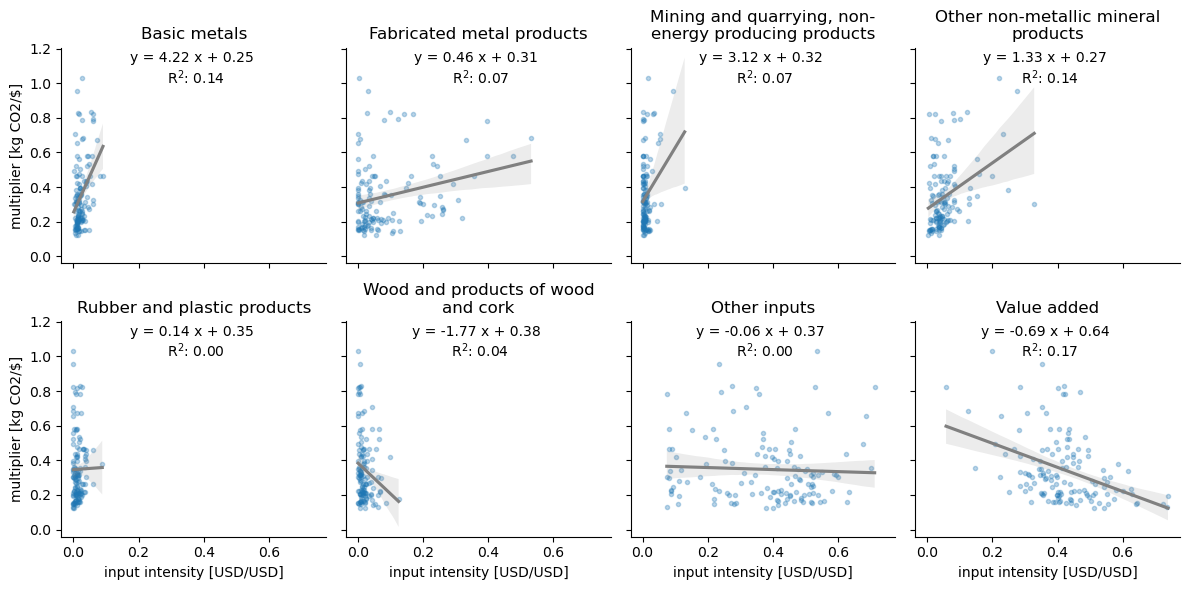

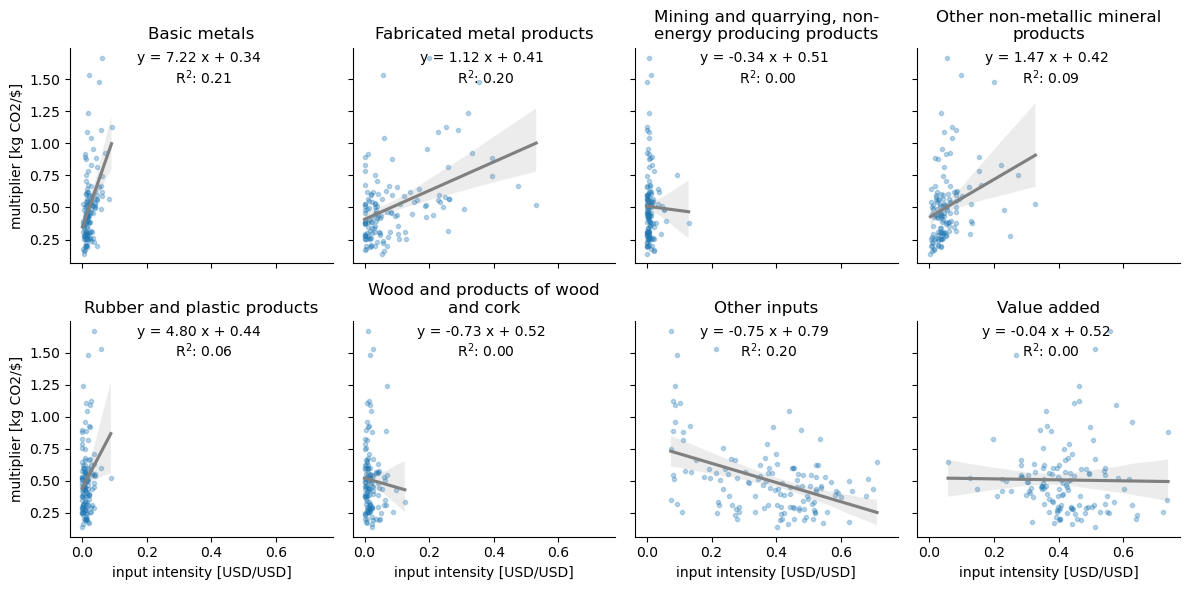

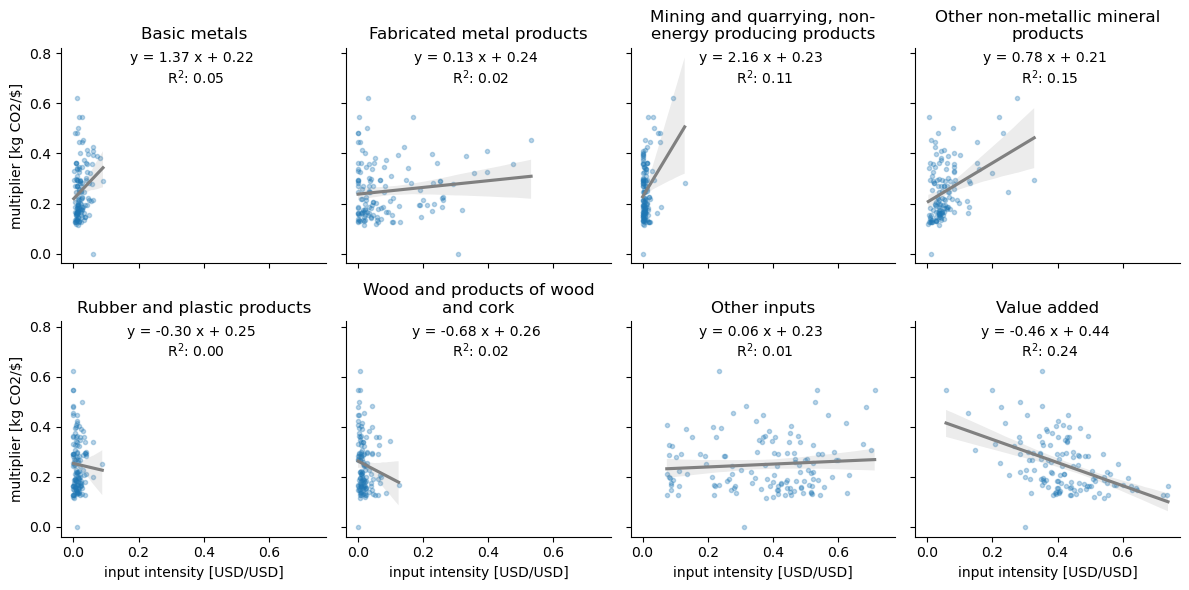

In [165]:
Z_ccol_sub_eu_grouped = Z_ccol_sub_eu.groupby(level=1, sort=False).sum().reindex(Z.loc['AUT'].index)
Z_ccol_sub_eu_grouped.loc['Value added'] = V_ccol_sub_eu.loc['VA']
mat_phys_summary = Z_ccol_sub_eu_grouped.copy()
sector_agg = ['_Other inputs']*3 + ['Mining and quarrying, non-energy producing products'] + ['_Other inputs'] + ['_Other inputs']*2 + ['Wood and products of wood and cork'] + ['_Other inputs']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_Other inputs']*6 + ['_Other inputs']*2 + ['_Other inputs'] + ['_Other inputs']*7 + ['_Other inputs']*3 + ['_Other inputs']*2 + ['_Other inputs']*8 + ['_Value added']
mat_phys_summary.index = sector_agg
mat_phys_summary = mat_phys_summary.groupby(level=0).sum().droplevel(level=1, axis=1)
mat_intensity = mat_phys_summary.div(x_crow_sub_eu_icio.rename_axis(['region', 'subsector']), axis=1) #million kg / million $ = kg/$
mat_list = pd.DataFrame(mat_intensity.T.stack())
e_c_sub_eu_hybrid_sum = pd.read_csv('processed_data/e_c_sub_eu_hybrid_sum_figaro.csv', index_col=[0,1]).squeeze()
mat_list = mat_list.join(e_c_sub_eu_hybrid_sum.rename_axis(['region', 'subsector']).rename('footprint'), on=['region', 'subsector'])
mat_list = mat_list.join((e_c_sub_eu_hybrid_sum.rename_axis(['region', 'subsector']) / y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0)).rename('multiplier [kg CO2/$]')*1e3, on=['region', 'subsector'], rsuffix='_')
mat_list.columns = ['input intensity [USD/USD]', 'footprint', 'multiplier [kg CO2/$]']
mat_list = mat_list.reset_index()
mat_list = mat_list.replace('_Other inputs', 'Other inputs').replace('_Value added', 'Value added')

g = sns.lmplot(x="input intensity [USD/USD]", y='multiplier [kg CO2/$]', col="level_2",
                   col_wrap=4, height=3, data=mat_list, markers='.', scatter_kws={'alpha':0.3}, line_kws={'color':'grey'})
for key,ax in g.axes_dict.items():
    ax.set_title(fill(f"{key}", 27))
def annotate(data, **kws):
    m, b, r_value, p_value, std_err = sp.stats.linregress(data["input intensity [USD/USD]"],data['multiplier [kg CO2/$]'])
    ax = plt.gca()
    ax.text(0.5, 0.9, f"y = {m:.2f} x + {b:.2f} \n R$^2$: {r_value**2:.2f}",
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
g.map_dataframe(annotate)
g.savefig('images/scatterplot_mult_input_figaro.png', bbox_inches='tight')


mat_phys_summary = Z_ccol_sub_eu_grouped.copy()
sector_agg = ['_Other inputs']*3 + ['Mining and quarrying, non-energy producing products'] + ['_Other inputs'] + ['_Other inputs']*2 + ['Wood and products of wood and cork'] + ['_Other inputs']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_Other inputs']*6 + ['_Other inputs']*2 + ['_Other inputs'] + ['_Other inputs']*7 + ['_Other inputs']*3 + ['_Other inputs']*2 + ['_Other inputs']*8 + ['_Value added']
mat_phys_summary.index = sector_agg
mat_phys_summary = mat_phys_summary.groupby(level=0).sum().droplevel(level=1, axis=1)
mat_intensity = mat_phys_summary.div(x_crow_sub_eu_icio.rename_axis(['region', 'subsector']), axis=1) #million kg / million $ = kg/$
mat_list = pd.DataFrame(mat_intensity.T.stack())
e_c_sub_eu_hybrid_sum = pd.read_csv('processed_data/e_c_sub_eu_hybrid_sum_bonsai.csv', index_col=[0,1]).squeeze()
mat_list = mat_list.join(e_c_sub_eu_hybrid_sum.rename_axis(['region', 'subsector']).rename('footprint'), on=['region', 'subsector'])
mat_list = mat_list.join((e_c_sub_eu_hybrid_sum.rename_axis(['region', 'subsector']) / y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0)).rename('multiplier [kg CO2/$]')*1e3, on=['region', 'subsector'], rsuffix='_')
mat_list.columns = ['input intensity [USD/USD]', 'footprint', 'multiplier [kg CO2/$]']
mat_list = mat_list.reset_index()
mat_list = mat_list.replace('_Other inputs', 'Other inputs').replace('_Value added', 'Value added')

g = sns.lmplot(x="input intensity [USD/USD]", y='multiplier [kg CO2/$]', col="level_2",
                   col_wrap=4, height=3, data=mat_list, markers='.', scatter_kws={'alpha':0.3}, line_kws={'color':'grey'})
for key,ax in g.axes_dict.items():
    ax.set_title(fill(f"{key}", 27))
g.map_dataframe(annotate)
g.savefig('images/scatterplot_mult_input_bonsai.png', bbox_inches='tight')


mat_phys_summary = Z_ccol_sub_eu_grouped.copy()
sector_agg = ['_Other inputs']*3 + ['Mining and quarrying, non-energy producing products'] + ['_Other inputs'] + ['_Other inputs']*2 + ['Wood and products of wood and cork'] + ['_Other inputs']*4 + ['Rubber and plastic products'] + ['Other non-metallic mineral products'] + ['Basic metals'] +['Fabricated metal products'] + ['_Other inputs']*6 + ['_Other inputs']*2 + ['_Other inputs'] + ['_Other inputs']*7 + ['_Other inputs']*3 + ['_Other inputs']*2 + ['_Other inputs']*8 + ['_Value added']
mat_phys_summary.index = sector_agg
mat_phys_summary = mat_phys_summary.groupby(level=0).sum().droplevel(level=1, axis=1)
mat_intensity = mat_phys_summary.div(x_crow_sub_eu_icio.rename_axis(['region', 'subsector']), axis=1) #million kg / million $ = kg/$
mat_list = pd.DataFrame(mat_intensity.T.stack())
e_c_sub_eu_hybrid_sum = pd.read_csv('processed_data/e_c_sub_eu.csv', index_col=[0,1]).squeeze()
mat_list = mat_list.join(e_c_sub_eu_hybrid_sum.rename_axis(['region', 'subsector']).rename('footprint'), on=['region', 'subsector'])
mat_list = mat_list.join((e_c_sub_eu_hybrid_sum.rename_axis(['region', 'subsector']) / y_sub_eu.loc[pd.IndexSlice[eu_labels,c,:]].droplevel('sector', axis=0)).rename('multiplier [kg CO2/$]')*1e3, on=['region', 'subsector'], rsuffix='_')
mat_list.columns = ['input intensity [USD/USD]', 'footprint', 'multiplier [kg CO2/$]']
mat_list = mat_list.reset_index()
mat_list = mat_list.replace('_Other inputs', 'Other inputs').replace('_Value added', 'Value added')

g = sns.lmplot(x="input intensity [USD/USD]", y='multiplier [kg CO2/$]', col="level_2",
                   col_wrap=4, height=3, data=mat_list, markers='.', scatter_kws={'alpha':0.3}, line_kws={'color':'grey'})
for key,ax in g.axes_dict.items():
    ax.set_title(fill(f"{key}", 27))
g.map_dataframe(annotate)
g.savefig('images/scatterplot_mult_input.png', bbox_inches='tight')

### Sensitivity Analysis

In [166]:
mult_sector_sub = {}
e_sub_eu = {}
for agg, building_mi_source, transport_stocks, zmatching, residuals_distribution in [['', '', '', '', '_residualsinOCE'], ['_agg', '', '', '', '_residualsconservative'], ['', '_rasmi', '', '', '_residualsinOCE'], ['_agg', '', '_wiedenhoferscaled', '', '_residualsdistributed'], ['_agg', '', '', '_zmatching', '_residualsdistributed'], ['_agg', '', '', '', '_residualsdistributed'], ['_agg', '_rasmi', '', '', '_residualsdistributed']]:
    mult_sector_sub[agg+configuration_bottomup+zmatching+residuals_distribution] = pd.read_csv('processed_data/mult_sector_sub'+configuration+'.csv', index_col=[0], header=[0,1,2], nrows=2).loc[f_label].drop('Total', level=2)*1e6
    e_sub_eu[agg+configuration_bottomup+zmatching+residuals_distribution] = pd.read_csv('processed_data/e_sub_eu'+configuration+'.csv', index_col=[0], header=[0,1,2], nrows=2).loc[f_label].drop('Total', level=2)
mult_sector_sub_scenarios = pd.concat(mult_sector_sub, axis=1).drop(['_residualsinOCE','_rasmi_residualsinOCE'], axis=1)
mult_sector_sub_scenarios.columns = ['Conservative residuals','Transport stocks', 'Matching subsector output', 'Default', 'Building material intensity',]
mult_sector_sub_scenarios = mult_sector_sub_scenarios[['Default','Transport stocks', 'Building material intensity', 'Matching subsector output', 'Conservative residuals']].reset_index()
mult_sector_sub_scenarios.subsector = [s.split(',')[0] for s in mult_sector_sub_scenarios.subsector]
mult_sector_sub_scenarios = mult_sector_sub_scenarios.groupby(['region', 'subsector']).median()
e_sub_eu_scenarios = pd.concat(e_sub_eu, axis=1).replace(np.NaN, 0).drop(['_residualsinOCE', '_rasmi_residualsinOCE'], axis=1)
e_sub_eu_scenarios.columns = ['Conservative residuals','Transport stocks', 'Matching subsector output', 'Default', 'Building material intensity',]
e_sub_eu_scenarios = e_sub_eu_scenarios[['Default', 'Transport stocks', 'Building material intensity', 'Matching subsector output', 'Conservative residuals']].reset_index()
e_sub_eu_scenarios.subsector = [s.split(',')[0] for s in e_sub_eu_scenarios.subsector]
e_sub_eu_scenarios = e_sub_eu_scenarios.groupby(['region', 'subsector']).sum(numeric_only=True)

KeyError: "['_rasmi_residualsinOCE'] not found in axis"

In [ ]:
    df = e_sub_eu_scenarios.groupby(level=1).sum().div(e_sub_eu_scenarios.groupby(level=1).sum().sum(), axis=1).reindex(['Buildings', 'Roads', 'Railways', 'Electricity infrastructure', 'Other civil engineering']).stack().reset_index()
    df.columns = ['subsector', 'approach', 'percentage']
    colors = ['#fe6100', #buildings                                              
                                        '#648fff', #roads
                                        '#785ef0', #railways
                                        '#ffb000', #electricity
                                        '#808080', #other civil engineering
                                        '#000000', #construction
                                        ]
    fig = px.bar(df, x='percentage', y='approach',color='subsector', text=df['percentage'].apply(lambda x: '{0:.1%}'.format(x)), labels={'percentage':'Carbon footprint of EU construction in '+str(iot_year)+' [% Mt CO<sub>2</sub> emission]', 'subsector':''}, template='simple_white', 
             color_discrete_sequence=colors) 
    fig.update_traces(textposition='inside')
    
    fig.update_layout(width=1000, height=400, 
                      xaxis_tickformat = '.0%',
                      legend=dict(
        orientation="h",
        #entrywidth=70,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        #x=1
    ))

    fig.write_image("images/stackedbar_e_sub_eu_share_method_sensitivity_"+f_label+"_"+str(iot_year)+configuration+".svg")
    fig.show()

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied

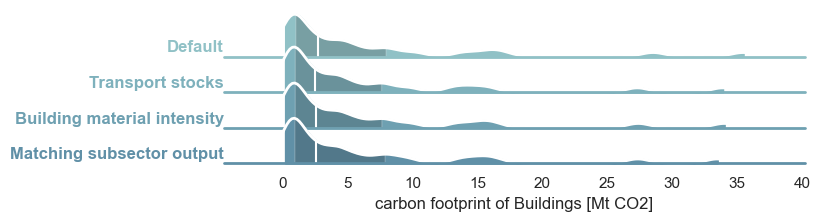

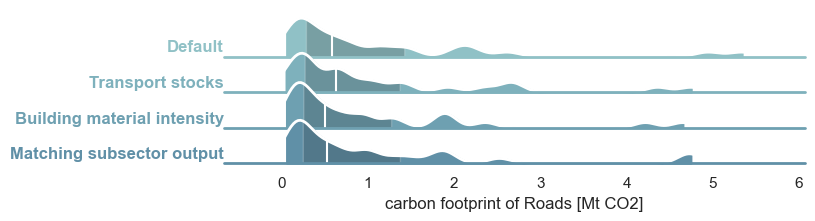

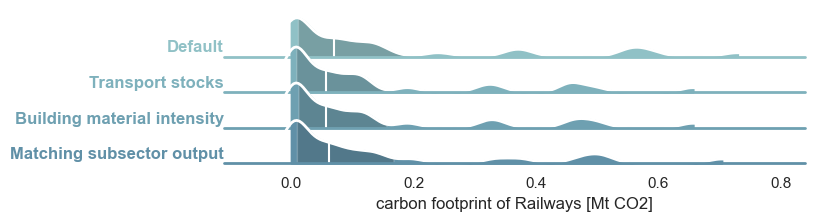

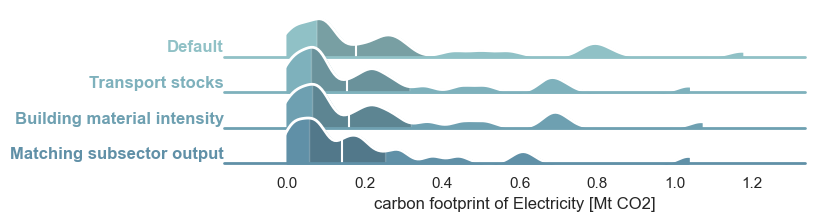

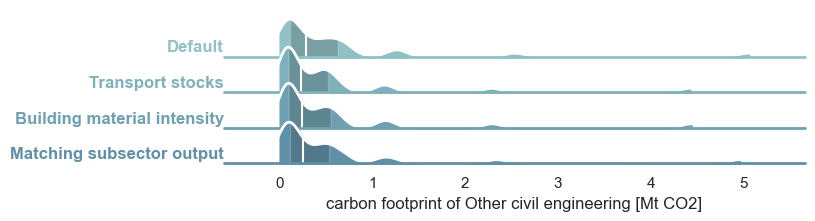

In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
for i in j_labels:
      df = e_sub_eu_scenarios.stack().xs(i, level=1).reset_index().drop('region', axis=1)
      df.columns = ['g', 'carbon footprint of '+i+' [Mt CO2]']

      # Initialize the FacetGrid object
      pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
      g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

      # Draw the densities in a few steps
      g.map(sns.kdeplot, 'carbon footprint of '+i+' [Mt CO2]',
            bw_adjust=.2, cut=0, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, 'carbon footprint of '+i+' [Mt CO2]', clip_on=False, color="w", lw=2, bw_adjust=.2)
      
      for plotname, ax in g.axes_dict.items():
            kdeline = ax.lines[0]
            #middle = df.loc[df['g']==plotname, 'carbon footprint of '+i+' [Mt CO2]'].median()
            left, middle, right = np.percentile(df.loc[df['g']==plotname, 'carbon footprint of '+i+' [Mt CO2]'], [25, 50, 75])
            xs = kdeline.get_xdata()
            ys = kdeline.get_ydata()
            #height = np.interp(mean, xs, ys)
            ax.vlines(middle, 0, np.interp(middle, xs, ys), color='white', ls='-')
            #ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
            #ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
            ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=False, facecolor='k', alpha=0.2)
      

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                        ha="right", va="center", transform=ax.transAxes)


      g.map(label, 'carbon footprint of '+i+' [Mt CO2]')

      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles('')
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)

      g.savefig('images/kdeplot_e_sub_eu_'+i+'_scenarios.svg')

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.

/Users/Mira/opt/anaconda3/envs/EEIOA/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

Tight layout not applied

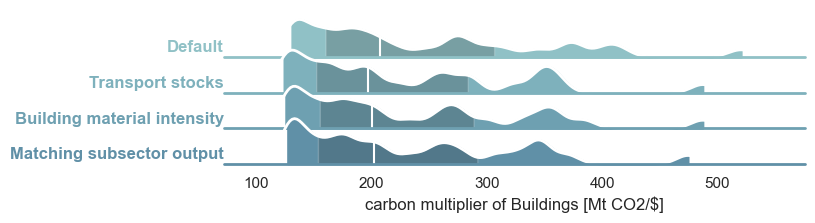

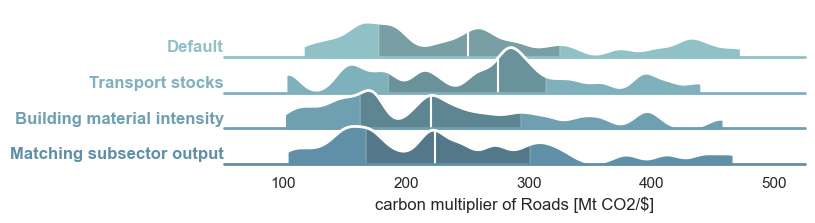

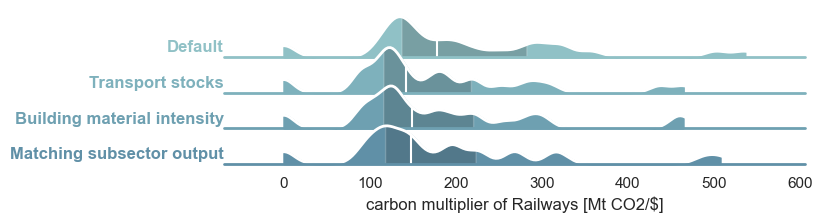

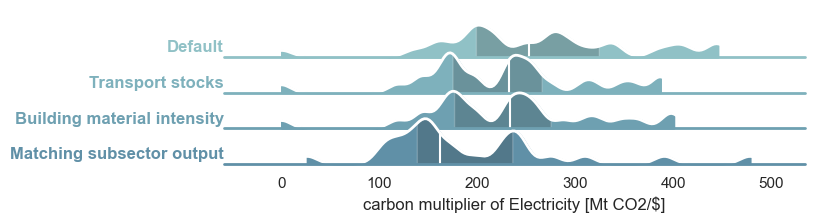

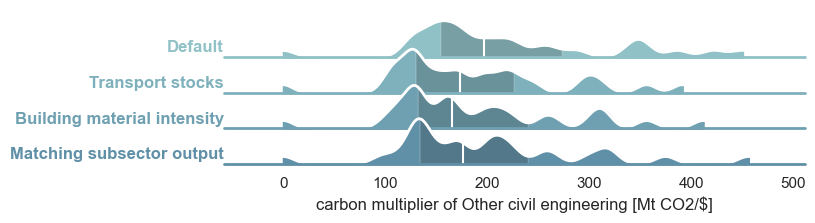

In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
for i in j_labels:
      df = mult_sector_sub_scenarios.stack().xs(i, level=1).reset_index().drop('region', axis=1)
      df.columns = ['g', 'carbon multiplier of '+i+' [Mt CO2/$]']

      # Initialize the FacetGrid object
      pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
      g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

      # Draw the densities in a few steps
      g.map(sns.kdeplot, 'carbon multiplier of '+i+' [Mt CO2/$]',
            bw_adjust=.2, cut=0, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
      g.map(sns.kdeplot, 'carbon multiplier of '+i+' [Mt CO2/$]', clip_on=False, color="w", lw=2, bw_adjust=.2)
      
      for plotname, ax in g.axes_dict.items():
            kdeline = ax.lines[0]
            #middle = df.loc[df['g']==plotname, 'carbon footprint of '+i+' [Mt CO2]'].median()
            left, middle, right = np.percentile(df.loc[df['g']==plotname, 'carbon multiplier of '+i+' [Mt CO2/$]'], [25, 50, 75])
            xs = kdeline.get_xdata()
            ys = kdeline.get_ydata()
            #height = np.interp(mean, xs, ys)
            ax.vlines(middle, 0, np.interp(middle, xs, ys), color='white', ls='-')
            #ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
            #ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
            ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=False, facecolor='k', alpha=0.2)
      

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                        ha="right", va="center", transform=ax.transAxes)


      g.map(label, 'carbon multiplier of '+i+' [Mt CO2/$]')

      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles('')
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)

      g.savefig('images/kdeplot_mult_sector_sub_'+i+'_scenarios.svg')